In [1]:
import sys
sys.path.append('/import/silo2/aloe8475/Documents/edamame')

In [2]:
from scipy.io import loadmat, savemat
from scipy.stats import kurtosis, skew

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import datetime
import networkx as nx
from edamame import *
from tqdm.notebook import tqdm_notebook
import os
import edamame.core.wires as wires
from random import choice
from IPython.core.debugger import set_trace
import nct
import bct

import pickle 
import _pickle as cPickle
import gzip
def compressed_pickle(obj, filename,protocol=-1):
    with gzip.open(filename, 'wb') as f:
        cPickle.dump(obj, f, protocol)
def decompress_pickle(file):
    with gzip.open(file, 'rb') as f:
        loaded_object = cPickle.load(f)
        return loaded_object

### Functions

In [3]:
import six

def render_mpl_table(corrType,data,chosenBeta,chosenDeg, fig,ax, rowTitle, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0, **kwargs):
    size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
    ax.axis('off')
    data=data.round(4)
    
    if rowTitle==True:
        mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns,rowLabels=data.index,loc='center')
    else:
        mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns,loc='center')


    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        elif corrType ==2:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])            
    if chosenBeta==None and chosenDeg==None:
        if corrType == 1:
            ax.set_title('PC1 Correlations')
        elif corrType ==2:
            ax.set_title('PC2 Correlations')
        else:
            ax.set_title('Delta Correlations')

    elif chosenDeg==None and chosenBeta>0:
        if corrType == 1:
            ax.set_title('PC1 Correlations - Beta ' + str(round(chosenBeta,2)))
        elif corrType ==2:
            ax.set_title('PC2 Correlations - Beta ' + str(round(chosenBeta,2)))
        else:
            ax.set_title('Delta Correlations - Beta ' + str(round(chosenBeta,2)))
            
    elif chosenBeta==None and chosenDeg > 0:
        if corrType == 1:
            ax.set_title('PC1 Correlations - AvgDeg ' + str(chosenDeg))
        elif corrType ==2:
            ax.set_title('PC2 Correlations - AvgDeg ' + str(chosenDeg))
        else:
            ax.set_title('Delta Correlations - AvgDeg ' + str(chosenDeg))
            
    return ax,size



# NLT vs MC:

## ASN Networks

Load Data

In [4]:
networkType='NWN'

In [5]:
print('Loading Networks, MC and NLT Results')

if networkType == 'HNW':
    print('HNW')

#     name=r'/import/silo2/aloe8475/Documents/CODE/Analysis/Functional Connectivity/Functional Tasks/HierarchicalNetworks.pkl'
    name=r'/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/HierarchicalNetworks_HMN1.pkl'
    file = open(name, 'rb')
    [HNW] = pickle.load(file)

    name='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/Hierarchical Results/VoltageSweep_AllNetworks_HNW_NLT.pkl'
    print('Loading Hierarchical Voltage Sweep Results')
    file = open(name, 'rb')
    [results] = pickle.load(file)
    
    name='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/Hierarchical Results/VoltageSweep_AllNetworks_HNW_MC.pkl'
    file = open(name, 'rb')
    [results_MC] = pickle.load(file)

#WS:
elif networkType == 'WS':
# numNodes=300
# BetaVals=np.linspace(0.1,1,10)
# avgDeg=[2,4,8,16,32]
# numNetworks=50
    print('WS')

    name='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/BetaSweep/WS_BetaSweepNetworks.pkl'
    file = open(name, 'rb')
    [WS] = pickle.load(file)
    
    #WS
    name='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/VoltageSweep_AllNetworks_WS_MC.pkl'
    file = open(name, 'rb')
    [results_MC] = pickle.load(file)
    temp=np.vstack(results_MC)
    results_MC=np.mean(temp.T,axis=1)
    name='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/VoltageSweep_AllNetworks_WS_NLT.pkl'
    file = open(name, 'rb')
    [results] = pickle.load(file)

elif networkType=='BA':
# BA:
    print('BA')

    name='BA_Allnetworks_LinearTransformation.pkl' #Shortest Path for NLT, 2V for MC
    file = open(name, 'rb')
    [BA] = pickle.load(file)
    ## BA
    name='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/VoltageSweep_AllNetworks_BA_MC.pkl'
    file = open(name, 'rb')
    [results_MC] = pickle.load(file)
    name='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/VoltageSweep_AllNetworks_BA_NLT.pkl'
    file = open(name, 'rb')
    [results] = pickle.load(file)
elif networkType=='NWN':
# # #NWN:
    print('NWN')
    name='/import/silo2/aloe8475/Documents/CODE/Analysis/Functional Connectivity/Functional Tasks/networks_2VNonlinearTransformation+2VMC.pkl' #2V for both NLT and MC
    # name='networks_NonlinearTransformation+6VMC.pkl'
    file = open(name, 'rb')
    [ASN300] = pickle.load(file)
    
    #NWN
    name='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/VoltageSweep_AllNetworks_NWN_NLT+MC.pkl'
    print('Loading NLT Voltage Sweep Results')
    file = open(name, 'rb')
    [results,results_MC] = pickle.load(file)

#Elegans/Crossbar:
# name='elegans_LinearTransformation.pkl' #2V for both NLT and MC
# name='barpartite_LinearTransformation_2V.pkl'
# file = open(name, 'rb')
# [crossbar] = pickle.load(file)

# #Elegans / crossbar
# name='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/VoltageSweep_Elegans_NLT+MC.pkl'
# name='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/VoltageSweep_Crossbar_NLT+MC.pkl'
# print('Loading NLT Voltage Sweep Results')
# file = open(name, 'rb')
# [results,results_MC] = pickle.load(file)
# print('Loaded')


print('Loaded')

Loading Networks, MC and NLT Results
NWN
Loading NLT Voltage Sweep Results
Loaded


In [20]:
# #save network figure
# fig=plt.figure()
# axBig = fig.add_subplot(111)
# axBig.set_yticklabels([])
# axBig.set_xticklabels([])
# axBig.set_yticks([])
# axBig.set_xticks([])
# axBig.set_frame_on(False)
# nw=ASN300[8][4]
# pos=nx.kamada_kawai_layout(nw['G'])
# nx.draw_networkx_nodes(nw['G'],pos=pos,node_size=10)
# nx.draw_networkx_edges(nw['G'],pos=pos,edge_size=0.5,alpha=0.3)
# plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/NWN.pdf',format='pdf',dpi=600)

In [22]:
import pandas as pd

if networkType == 'BA' or networkType == 'WS' or networkType == 'HNW':
    #BA+WS Analysis
    if networkType=='BA':
        Network=BA
    elif networkType=='WS':
        Network=[]
        for i in range(len(WS)):
            for j in range(len(WS[i])):
                for k in range(len(WS[i][j])):
                    Network.append(WS[i][j][k])
        betavals=[]
    else:
        Network=HNW

    centroid=[]
    wireLen=[]
    dispersion=[]
    degree=[]
    avgDeg=[]
    mod=[]
    sw=[]
    pcoeff=[]
    mz=[]
    skewDeg=[]
    sp_amp=[]
    graphs=[]
    spl=[]
    density=[]
    circuitRank=[]
    centrality=[]
    dCentrality=[]
    diverseClub=[]
    for i in tqdm(range(len(Network))):
        if networkType=='BA':
            avgDeg.append((np.mean(np.asarray(Network[i]['G'].degree())[:,1])))
            temp=getFarthestPairing(Network[i]['adj_matrix'])
        elif networkType=='WS':
            avgDeg.append(Network[i]['AvgDeg'])
            betavals.append(Network[i]['BetaValue'])
            temp=getFarthestPairing(nx.adjacency_matrix(Network[i]['G']).todense())
        else:
            avgDeg.append((np.mean(np.asarray(Network[i]['G'].degree())[:,1])))
            temp=getFarthestPairing(Network[i]['AdjMat'])
        spl.append(nx.shortest_path_length(Network[i]['G'],temp[0],temp[1]))
        degree.append(np.asarray(Network[i]['G'].degree())[:,1])
        mod.append(Network[i]['Graph Theory']['Modularity Score'])
        sw.append(Network[i]['Graph Theory']['Small World'])
        pcoeff.append(Network[i]['Graph Theory']['PCoeff'])
        mz.append(Network[i]['Graph Theory']['MZ'])
        skewDeg.append((skew(np.asarray(Network[i]['G'].degree())[:,1])))
#         sp_amp.append(Network[i]['sp_amp'])
        density.append(nx.density(Network[i]['G']))
        graphs.append(Network[i]['G'])
        centrality.append(nx.betweenness_centrality(Network[i]['G']))
        dCentrality.append(nx.degree_centrality(Network[i]['G']))
        #circuit rank = Edges - (Vertices - 1)
        circuitRank.append(Network[i]['G'].number_of_edges()-(Network[i]['G'].number_of_nodes()-1))
        diverseClub.append(pcoeff[i]>=np.percentile(pcoeff[i], 80))

In [6]:
#NWN Analysis
if networkType == 'NWN' or networkType=='Crossbar' or networkType=='Elegans':
    Network=[]
    if networkType =='NWN':
        for i in range(len(ASN300)):
            for j in range(len(ASN300[i])):
                Network.append(ASN300[i][j])
    else:
        Network.append(elegans)
    import pandas as pd
    centroid=[]
    wireLen=[]
    dispersion=[]
    degree=[]
    avgDeg=[]
    mod=[]
    sw=[]
    pcoeff=[]
    mz=[]
    skewDeg=[]
    sp_amp=[]
    graphs=[]
    spl=[]
    density=[]
    circuitRank=[]
    centrality=[]
    dCentrality=[]
    diverseClub=[]
    for i in tqdm(range(len(Network))):
        temp=getFarthestPairing(Network[i]['adj_matrix'])
        spl.append(nx.shortest_path_length(Network[i]['G'],temp[0],temp[1]))
        if networkType=='NWN':
            centroid.append(Network[i]['centroid_dispersion'])
            wireLen.append(Network[i]['avg_length'])
            dispersion.append(Network[i]['dispersion'])
            sp_amp.append(Network[i]['sp_amp'])
        avgDeg.append((np.mean(np.asarray(Network[i]['G'].degree())[:,1])))
        degree.append(np.asarray(Network[i]['G'].degree())[:,1])
        mod.append(Network[i]['Graph Theory']['Modularity Score'])
        sw.append(Network[i]['Graph Theory']['Small World'])
        pcoeff.append(Network[i]['Graph Theory']['PCoeff'])
        mz.append(Network[i]['Graph Theory']['MZ'])
        skewDeg.append((skew(np.asarray(Network[i]['G'].degree())[:,1])))
        density.append(nx.density(Network[i]['G']))
        graphs.append(Network[i]['G'])
        centrality.append(nx.betweenness_centrality(Network[i]['G']))
        dCentrality.append(nx.degree_centrality(Network[i]['G']))
        #circuit rank = Edges - (Vertices - 1)
        circuitRank.append(Network[i]['G'].number_of_edges()-(Network[i]['G'].number_of_nodes()-1))
        diverseClub.append(pcoeff[i]>=np.percentile(pcoeff[i], 80))
        #Diverse club: Nodes with PC > 80th percentile:


In [24]:
#Split into Beta Vals:
if networkType == 'WS':
    resultsBeta01=np.vstack((results[:250],results[2500:2750],results[5000:5250],results[7500:7750],results[10000:10250],results[12500:12750],results[15000:15250],results[17500:17750],results[20000:20250],results[22500:22750],results[25000:25250]))
    resultsBeta01_MC=np.hstack((results_MC[:250],results_MC[2500:2750],results_MC[5000:5250],results_MC[7500:7750],results_MC[10000:10250],results_MC[12500:12750],results_MC[15000:15250],results_MC[17500:17750],results_MC[20000:20250],results_MC[22500:22750],results_MC[25000:25250]))

    resultsBeta02=np.vstack((results[250:500],results[2750:3000],results[5250:5500],results[7750:8000],results[10250:10500],results[12750:13000],results[15250:15500],results[17750:18000],results[20250:20500],results[22750:23000],results[25250:25500]))
    resultsBeta02_MC=np.hstack((results_MC[250:500],results_MC[2750:3000],results_MC[5250:5500],results_MC[7750:8000],results_MC[10250:10500],results_MC[12750:13000],results_MC[15250:15500],results_MC[17750:18000],results_MC[20250:20500],results_MC[22750:23000],results_MC[25250:25500]))

    resultsBeta03=np.vstack((results[500:750],results[3000:3250],results[5500:5750],results[8000:8250],results[10500:10750],results[13000:13250],results[15500:15750],results[18000:18250],results[20500:20750],results[23000:23250],results[25500:25750]))
    resultsBeta03_MC=np.hstack((results_MC[500:750],results_MC[3000:3250],results_MC[5500:5750],results_MC[8000:8250],results_MC[10500:10750],results_MC[13000:13250],results_MC[15500:15750],results_MC[18000:18250],results_MC[20500:20750],results_MC[23000:23250],results_MC[25500:25750]))

    resultsBeta04=np.vstack((results[750:1000],results[3250:3500],results[5750:6000],results[8250:8500],results[10750:11000],results[13250:13500],results[15750:16000],results[18250:18500],results[20750:21000],results[23250:23500],results[25750:26000]))
    resultsBeta04_MC=np.hstack((results_MC[750:1000],results_MC[3250:3500],results_MC[5750:6000],results_MC[8250:8500],results_MC[10750:11000],results_MC[13250:13500],results_MC[15750:16000],results_MC[18250:18500],results_MC[20750:21000],results_MC[23250:23500],results_MC[25750:26000]))

    resultsBeta05=np.vstack((results[1000:1250],results[3500:3750],results[6000:6250],results[8500:8750],results[11000:11250],results[13500:13750],results[16000:16250],results[18500:18750],results[21000:21250],results[23500:23750],results[26000:26250]))
    resultsBeta05_MC=np.hstack((results_MC[1000:1250],results_MC[3500:3750],results_MC[6000:6250],results_MC[8500:8750],results_MC[11000:11250],results_MC[13500:13750],results_MC[16000:16250],results_MC[18500:18750],results_MC[21000:21250],results_MC[23500:23750],results_MC[26000:26250]))

    resultsBeta06=np.vstack((results[1250:1500],results[3750:4000],results[6250:6500],results[8750:9000],results[11250:11500],results[13750:14000],results[16250:16500],results[18750:19000],results[21250:21500],results[23750:24000],results[26250:26500]))
    resultsBeta06_MC=np.hstack((results_MC[1250:1500],results_MC[3750:4000],results_MC[6250:6500],results_MC[8750:9000],results_MC[11250:11500],results_MC[13750:14000],results_MC[16250:16500],results_MC[18750:19000],results_MC[21250:21500],results_MC[23750:24000],results_MC[26250:26500]))

    resultsBeta07=np.vstack((results[1500:1750],results[4000:4250],results[6500:6750],results[9000:9250],results[11500:11750],results[14000:14250],results[16500:16750],results[19000:19250],results[21500:21750],results[24000:24250],results[26500:26750]))
    resultsBeta07_MC=np.hstack((results_MC[1500:1750],results_MC[4000:4250],results_MC[6500:6750],results_MC[9000:9250],results_MC[11500:11750],results_MC[14000:14250],results_MC[16500:16750],results_MC[19000:19250],results_MC[21500:21750],results_MC[24000:24250],results_MC[26500:26750]))

    resultsBeta08=np.vstack((results[1750:2000],results[4250:4500],results[6750:7000],results[9250:9500],results[11750:12000],results[14250:14500],results[16750:17000],results[19250:19500],results[21750:22000],results[24250:24500],results[26750:27000]))
    resultsBeta08_MC=np.hstack((results_MC[1750:2000],results_MC[4250:4500],results_MC[6750:7000],results_MC[9250:9500],results_MC[11750:12000],results_MC[14250:14500],results_MC[16750:17000],results_MC[19250:19500],results_MC[21750:22000],results_MC[24250:24500],results_MC[26750:27000]))

    resultsBeta09=np.vstack((results[2000:2250],results[4500:4750],results[7000:7250],results[9500:9750],results[12000:12250],results[14500:14750],results[17000:17250],results[19500:19750],results[22000:22250],results[24500:24750],results[27000:27250]))
    resultsBeta09_MC=np.hstack((results_MC[2000:2250],results_MC[4500:4750],results_MC[7000:7250],results_MC[9500:9750],results_MC[12000:12250],results_MC[14500:14750],results_MC[17000:17250],results_MC[19500:19750],results_MC[22000:22250],results_MC[24500:24750],results_MC[27000:27250]))

    resultsBeta1=np.vstack((results[2250:2500],results[4750:5000],results[7250:7500],results[9750:10000],results[12250:12500],results[14750:15000],results[17250:17500],results[19750:20000],results[22250:22500],results[24750:25000],results[27250:27500]))
    resultsBeta1_MC=np.hstack((results_MC[2250:2500],results_MC[4750:5000],results_MC[7250:7500],results_MC[9750:10000],results_MC[12250:12500],results_MC[14750:15000],results_MC[17250:17500],results_MC[19750:20000],results_MC[22250:22500],results_MC[24750:25000],results_MC[27250:27500]))

### Voltage Analysis

In [7]:
#Calculate Best Voltage for each network:
onAmp=[0.2,0.5,0.75,1,1.25,1.5,1.75,2,3,5,10]
allAcc=[]
allMC=[]
allVolts=[]
allVoltsMC=[]
for i in range(len(results)): #for each network beta = 0.1
    temp=np.max(results[i])
    allAcc.append(temp)
    if networkType == 'NWN' or networkType == 'BA' or networkType == 'WS' or networkType=='HNW':
        allMC.append(results_MC[i])

if networkType == 'NWN' or networkType == 'BA':
    allAcc=np.vstack(allAcc).reshape(11,300)
    allMC=np.vstack(allMC).reshape(11,300)
elif networkType == 'WS':
    allAcc=np.vstack(allAcc).reshape(11,2500)
    allMC=np.vstack(allMC).reshape(11,2500)
elif networkType=='HNW':
    allAcc=np.vstack(allAcc).reshape(11,300)
    allMC=np.vstack(allMC).reshape(11,300)
else:
    allAcc=np.array(allAcc).reshape(11,1)
    allMC=np.array(results_MC).reshape(11,1)

vol1=[];vol2=[];vol3=[];vol4=[];vol5=[];vol6=[];vol7=[];vol8=[];vol9=[];vol10=[];vol11=[];
vol1MC=[];vol2MC=[];vol3MC=[];vol4MC=[];vol5MC=[];vol6MC=[];vol7MC=[];vol8MC=[];vol9MC=[];vol10MC=[];vol11MC=[];
for i in range(len(allAcc)):
    for j in range(len(allAcc[i])):
        if i==0:
            vol1.append(allAcc[i][j])
            vol1MC.append(allMC[i][j])
            
        elif i == 1:
            vol2.append(allAcc[i][j])
            vol2MC.append(allMC[i][j])

        elif i == 2:
            vol3.append(allAcc[i][j])
            vol3MC.append(allMC[i][j])

        elif i == 3:
            vol4.append(allAcc[i][j])
            vol4MC.append(allMC[i][j])

        elif i == 4:
            vol5.append(allAcc[i][j])
            vol5MC.append(allMC[i][j])

        elif i == 5:
            vol6.append(allAcc[i][j])
            vol6MC.append(allMC[i][j])

        elif i == 6:
            vol7.append(allAcc[i][j])
            vol7MC.append(allMC[i][j])

        elif i == 7:
            vol8.append(allAcc[i][j])
            vol8MC.append(allMC[i][j])

        elif i == 8:
            vol9.append(allAcc[i][j])
            vol9MC.append(allMC[i][j])

        elif i == 9:
            vol10.append(allAcc[i][j])
            vol10MC.append(allMC[i][j])

        elif i == 10:
            vol11.append(allAcc[i][j])
            vol11MC.append(allMC[i][j])

            
allVolts=np.vstack((vol1, vol2, vol3, vol4, vol5, vol6, vol7, vol8,vol9,vol10,vol11))
allVoltsMC=np.vstack((vol1MC, vol2MC, vol3MC, vol4MC, vol5MC, vol6MC, vol7MC, vol8MC,vol9MC,vol10MC,vol11MC))

            
#Find best and worst voltage for each network across the sweep:
idxBestAllNLT=np.argmax(allVolts,0)
BestAllNLT=np.max(allVolts,0)

idxWorstAllNLT=np.argmin(allVolts,0)
WorstAllNLT=np.min(allVolts,0)

bestAmpAllNLT=[]
for idx in idxBestAllNLT:
    bestAmpAllNLT.append(onAmp[idx])

worstAmpAllNLT=[]
for idx in idxWorstAllNLT:
    worstAmpAllNLT.append(onAmp[idx])  
    
    
idxBestAllMC=np.argmax(allVoltsMC,0)
BestAllMC=np.max(allVoltsMC,0)

idxWorstAllMC=np.argmin(allVoltsMC,0)
WorstAllMC=np.min(allVoltsMC,0)

bestAmpAllMC=[]
for idx in idxBestAllMC:
    bestAmpAllMC.append(onAmp[idx])

worstAmpAllMC=[]
for idx in idxWorstAllMC:
    worstAmpAllMC.append(onAmp[idx])  

In [8]:
#Best Networks for All Volts
maxID = np.argmax(allAcc, axis = 0)
maxID_MC = np.argmax(allMC, axis = 0)

In [9]:
if networkType == 'NWN' or networkType == 'BA':
    onAmpAll=np.tile(onAmp,(300,1)).T
    PCAll=np.array(np.tile(pcoeff,(11,1)))
    MZAll=np.tile(mz,(11,1))
elif networkType == 'WS':
    onAmpAll=np.tile(onAmp,(2500,1)).T
elif networkType=='HNW':
    onAmpAll=np.tile(onAmp,(300,1)).T
    PCAll=np.array(np.tile(pcoeff,(11,1)))
    MZAll=np.tile(mz,(11,1))
else:
    onAmpAll=onAmp
modAll=np.tile(mod,(11,1))
AvgDegAll=np.tile(avgDeg,(11,1))
swAll=np.tile(sw,(11,1))

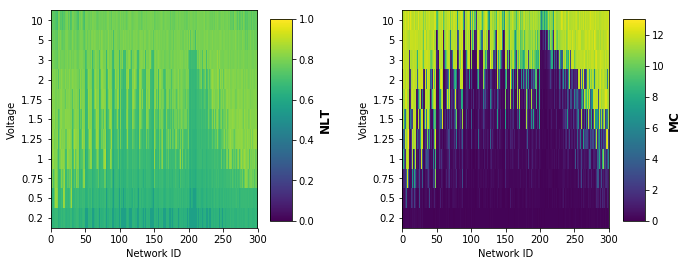

In [28]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
fig.subplots_adjust(wspace=0.7)
i=0
for ax in axes:
    if i == 0:
        im=ax.imshow(allVolts,origin='lower',vmin=0,vmax=1)
        ax.set_aspect('auto') 
        ax.set_yticks(np.array(range(len(onAmp))))
        ax.set_yticklabels(onAmp)
        ax.set_xlabel('Network ID')
        ax.set_ylabel('Voltage')
        cb=fig.colorbar(im,cax = fig.add_axes([0.43, 0.15, 0.03, 0.7]))
        cb.set_label(label='NLT', size='large', weight='bold')
      
    else:
        im=ax.imshow(allVoltsMC,origin='lower',vmin=0,vmax=13)
        ax.set_aspect('auto') 
        ax.set_xlabel('Network ID')
        ax.set_yticks(np.array(range(len(onAmp))))
        ax.set_yticklabels(onAmp)
        ax.set_ylabel('Voltage')
        cb=fig.colorbar(im,cax = fig.add_axes([0.92, 0.15, 0.03, 0.7]))
        cb.set_label(label='MC', size='large', weight='bold')

    i = i+1
    
plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/'+networkType+' Voltage Sweep - NLT+MC',dpi=300)    

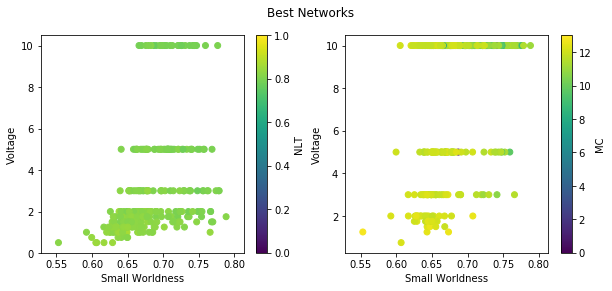

In [30]:
## Best Networks across voltage sweep:
if networkType =='NWN' or networkType == 'BA' or networkType=='WS' or networkType=='HNW':
    fig=plt.figure(figsize=(10,4))
    fig.suptitle('Best Networks')
    ax=[None]*2
    ax[0]=fig.add_subplot(121)
    plt.scatter(sw,onAmpAll[maxID,0],c=BestAllNLT,vmin=0,vmax=1)
    # plt.yscale('log')
    # plt.xscale('log')
    plt.xlabel('Small Worldness')
    plt.ylabel('Voltage')
    cb=plt.colorbar(label='NLT')

    ax[1]=fig.add_subplot(122)
    plt.scatter(sw,onAmpAll[maxID_MC,0],c=BestAllMC,vmin=0,vmax=13)
    # plt.yscale('log')
    # plt.xscale('log')
    plt.xlabel('Small Worldness')
    plt.ylabel('Voltage')
    cb=plt.colorbar(label='MC')
else:
    fig=plt.figure(figsize=(10,4))
    fig.suptitle('Best Networks')
    ax=[None]*2
    ax[0]=fig.add_subplot(121)
    plt.scatter(avgDeg,onAmpAll[maxID[0]],c=BestAllNLT,vmin=0,vmax=1)
    # plt.yscale('log')
    # plt.xscale('log')
    plt.xlabel('Mean Degree')
    plt.ylabel('Voltage')
    cb=plt.colorbar(label='NLT')

    ax[1]=fig.add_subplot(122)
    plt.scatter(avgDeg,onAmpAll[maxID_MC[0]],c=BestAllMC,vmin=0,vmax=13)
    # plt.yscale('log')
    # plt.xscale('log')
    plt.xlabel('Mean Degree')
    plt.ylabel('Voltage')
    cb=plt.colorbar(label='MC')
plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/'+networkType+' All Voltages Best Networks - NLT+MC SW',dpi=300)    

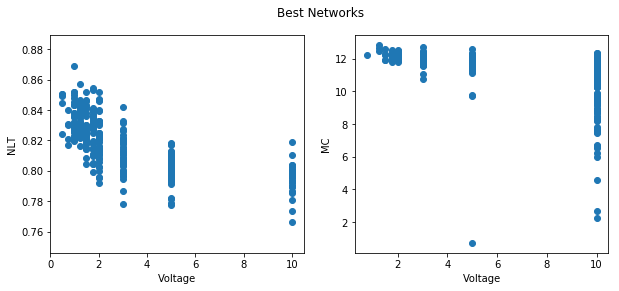

In [31]:
fig=plt.figure(figsize=(10,4))
fig.suptitle('Best Networks')
ax=[None]*2
ax[0]=fig.add_subplot(121)
plt.scatter(onAmpAll[maxID,0],BestAllNLT,vmin=0,vmax=1)
# plt.yscale('log')
# plt.xscale('log')
plt.ylabel('NLT')
plt.xlabel('Voltage')
# cb=plt.colorbar(label='NLT')

ax[1]=fig.add_subplot(122)
plt.scatter(onAmpAll[maxID_MC,0],BestAllMC,vmin=0,vmax=13)
# plt.yscale('log')
# plt.xscale('log')
plt.ylabel('MC')
plt.xlabel('Voltage')
# cb=plt.colorbar(label='MC')
plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/'+networkType+' Voltage Best Networks - NLT+MC',dpi=300)    

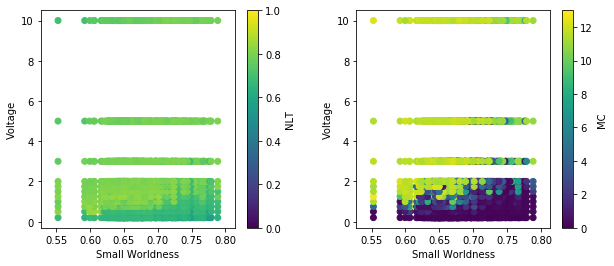

In [33]:
# All networks in voltage sweep:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

fig=plt.figure(figsize=(10,4))
ax=[None]*2
fig.subplots_adjust(wspace=.3)

cmap=plt.cm.inferno
ax[0]=fig.add_subplot(121)
p1=ax[0].scatter(swAll,onAmpAll,c=allVolts,vmin=0,vmax=1)
# plt.ylim([0,2.1])z
# plt.xlim([0.1,0.85])
# plt.yscale('log')
# plt.xscale('log')
plt.xlabel('Small Worldness')
plt.ylabel('Voltage')
cb=plt.colorbar(p1,label='NLT')

ax[1]=fig.add_subplot(122)
p2=plt.scatter(swAll,onAmpAll,c=allVoltsMC,vmin=0,vmax=13)
# plt.ylim([0,2.1])
# plt.xlim([0.1,0.85])

plt.xlabel('Small Worldness')
plt.ylabel('Voltage')

cb=plt.colorbar(p2,label='MC')


plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/'+networkType+' All Voltages Each Network - NLT+MC SW',dpi=300)    

### Accuracy Analysis

In [10]:
asn_acc=[]
asn_mod=[]
asn_avgDeg=[]
asn_numJunc=[]
asn_mc=[]
for i in tqdm(range(len(Network))):
    deg=np.mean([val for (node, val) in Network[i]['G'].degree()])
    asn_numJunc.append(Network[i]['G'].number_of_edges())
    asn_mod.append(np.nanmax(Network[i]['Graph Theory']['Modularity Score']))
    asn_avgDeg.append(deg)
    
        

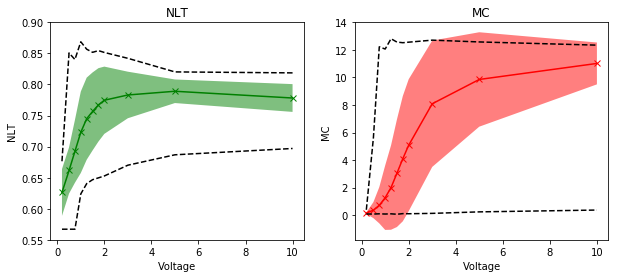

In [35]:
fig,axes=plt.subplots(1,2,figsize=(10,4))
i = 0
for ax in axes.flat:
    if i == 0:
        y=np.nanmean(allAcc,axis=1)
        error=np.nanstd(allAcc,axis=1)
        ax.plot(onAmp,np.nanmean(allAcc,axis=1),'g',marker='x')
        ax.plot(onAmp,np.nanmax(allAcc,axis=1),c='k',linestyle='--')
        ax.plot(onAmp,np.nanmin(allAcc,axis=1),c='k',linestyle='--')
        # plt.xticks(range(len(y)),labels=onAmp)
        ax.set_xlabel('Voltage')
        ax.set_ylabel('NLT')
        ax.set_ylim([0.55,0.9])
        ax.set_title('NLT')
        ax.fill_between(onAmp, y-error, y+error,alpha=0.5,facecolor='g')
    else:
        y=np.nanmean(allMC,axis=1)
        error=np.nanstd(allMC,axis=1)
        ax.plot(onAmp,np.nanmean(allMC,axis=1),c='r',marker='x')
        ax.plot(onAmp,np.max(allMC,axis=1),c='k',linestyle='--')
        ax.plot(onAmp,np.min(allMC,axis=1),c='k',linestyle='--')
        # plt.xticks(range(len(y)),labels=onAmp)
        ax.set_xlabel('Voltage')
        ax.set_ylabel('MC')
        ax.set_title('MC')
        ax.fill_between(onAmp, y-error, y+error,alpha=0.5,facecolor='r')
    i = i+1
    
plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/'+networkType+' Voltage Sweep (mean + max and min) - NLT + MC',dpi=300)    

In [858]:
voltNames=['0p2','0p5','0p75','1','1p25','1p5','1p75','2','3','5','10']
chosenVolt=10

In [859]:
#Voltage Sweep 
#Best of all Voltages
# asn_acc=allAcc#BestAllNLT 
# asn_mc=allMC#BestAllMC

# #Individual Voltages:

asn_acc=allVolts[chosenVolt,:]
asn_mc=allVoltsMC[chosenVolt,:]

In [860]:
voltNames[chosenVolt]

'10'

In [861]:
#Standardize NLT + MC:
asn_acc_new=(asn_acc-np.min(allVolts))/(np.max(allVolts)-np.min(allVolts))
asn_mc_new=(asn_mc-np.min(allVoltsMC))/(np.max(allVoltsMC)-np.min(allVoltsMC))

In [862]:
bwCentrality=[]
degCentrality=[]
dtype = dict(names = ['data'], formats=['float','float'])
# avgCoreNum=[]
for i in range(len(centrality)):
    bwCentrality.append(list(centrality[i].values()))
    degCentrality.append(list(dCentrality[i].values()))
#     avgCoreNum.append(np.mean(coreNum[i]))

##### K-Core Analysis - Castro (2020) Comp. Biol. https://doi.org/10.1371/journal.pcbi.1007686


In [863]:
# tempCoreNums=[[None]*len(ASN300[0]) for i in range(len(ASN300))]
# coreNum=[]
# count=0
# totalCoreNums=[]
# for i in tqdm(range(len(ASN300))):
#     for j in range(len(ASN300[i])):
#         coreNum.append(list(nx.core_number(ASN300[i][j]['G']).values()))
#         tempCoreNums[i][j]=[None]*len(coreNum[count])
#         for k in range(len(coreNum[count])):
#             tempCoreNums[i][j][k]=(list(range(1,np.max(coreNum[count][k]+1))))
            
        
#         totalCoreNums.append(tempCoreNums[i][j])
#         count=count+1
        
# nodesInShell=[]
# for i in range(len(totalCoreNums)):
#     a=[]
#     pad=[]
#     lst=[]
#     lst=totalCoreNums[i]
#     pad = len(max(lst, key=len))
#     a=np.array([i + [0]*(pad-len(i)) for i in lst])
#     nodesInShell.append(np.sum(a>0,0))

In [864]:
# for i in range(len(nodesInShell)):
#     plt.plot(np.max(totalCoreNums[i]),nodesInShell[i])

Text(0, 0.5, 'Standardized MC')

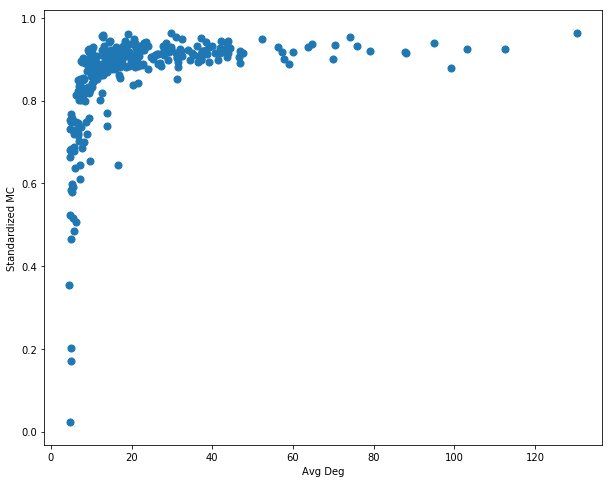

In [865]:
#SW vs MOD for NLT
fig=plt.figure(figsize=(10,8))
X=mod#[A:B]
D=avgDeg#[A:B]
Q=skewDeg#[A:B]
Y=sw#[A:B]
vmin=0.57
vmax=0.92
#X
p=plt.scatter(D, asn_mc_new,s=50,alpha=1,marker='o')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim([0,1])
# plt.ylim([1e-5,1e2])
plt.xlabel('Avg Deg')
plt.ylabel('Standardized MC')
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
# sm._A = []
# cb=fig.colorbar(sm,ax=plt.gca())
# cb.set_label(label='NLT', size='large', weight='bold')

# plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/BA AvgDeg vs Standardized VSweep MC.png',dpi=600)

In [866]:
#BA
dfAll=pd.DataFrame({'MemoryCapacity':asn_mc,'NonlinearTransform': asn_acc,'Centrality':bwCentrality,'PCoeff':pcoeff,'MZ':mz, 'Modularity':mod, 'SmallWorldness': sw,'AvgDeg':avgDeg,'DegSkew':skewDeg,'idx':np.array(range(0,300))})

## PCA

PCA analysis of Nonlinear Transformation Accuracy vs Memory Capacity: Can we divide the data into components that explain the distance of each network from other networks?

(0.5, 1)

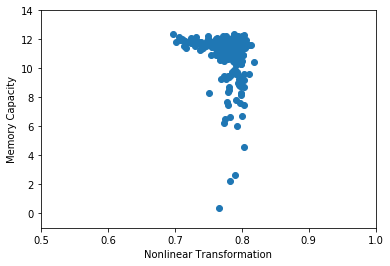

In [867]:
#PCA mem capacity vs nonlinear transformation acc
from sklearn.decomposition import PCA
plt.figure()
plt.xlabel('Nonlinear Transformation')

plt.ylabel('Memory Capacity')

# x=np.vstack((dfAll.MemoryCapacity.values.T, dfAll.NonlinearTransform.values.T))

plt.scatter(asn_acc,asn_mc)
plt.ylim([-1,14])
plt.xlim([0.5,1])


# pca=PCA(n_components=2)
# pca.fit(x)

# principalComponents = pca.components_

# print(pca.explained_variance_ratio_)
# print(principalComponents.T)
# plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/'+networkType+' Networks VSweep - MC + NLT.png')

In [868]:
# dfAll=pd.DataFrame({'MemoryCapacity':asn_mc,'NonlinearTransform': asn_acc,'PC1Loadings':principalComponents[0,:],'PC2Loadings':principalComponents[1,:],'Centrality':bwCentrality, 'Modularity':mod, 'SmallWorldness': sw,'AvgDeg':avgDeg,'DegSkew':skewDeg,'Centroid':centroid,'AvgWireLen':wireLen,'StdWireLen':dispersion,'Amp':sp_amp,'idx':np.array(range(0,300))})

In [869]:
# plt.scatter(principalComponents[0,:],principalComponents[1,:])
# plt.xlabel('PC1')
# plt.ylabel('PC2')

In [870]:
# #how do PC components correlate with MC and NLT accuracy? 
# PCLoadings=[]
# for i in range(len(pca.components_)):
#     PCLoadings.append(np.corrcoef(principalComponents[i,:],asn_acc)[1,0])
#     PCLoadings.append(np.corrcoef(principalComponents[i,:],asn_mc)[1,0])

How does each PCA component correlate with other network measures (e.g. small worldness, modularity, etc)?

In [871]:
# dfCorrelations=[]

In [872]:
# #Correlation between Small Worldness and PC1 Loadings:
# a=np.corrcoef(dfAll.PC1Loadings,sw)
# #Correlation between Modularity and PC1 Loadings:
# b=np.corrcoef(dfAll.PC1Loadings,mod)
# #Correlation between Avg Degree and PC1 Loadings:
# c=np.corrcoef(dfAll.PC1Loadings,avgDeg)
# #Correlation between Degree Skew and PC1 Loadings:
# c1=np.corrcoef(dfAll.PC1Loadings,skewDeg)
# #Correlation between Centroid Dispersion and PC1 Loadings:
# d=np.corrcoef(dfAll.PC1Loadings,centroid)
# #Correlation between Wire Length and PC1 Loadings:
# e=np.corrcoef(dfAll.PC1Loadings,wireLen)
# #Correlation between Wire Dispersion and PC1 Loadings:
# f=np.corrcoef(dfAll.PC1Loadings,dispersion)
# #Correlation between Accuracy and PC1 Loadings:
# dfCorrelations=pd.DataFrame({'Parameters':{'Centroid':d[1,0],'WireLen':e[1,0],'WireDisp':f[1,0]},'GraphTheory':{'Small Worldness':a[1,0],'Modularity':b[1,0],'AvgDeg':c[1,0],'SkewDeg':c1[1,0]},'Accuracy':{'NLT':PCLoadings[0],'MC':PCLoadings[1]}})


In [873]:
# #Correlation between Small Worldness and PC2 Loadings:
# a=np.corrcoef(dfAll.PC2Loadings,sw)
# #Correlation between Modularity and PC2 Loadings:
# b=np.corrcoef(dfAll.PC2Loadings,mod)
# #Correlation between Avg Degree and PC2 Loadings:
# c=np.corrcoef(dfAll.PC2Loadings,avgDeg)
# #Correlation between Degree Skew and PC2 Loadings:
# c1=np.corrcoef(dfAll.PC2Loadings,skewDeg)
# #Correlation between Centroid Dispersion and PC2 Loadings:
# d=np.corrcoef(dfAll.PC2Loadings,centroid)
# #Correlation between Wire Length and PC2 Loadings:
# e=np.corrcoef(dfAll.PC2Loadings,wireLen)
# #Correlation between Wire Dispersion and PC2 Loadings:
# f=np.corrcoef(dfAll.PC2Loadings,dispersion)
# #Correlation between Accuracy and PC2 Loadings:
# dfCorrelationsPC2=pd.DataFrame({'Parameters':{'Centroid':d[1,0],'WireLen':e[1,0],'WireDisp':f[1,0]},'GraphTheory':{'Small Worldness':a[1,0],'Modularity':b[1,0],'AvgDeg':c[1,0],'SkewDeg':c1[1,0]},'Accuracy':{'NLT':PCLoadings[2],'MC':PCLoadings[3]}})


In [874]:
# df1_styler = dfCorrelations.style.set_table_attributes("style='display:inline'").set_caption('PC1 Correlations')
# df2_styler = dfCorrelationsPC2.style.set_table_attributes("style='display:inline'").set_caption('PC2 Correlations')

# display_html(df1_styler._repr_html_()+"\xa0\xa0\xa0"+df2_styler._repr_html_(), raw=True)

In [875]:
# #Print Correlations Table:
# fig=plt.figure(figsize=(18,5))
# ax=[None]*2
# ax[0]=fig.add_subplot(121)
# render_mpl_table(1,dfCorrelations,None,None, fig,ax[0], rowTitle=True, header_columns=0, col_width=2.0)
# ax[1]=fig.add_subplot(122)
# render_mpl_table(2,dfCorrelationsPC2,None,None, fig,ax[1],rowTitle=False, header_columns=0, col_width=2.0)
# plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/ASN Networks VSweep PCA Component Correlations Standardised Accuracy.png')

### Delta 
We Standardize MC and NLT values and compare them to see how different networks perform on individual tasks, or both tasks

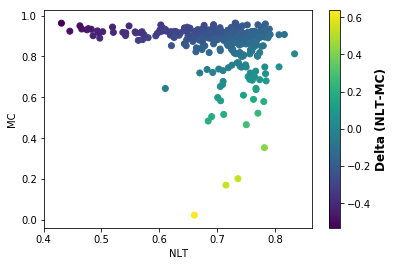

In [876]:
#Standardized Scatter MC vs NLT:
# logAsn_mc=np.log(asn_mc)
# plt.scatter(asn_acc,logAsn_mc) #original scatter
plt.figure()
delta=asn_acc_new-asn_mc_new #delta tells us how much better each network is at NLT compared to MC
plt.scatter(asn_acc_new,asn_mc_new,c=delta)
plt.xlabel('NLT')
plt.ylabel('MC')
cb=plt.colorbar()
cb.set_label(label='Delta (NLT-MC)', size='large', weight='bold')
# plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/BA Standardized VSweep Delta (NLT-MC)',dpi=300)    

In [877]:
#Correlation between Small Worldness and delta:
a=np.corrcoef(delta,sw)
#Correlation between Modularity and delta:
b=np.corrcoef(delta,mod)
#Correlation between Avg Degree and delta:
c=np.corrcoef(delta,avgDeg)
#Correlation between Degree Skew and delta:
c1=np.corrcoef(delta,skewDeg)
#Correlation between Centroid Dispersion and delta:
d=np.corrcoef(delta,centroid)
#Correlation between Wire Length and delta:
e=np.corrcoef(delta,wireLen)
#Correlation between Wire Dispersion and delta:
f=np.corrcoef(delta,dispersion)
#Correlation between Accuracy and delta:
dfCorrelationdsDelta=pd.DataFrame({'Parameters':{'Centroid':d[1,0],'WireLen':e[1,0],'WireDisp':f[1,0]},'GraphTheory':{'Small Worldness':a[1,0],'Modularity':b[1,0],'AvgDeg':c[1,0],'SkewDeg':c1[1,0]}})


In [878]:
dfCorrelationdsDelta

Parameters  GraphTheory
AvgDeg                  NaN    -0.673276
Centroid           0.301611          NaN
Modularity              NaN     0.770932
SkewDeg                 NaN     0.407395
Small Worldness         NaN     0.535200
WireDisp          -0.003424          NaN
WireLen           -0.596447          NaN

### Mean Standardized Accuracy 

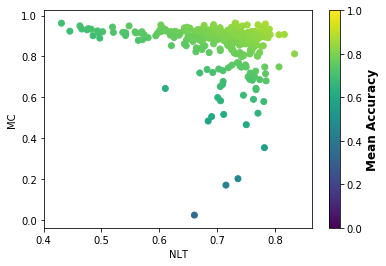

In [879]:
#Standardized Scatter MC vs NLT:
# logAsn_mc=np.log(asn_mc)
# plt.scatter(asn_acc,logAsn_mc) #original scatter
mean_accuracy=np.mean([asn_acc_new,asn_mc_new],0)

plt.figure()
plt.scatter(asn_acc_new,asn_mc_new,c=mean_accuracy,vmin=0,vmax=1)
plt.xlabel('NLT')
plt.ylabel('MC')
cb=plt.colorbar()
cb.set_label(label='Mean Accuracy', size='large', weight='bold')
# plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/BA Standardized VSweep vs Mean Accuracy',dpi=300)    

In [880]:
#Correlation between Small Worldness and Mean Accuracy Loadings:
a=np.corrcoef(mean_accuracy,sw)
#Correlation between Modularity and PC2 Loadings:
b=np.corrcoef(mean_accuracy,mod)
#Correlation between Avg Degree and PC2 Loadings:
c=np.corrcoef(mean_accuracy,avgDeg)
#Correlation between Degree Skew and PC2 Loadings:
c1=np.corrcoef(mean_accuracy,skewDeg)
#Correlation between Centroid Dispersion and PC2 Loadings:
d=np.corrcoef(mean_accuracy,centroid)
#Correlation between Wire Length and PC2 Loadings:
e=np.corrcoef(mean_accuracy,wireLen)
#Correlation between Wire Dispersion and PC2 Loadings:
f=np.corrcoef(mean_accuracy,dispersion)
#Correlation between Accuracy and PC2 Loadings:
dfCorrelationsMeanAcc=pd.DataFrame({'Parameters':{'Centroid':d[1,0],'WireLen':e[1,0],'WireDisp':f[1,0]},'GraphTheory':{'Small Worldness':a[1,0],'Modularity':b[1,0],'AvgDeg':c[1,0],'SkewDeg':c1[1,0]}})


In [881]:
# a='/import/silo2/aloe8475/Documents/CODE/Analysis/Functional Connectivity/Functional Tasks'

In [882]:
# #save mean accuracy + delta:
# # data={'Delta':delta,'MeanAcc':mean_accuracy,'PC':pcoeff,'MZ':mz}
# data={'Delta':delta,'MeanAcc':mean_accuracy,'PC':PCAll[chosenVolt],'MZ':MZAll[chosenVolt]}
# savemat(a+'/Delta Mean Acc/Delta_MeanAcc_'+networkType+' '+voltNames[chosenVolt]+'V.mat',data)

##### Only networks with Voltage Two or Less:

In [883]:
# #check if correlations still exist in voltage less than 2 
# idxAmpTwo=[]
# count=0
# for i in range(len(sp_amp)):
#     if sp_amp[i]<=2:
#         idxAmpTwo.append(count)
#         count=count+1

--- 

## Node-Level Analysis 

Compare PCoeff and MZ for Top 50 and Bottom 50 networks, for each task. 

Then, perform ttest on sw and modularity for Maximum and Minimum performing networks, to see if there is a difference in these measures

In [884]:
#sort df by accuracy:
dfAllMC=dfAll.sort_values('MemoryCapacity',ascending=True)
dfAllNLT=dfAll.sort_values('NonlinearTransform',ascending=True)

In [885]:
idxMaxMC=dfAllMC[-50:].idx.values#dfAll.loc[dfAll.MemoryCapacity>8].idx.values#
idxMinMC=dfAllMC[:50].idx.values#dfAll.loc[dfAll.MemoryCapacity<1].idx.values#
idxMaxNLT=dfAllNLT[-50:].idx.values#dfAll.loc[dfAll.NonlinearTransform>0.8].idx.values#
idxMinNLT=dfAllNLT[:50].idx.values#dfAll.loc[dfAll.NonlinearTransform<0.7].idx.values#

In [886]:
pcoeffMaxMC=[];pcoeffMinMC=[];pcoeffMaxNLT=[];pcoeffMinNLT=[];
mzMaxMC=[];mzMinMC=[];mzMaxNLT=[];mzMinNLT=[]
modMaxMC=[];modMinMC=[];modMaxNLT=[];modMinNLT=[]
swMaxMC=[];swMinMC=[];swMaxNLT=[];swMinNLT=[]
avgDegMaxMC=[];avgDegMinMC=[];avgDegMaxNLT=[];avgDegMinNLT=[];
skewDegMaxMC=[];skewDegMinMC=[];skewDegMaxNLT=[];skewDegMinNLT=[]
centroidMaxMC=[];centroidMinMC=[];centroidMaxNLT=[];centroidMinNLT=[]
wireLenMaxMC=[];wireLenMinMC=[];wireLenMaxNLT=[];wireLenMinNLT=[]
dispersionMaxMC=[];dispersionMinMC=[];dispersionMaxNLT=[];dispersionMinNLT=[]
centralityMaxNLT=[];centralityMinNLT=[];centralityMaxMC=[];centralityMinMC=[]
degMaxNLT=[];degMinNLT=[];degMaxMC=[];degMinMC=[]
degCentralityMaxNLT=[];degCentralityMinNLT=[];degCentralityMaxMC=[];degCentralityMinMC=[]
# coreNumMaxNLT=[];coreNumMinNLT=[];coreNumMaxMC=[];coreNumMinMC=[]
voltMaxNLT=[];voltMinNLT=[];voltMaxMC=[];voltMinMC=[];

pcoeffBeta=pcoeff#[A:B]
mzBeta=mz#[A:B]
modBeta=mod#[A:B]
swBeta=sw#[A:B]
avgDegBeta=avgDeg#[A:B]
skewDegBeta=skewDeg#[A:B]
bwCentralityBeta=bwCentrality#[A:B]
degCentralityBeta=degCentrality#[A:B]
degreeBeta=degree#[A:B]

for idx in idxMaxMC:
    pcoeffMaxMC.append(pcoeffBeta[idx])
    mzMaxMC.append(mzBeta[idx])
    modMaxMC.append(modBeta[idx])
    swMaxMC.append(swBeta[idx])
    avgDegMaxMC.append(avgDegBeta[idx])
    skewDegMaxMC.append(skewDegBeta[idx])
#     centroidMaxMC.append(centroid[idx])
#     wireLenMaxMC.append(wireLen[idx])
#     dispersionMaxMC.append(dispersion[idx])
    centralityMaxMC.append(bwCentralityBeta[idx])
    degCentralityMaxMC.append(degCentralityBeta[idx])
    degMaxMC.append(degreeBeta[idx])
    voltMaxMC.append(bestAmpAllMC[idx])
#     coreNumMaxMC.append(coreNum[idx])

for idx in idxMinMC:
    pcoeffMinMC.append(pcoeffBeta[idx])
    mzMinMC.append(mzBeta[idx])
    modMinMC.append(modBeta[idx])
    swMinMC.append(swBeta[idx])
    avgDegMinMC.append(avgDegBeta[idx])
    skewDegMinMC.append(skewDegBeta[idx])
#     centroidMinMC.append(centroid[idx])
#     wireLenMinMC.append(wireLen[idx])
#     dispersionMinMC.append(dispersion[idx])
    centralityMinMC.append(bwCentralityBeta[idx])
    degMinMC.append(degreeBeta[idx])
    degCentralityMinMC.append(degCentralityBeta[idx])
    voltMinMC.append(bestAmpAllMC[idx])
#     coreNumMinMC.append(coreNum[idx])

for idx in idxMaxNLT:
    pcoeffMaxNLT.append(pcoeffBeta[idx])
    mzMaxNLT.append(mzBeta[idx])
    modMaxNLT.append(modBeta[idx])
    swMaxNLT.append(swBeta[idx])
    avgDegMaxNLT.append(avgDegBeta[idx])
    skewDegMaxNLT.append(skewDegBeta[idx])
#     centroidMaxNLT.append(centroid[idx])
#     wireLenMaxNLT.append(wireLen[idx])
#     dispersionMaxNLT.append(dispersion[idx])
    centralityMaxNLT.append(bwCentralityBeta[idx])
    degMaxNLT.append(degreeBeta[idx])
    degCentralityMaxNLT.append(degCentralityBeta[idx])
    voltMaxNLT.append(bestAmpAllNLT[idx])

#     coreNumMaxNLT.append(coreNum[idx])


for idx in idxMinNLT:
    pcoeffMinNLT.append(pcoeffBeta[idx])
    mzMinNLT.append(mzBeta[idx])
    modMinNLT.append(modBeta[idx])
    swMinNLT.append(swBeta[idx])
    avgDegMinNLT.append(avgDegBeta[idx])
    skewDegMinNLT.append(skewDegBeta[idx])
#     centroidMinNLT.append(centroid[idx])
#     wireLenMinNLT.append(wireLen[idx])
#     dispersionMinNLT.append(dispersion[idx])
    centralityMinNLT.append(bwCentralityBeta[idx])
    degMinNLT.append(degreeBeta[idx])
    degCentralityMinNLT.append(degCentralityBeta[idx])
    voltMinNLT.append(bestAmpAllNLT[idx])
#     coreNumMinNLT.append(coreNum[idx])



In [887]:
def tolerant_mean(arrs): #find differences 
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.mean(axis = -1), arr.std(axis=-1)

In [888]:
def tolerant_min_max(arrs): #find differences 
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.min(axis = -1), arr.max(axis=-1)

In [889]:
def tolerant_resize(arrs): #find differences 
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr

In [890]:
#avg PC MZ and Centrality
avgpcoeffMin,stdpcoeffMin=tolerant_mean(pcoeffMinNLT)
avgmzMin,stdmzMin=tolerant_mean(mzMinNLT)

avgpcoeffMax,stdpcoeffMax=tolerant_mean(pcoeffMaxNLT)
avgmzMax,stdmzMax=tolerant_mean(mzMaxNLT)

avgpcoeffMinMC,stdpcoeffMinMC=tolerant_mean(pcoeffMinMC)
avgmzMinMC,stdmzMinMC=tolerant_mean(mzMinMC)

avgpcoeffMaxMC,stdpcoeffMax=tolerant_mean(pcoeffMaxMC)
avgmzMaxMC,stdmzMax=tolerant_mean(mzMaxMC)

avgcentralityMaxNLT,stdcentralityMaxNLT=tolerant_mean(centralityMaxNLT)
avgcentralityMinNLT,stdcentralityMinNLT=tolerant_mean(centralityMinNLT)

avgcentralityMaxMC,stdcentralityMaxMC=tolerant_mean(centralityMaxMC)
avgcentralityMinMC,stdcentralityMinMC=tolerant_mean(centralityMinMC)

### Plot Node-Level Graph Theory

In [702]:
#Nonlinear Transform
from edamame.analysis.misc import draw_zp_space
fig=plt.figure(figsize=(50,40))
fig.subplots_adjust(hspace=.6)
fig.subplots_adjust(wspace=.6)
ax=[None]*100
for i in range(len(ax)):
    if i < 50:
        ax[i]=plt.subplot(10,10, i+1)
        draw_zp_space(ax = ax[i])
        line = ax[i].scatter(pcoeffMinNLT[i],mzMinNLT[i],c='b')
    #     ax[i].set_title('Max Accuracy ',fontsize=30)
        ax[i].set_xlabel('PCoeff',fontsize=20)#,labelpad=5)
        ax[i].set_ylabel('MZ',fontsize=20)#,labelpad=5)
        plt.text(0.7,6,'SW:'+"{0:.2f}".format(dfAllNLT[:50].SmallWorldness.values[i]),fontsize=15)
        plt.text(0.7,8,'NLT:'+"{0:.2f}".format(dfAllNLT[:50].NonlinearTransform.values[i]),fontsize=15)
        ax[i].set_ylim(-6, 6)
        ax[i].set_xlim(0,1)
        
        ax[i].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
        ax[i].tick_params(axis='both', which='minor', labelsize=15)

    else:
        idx=i-50
#PCOEFF MZ MIN ACCURACY
        ax[i]=plt.subplot(10, 10, i+1)
        draw_zp_space(ax = ax[i])
        line = ax[i].scatter(pcoeffMaxNLT[idx],mzMaxNLT[idx],c='r')
    #     ax[i].set_title('Max Accuracy ',fontsize=30)
        ax[i].set_xlabel('PCoeff',fontsize=20)#,labelpad=5)
        ax[i].set_ylabel('MZ',fontsize=20)#,labelpad=5)
        plt.text(0.7,6,'SW:'+"{0:.2f}".format(dfAllNLT[-50:].SmallWorldness.values[idx]),fontsize=15)
        plt.text(0.7,8,'Accuracy:'+"{0:.2f}".format(dfAllNLT[-50:].NonlinearTransform.values[idx]),fontsize=15)
        ax[i].set_ylim(-6, 6)
        ax[i].set_xlim(0,1)
        
        ax[i].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
        ax[i].tick_params(axis='both', which='minor', labelsize=15)

plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/'+networkType+' GuimeraAmeral 50MinMax Networks - VSweep 0p2V NLT',dpi=300)    

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fd683f8e620> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fd683ec90d0> (for post_execute):


KeyboardInterrupt: 

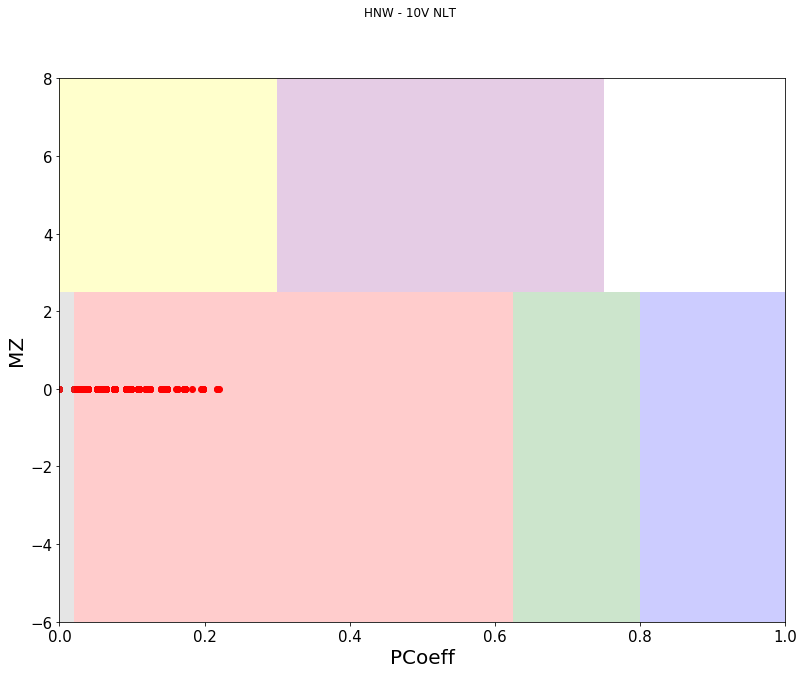

In [769]:
#NLT DRAW ALL NETWORKS ON SAME SPACE
from edamame.analysis.misc import draw_zp_space
fig=plt.figure(figsize=(13,10))
fig.suptitle(str(networkType)+ ' - ' +str(onAmp[chosenVolt])+'V NLT')

fig.subplots_adjust(hspace=.6)
fig.subplots_adjust(wspace=.6)
ax=plt.gca()
draw_zp_space(ax = ax)

for j in tqdm(range(len(pcoeffMinNLT))):
    idx = j  
    line = ax.scatter(pcoeffMinNLT[j],mzMinNLT[j],c='b')
#     ax[i].set_title('Max Accuracy ',fontsize=30)
ax.set_xlabel('PCoeff',fontsize=20)#,labelpad=5)
ax.set_ylabel('MZ',fontsize=20)#,labelpad=5)
# plt.text(0.7,6,'SW:'+"{0:.2f}".format(dfAllMC[:50].SmallWorldness.values[j]),fontsize=15)
# plt.text(0.7,8,'MC:'+"{0:.2f}".format(dfAllMC[:50].MemoryCapacity.values[j]),fontsize=15)
ax.set_ylim(-6, 6)
ax.set_xlim(0,1)
ax.tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
ax.tick_params(axis='both', which='minor', labelsize=15)


for j in tqdm(range(len(pcoeffMaxNLT))):
    idx = j  
    line = ax.scatter(pcoeffMaxNLT[j],mzMaxNLT[j],c='r')
#     ax[i].set_title('Max Accuracy ',fontsize=30)
ax.set_xlabel('PCoeff',fontsize=20)#,labelpad=5)
ax.set_ylabel('MZ',fontsize=20)#,labelpad=5)
# plt.text(0.7,6,'SW:'+"{0:.2f}".format(dfAllMC[-50:].SmallWorldness.values[j]),fontsize=15)
# plt.text(0.7,8,'MC:'+"{0:.2f}".format(dfAllMC[-50:].MemoryCapacity.values[j]),fontsize=15)
ax.set_ylim(-6, 8)
ax.set_xlim(0,1)

ax.tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
ax.tick_params(axis='both', which='minor', labelsize=15)
# plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/'+networkType+' GuimeraAmeral ALL Networks Min 0p7 Max 0p8 - VSweep 0p75V NLT',dpi=300)  
plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/'+networkType+' GuimeraAmeral 50MinMax Networks - VSweep '+voltNames[chosenVolt]+'V NLT',dpi=300) 


Exception ignored in: <function tqdm.__del__ at 0x7f26fa48f8c8>
Traceback (most recent call last):
  File "/suphys/aloe8475/anaconda3/lib/python3.7/site-packages/tqdm/std.py", line 1086, in __del__
    def __del__(self):
KeyboardInterrupt


KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f26fd184598> (for post_execute):


KeyboardInterrupt: 

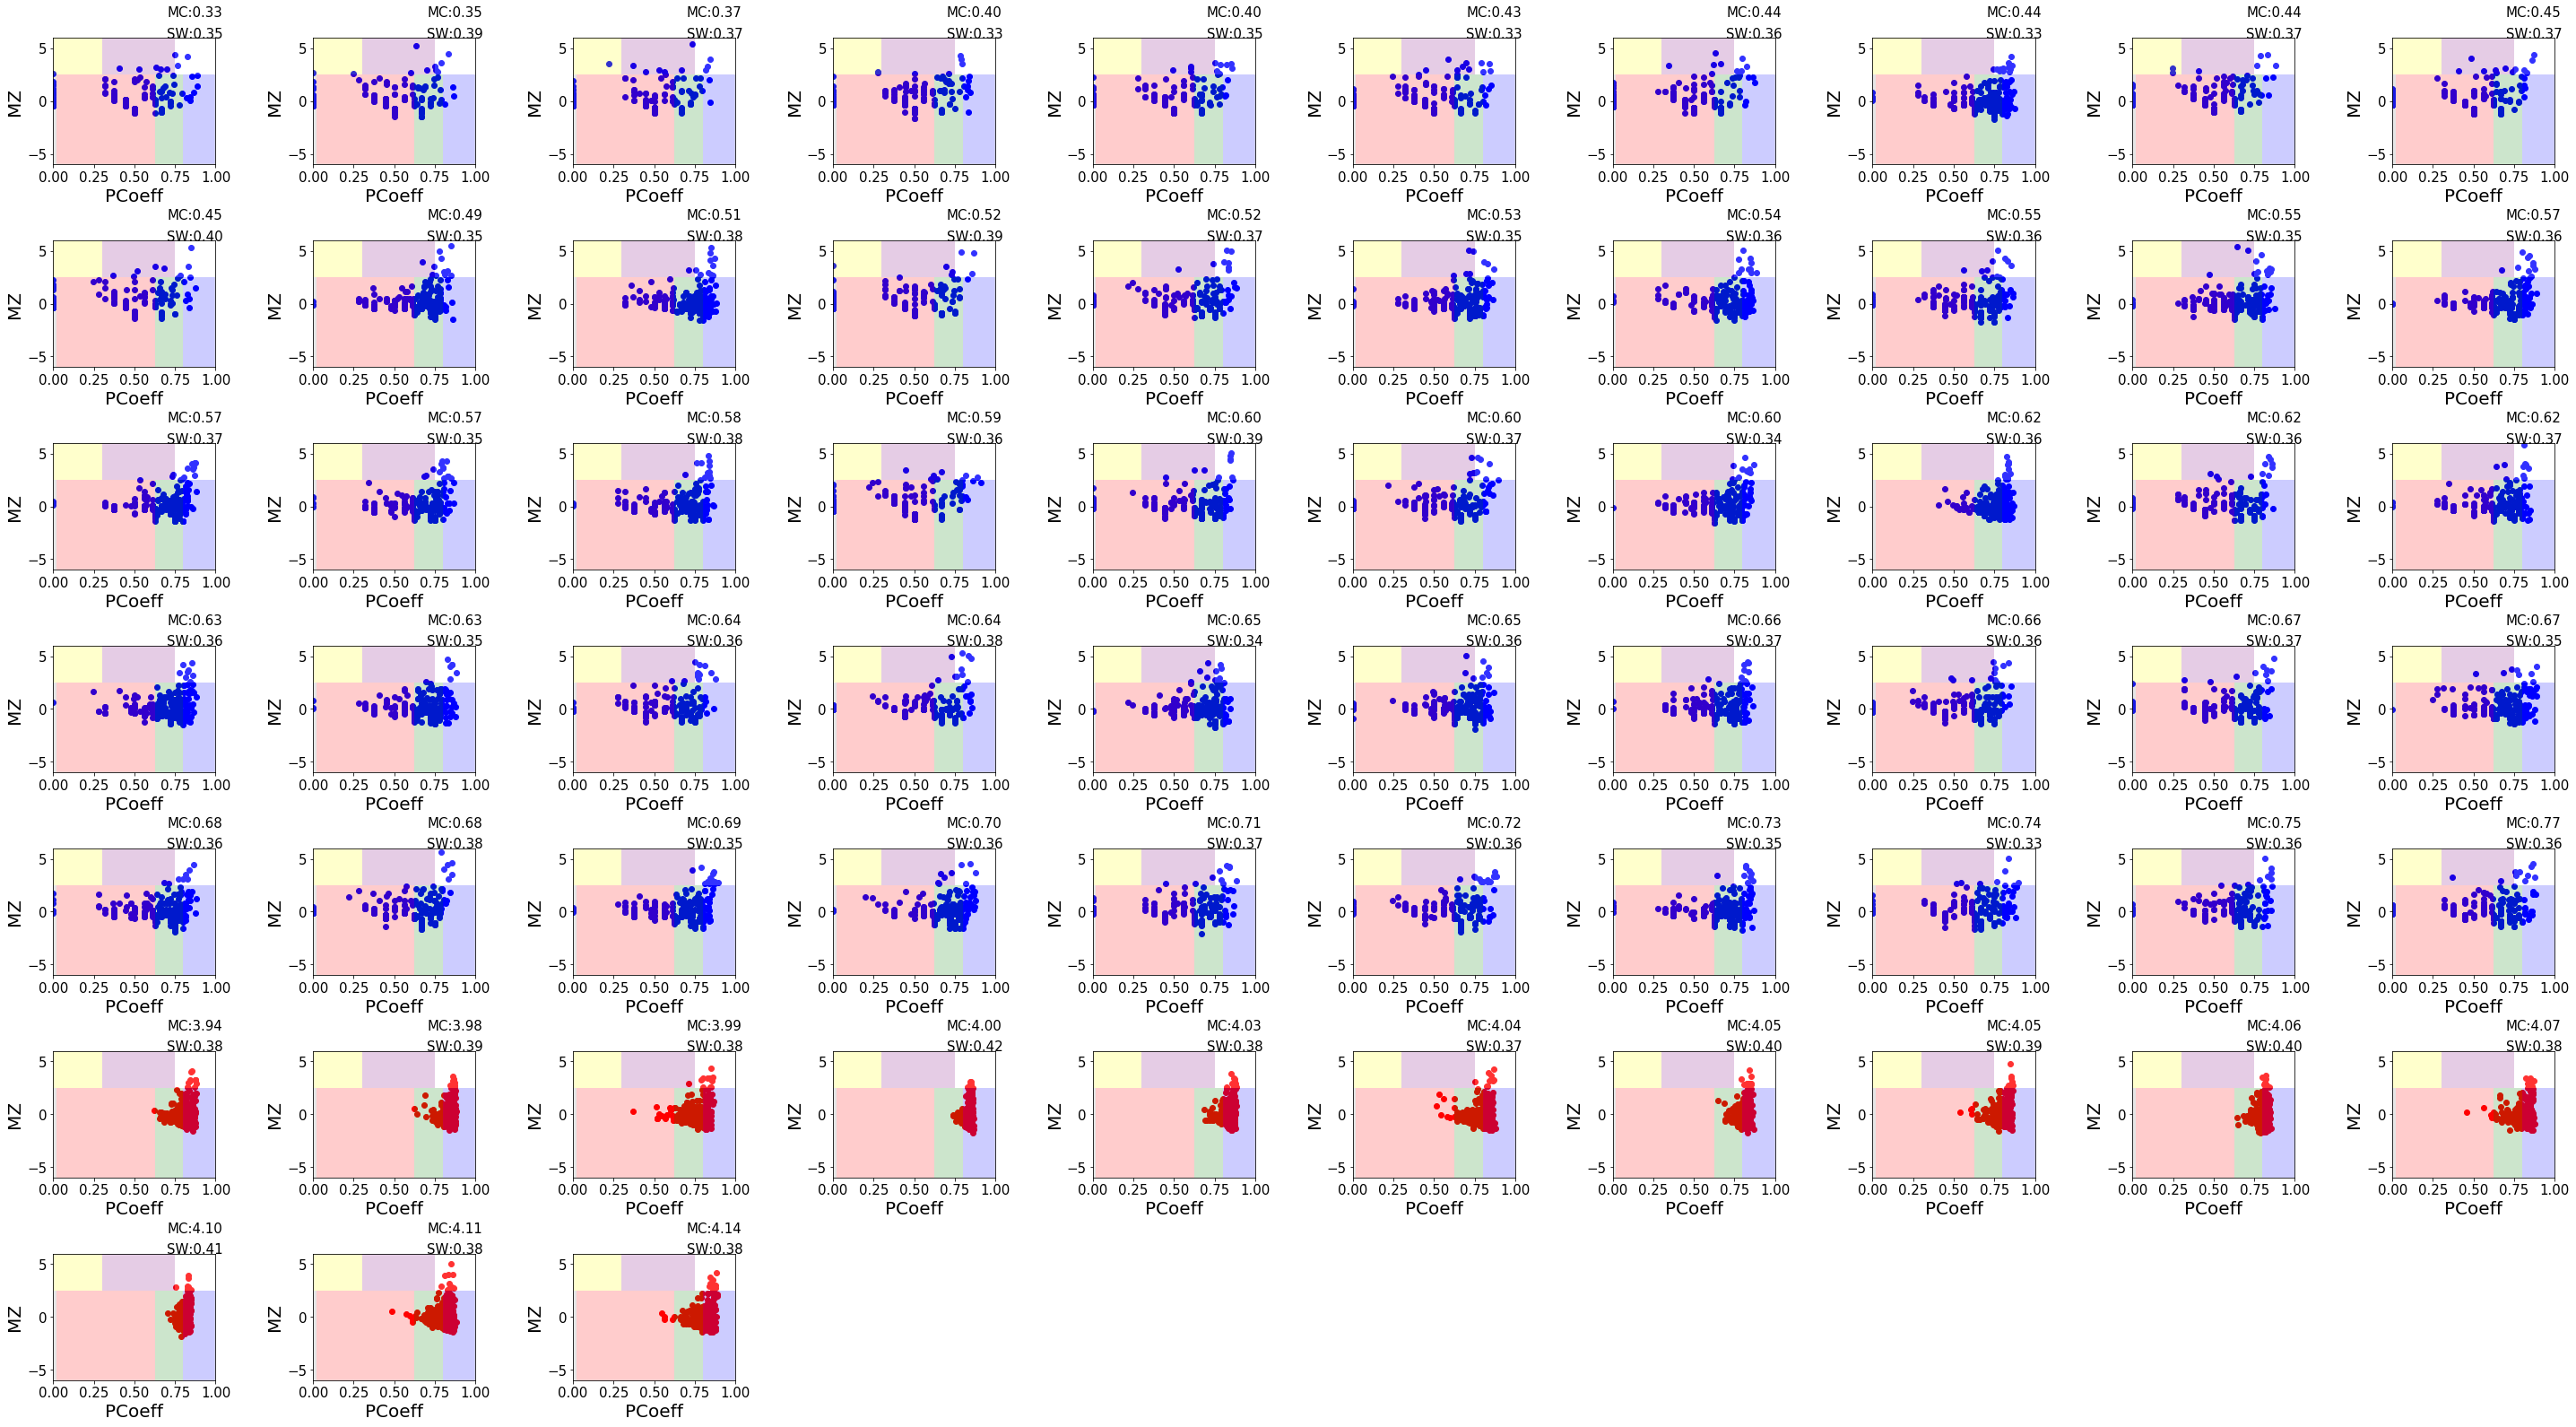

In [192]:
#Memory Capacity
from edamame.analysis.misc import draw_zp_space
fig=plt.figure(figsize=(50,40))
fig.subplots_adjust(hspace=.6)
fig.subplots_adjust(wspace=.6)
ax=[None]*100
for i in range(len(ax)):
    if i < 50:
        ax[i]=plt.subplot(10,10, i+1)
        draw_zp_space(ax = ax[i])
        line = ax[i].scatter(pcoeffMinMC[i],mzMinMC[i],c='b')
    #     ax[i].set_title('Max Accuracy ',fontsize=30)
        ax[i].set_xlabel('PCoeff',fontsize=20)#,labelpad=5)
        ax[i].set_ylabel('MZ',fontsize=20)#,labelpad=5)
        plt.text(0.7,6,'SW:'+"{0:.2f}".format(dfAllMC[:50].SmallWorldness.values[i]),fontsize=15)
        plt.text(0.7,8,'MC:'+"{0:.2f}".format(dfAllMC[:50].MemoryCapacity.values[i]),fontsize=15)
        ax[i].set_ylim(-6, 6)
        ax[i].set_xlim(0,1)
        
        ax[i].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
        ax[i].tick_params(axis='both', which='minor', labelsize=15)

    else:
        idx=i-50
#PCOEFF MZ MIN ACCURACY
        ax[i]=plt.subplot(10, 10, i+1)
        draw_zp_space(ax = ax[i])
        line = ax[i].scatter(pcoeffMaxMC[idx],mzMaxMC[idx],c='r')
    #     ax[i].set_title('Max Accuracy ',fontsize=30)
        ax[i].set_xlabel('PCoeff',fontsize=20)#,labelpad=5)
        ax[i].set_ylabel('MZ',fontsize=20)#,labelpad=5)
        plt.text(0.7,6,'SW:'+"{0:.2f}".format(dfAllMC[-50:].SmallWorldness.values[idx]),fontsize=15)
        plt.text(0.7,8,'MC:'+"{0:.2f}".format(dfAllMC[-50:].MemoryCapacity.values[idx]),fontsize=15)
        ax[i].set_ylim(-6, 6)
        ax[i].set_xlim(0,1)
        
        ax[i].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
        ax[i].tick_params(axis='both', which='minor', labelsize=15)

# plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/'+networkType+' GuimeraAmeral 50MinMax Networks - VSweep MC',dpi=300) 
# plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/'+networkType+' GuimeraAmeral (Min < 0p7 Max > 0p8) Networks - VSweep MC',dpi=300)    

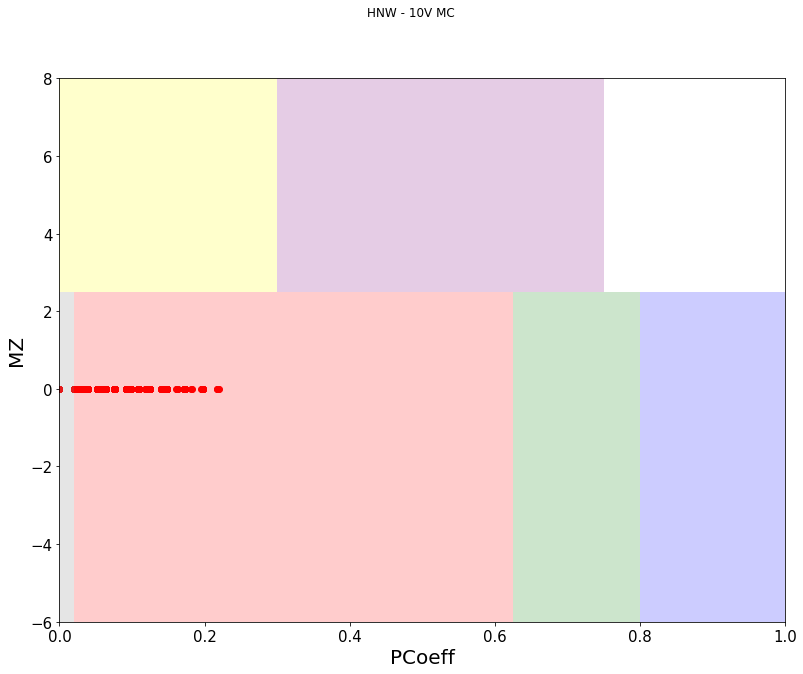

In [770]:
#Memory Capacity DRAW ALL NETWORKS ON SAME SPACE
from edamame.analysis.misc import draw_zp_space
fig=plt.figure(figsize=(13,10))
fig.suptitle(str(networkType)+ ' - ' +str(onAmp[chosenVolt])+'V MC')
fig.subplots_adjust(hspace=.6)
fig.subplots_adjust(wspace=.6)
ax=plt.gca()
draw_zp_space(ax = ax)

for j in tqdm(range(len(pcoeffMinMC))):
    idx = j  
    line = ax.scatter(pcoeffMinMC[j],mzMinMC[j],c='b')
#     ax[i].set_title('Max Accuracy ',fontsize=30)
ax.set_xlabel('PCoeff',fontsize=20)#,labelpad=5)
ax.set_ylabel('MZ',fontsize=20)#,labelpad=5)
# plt.text(0.7,6,'SW:'+"{0:.2f}".format(dfAllMC[:50].SmallWorldness.values[j]),fontsize=15)
# plt.text(0.7,8,'MC:'+"{0:.2f}".format(dfAllMC[:50].MemoryCapacity.values[j]),fontsize=15)
ax.set_ylim(-6, 6)
ax.set_xlim(0,1)
ax.tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
ax.tick_params(axis='both', which='minor', labelsize=15)


for j in tqdm(range(len(pcoeffMaxMC))):
    idx = j  
    line = ax.scatter(pcoeffMaxMC[j],mzMaxMC[j],c='r')
#     ax[i].set_title('Max Accuracy ',fontsize=30)
ax.set_xlabel('PCoeff',fontsize=20)#,labelpad=5)
ax.set_ylabel('MZ',fontsize=20)#,labelpad=5)
# plt.text(0.7,6,'SW:'+"{0:.2f}".format(dfAllMC[-50:].SmallWorldness.values[j]),fontsize=15)
# plt.text(0.7,8,'MC:'+"{0:.2f}".format(dfAllMC[-50:].MemoryCapacity.values[j]),fontsize=15)
ax.set_ylim(-6, 8)
ax.set_xlim(0,1)
ax.tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
ax.tick_params(axis='both', which='minor', labelsize=15)


plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/'+networkType+' GuimeraAmeral 50MinMax Networks - VSweep '+voltNames[chosenVolt]+'V MC',dpi=300) 


In [362]:
tempMax=[]
tempMin=[]
tempMZMax=[]
tempMZMin=[]
tempCentralityMax=[]
tempCentralityMin=[]
tempDegCentralityMax=[]
tempDegCentralityMin=[]
tempDegMax=[]
tempDegMin=[]

for i in range(len(pcoeffMaxNLT)):
    tempMax.append(pcoeffMaxNLT[i])
    tempMin.append(pcoeffMinNLT[i])
    tempMZMax.append(mzMaxNLT[i])
    tempMZMin.append(mzMinNLT[i])
    tempCentralityMax.append(centralityMaxNLT[i])
    tempCentralityMin.append(centralityMinNLT[i])
    tempDegCentralityMax.append(degCentralityMaxNLT[i])
    tempDegCentralityMin.append(degCentralityMinNLT[i])
    tempDegMax.append(degMaxNLT[i])
    tempDegMin.append(degMinNLT[i])
    
tempMZMax=np.hstack(tempMZMax)
tempMZMin=np.hstack(tempMZMin)
tempMax=np.hstack(tempMax)
tempMin=np.hstack(tempMin)
tempCentralityMin=np.hstack(tempCentralityMin)
tempCentralityMax=np.hstack(tempCentralityMax)
tempDegMin=np.hstack(tempDegMin)
tempDegMax=np.hstack(tempDegMax)
tempDegCentralityMin=np.hstack(tempDegCentralityMin)
tempDegCentralityMax=np.hstack(tempDegCentralityMax)

tempMaxMC=[]
tempMinMC=[]
tempMZMaxMC=[]
tempMZMinMC=[]
tempCentralityMaxMC=[]
tempCentralityMinMC=[]
tempDegCentralityMaxMC=[]
tempDegCentralityMinMC=[]
tempDegMaxMC=[]
tempDegMinMC=[]

for i in range(len(pcoeffMaxMC)):
    tempMaxMC.append(pcoeffMaxMC[i])
    tempMinMC.append(pcoeffMinMC[i])
    tempMZMaxMC.append(mzMaxMC[i])
    tempMZMinMC.append(mzMinMC[i])
    tempCentralityMaxMC.append(centralityMaxMC[i])
    tempCentralityMinMC.append(centralityMinMC[i])
    tempDegCentralityMaxMC.append(degCentralityMaxMC[i])
    tempDegCentralityMinMC.append(degCentralityMinMC[i])
    tempDegMaxMC.append(degMaxMC[i])
    tempDegMinMC.append(degMinMC[i])
    
    
tempMZMaxMC=np.hstack(tempMZMaxMC)
tempMZMinMC=np.hstack(tempMZMinMC)
tempMaxMC=np.hstack(tempMaxMC)
tempMinMC=np.hstack(tempMinMC)
tempCentralityMinMC=np.hstack(tempCentralityMinMC)
tempCentralityMaxMC=np.hstack(tempCentralityMaxMC)
tempDegCentralityMinMC=np.hstack(tempDegCentralityMinMC)
tempDegCentralityMaxMC=np.hstack(tempDegCentralityMaxMC)
tempDegMinMC=np.hstack(tempDegMinMC)
tempDegMaxMC=np.hstack(tempDegMaxMC)




In [ ]:
pcmz={'MZ':[tempMZMaxMC,tempMZMinMC,tempMZMax,tempMZMin],'PC':[tempMaxMC,tempMinMC,tempMax,tempMin]}
savemat('PCoeffMZ_NWN_VSweep_NLT_MC.mat',pcmz)

### HISTOGRAMS

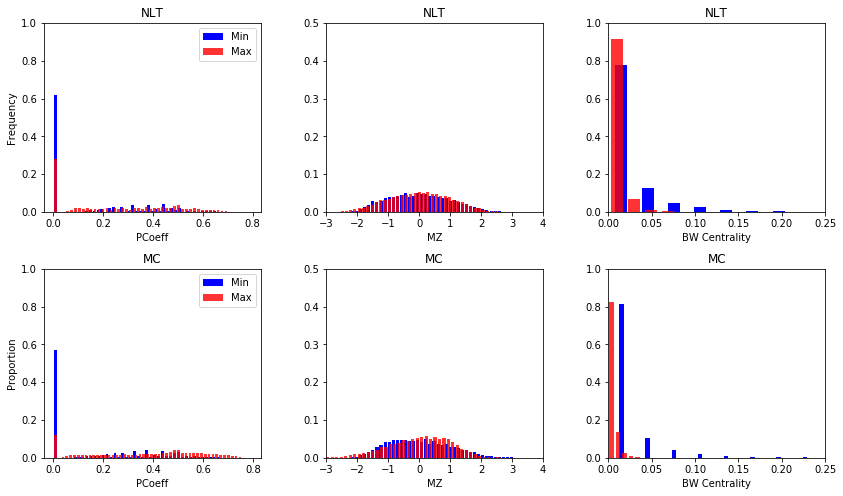

In [366]:
#HISTOGRAMS COMPARING ALL PCOEFF WITH ALL MZ TOP - BOTTOM 
# NONLINEAR TRANSFORMATION
# PCOEFF
fig=plt.figure(figsize=(14,8))
ax=[None]*6
fig.subplots_adjust(wspace=.3)
fig.subplots_adjust(hspace=.3)

ax[0]=fig.add_subplot(231)

plt.title('NLT')
hist, bins=np.histogram(tempMax,50)
histMin, binsMin=np.histogram(tempMin,50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
widthMin=0.7 * (binsMin[1] - binsMin[0])
centerMin=(binsMin[:-1] + binsMin[1:]) / 2
plt.bar(centerMin, histMin/len(tempMin), align='center', width=width,label='Min',color='b')
plt.bar(center, hist/len(tempMax), align='center', width=width,label='Max',color='r',alpha=0.8)
# plt.xlim([0.01,0.8])
plt.ylim([0,1])

# plt.xlim([0.01,0.8])
# plt.ylim([0,700])
plt.xlabel('PCoeff')
plt.ylabel('Frequency')
plt.legend()

# NONLINEAR TRANSFORMATION
# MZ
ax[1]=fig.add_subplot(232)
plt.title('NLT')
hist, bins=np.histogram(tempMZMax,50)
histMin, binsMin=np.histogram(tempMZMin,50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
widthMin=0.7 * (binsMin[1] - binsMin[0])
centerMin=(binsMin[:-1] + binsMin[1:]) / 2
plt.bar(centerMin, histMin/len(tempMZMin), align='center', width=width,label='Min',color='b')
plt.bar(center, hist/len(tempMZMax), align='center', width=width,label='Max',color='r',alpha=0.8)
plt.xlabel('MZ')
plt.ylim([0,0.5])
plt.xlim([-3,4])

#BW Centrality:
ax[2]=fig.add_subplot(233)
plt.title('NLT')
hist, bins=np.histogram(tempCentralityMax,15)
histMin, binsMin=np.histogram(tempCentralityMin,15)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
widthMin=0.7 * (binsMin[1] - binsMin[0])
centerMin=(binsMin[:-1] + binsMin[1:]) / 2
plt.bar(centerMin, histMin/len(tempCentralityMin), align='center', width=width,label='Min',color='b')
plt.bar(center, hist/len(tempCentralityMax), align='center', width=width,label='Max',color='r',alpha=0.8)
plt.xlabel('BW Centrality')
plt.ylim([0,1])
plt.xlim([0,0.25])


#MEMORY CAPACITY
#PCOEFF
ax[3]=fig.add_subplot(234)
plt.title('MC')
hist, bins=np.histogram(tempMaxMC,50)
histMin, binsMin=np.histogram(tempMinMC,50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
widthMin=0.7 * (binsMin[1] - binsMin[0])
centerMin=(binsMin[:-1] + binsMin[1:]) / 2
plt.bar(centerMin, histMin/len(tempMinMC), align='center', width=width,label='Min',color='b')
plt.bar(center, hist/len(tempMaxMC), align='center', width=width,label='Max',color='r',alpha=0.8)
# plt.xlim([0.01,0.8])
plt.ylim([0,1])

# plt.xlim([0.01,0.8])
# plt.ylim([0,700])
plt.xlabel('PCoeff')
plt.ylabel('Proportion')
plt.legend()

# MEMORY CAPACITY
# MZ
ax[4]=fig.add_subplot(235)
plt.title('MC')
hist, bins=np.histogram(tempMZMaxMC,50)
histMin, binsMin=np.histogram(tempMZMinMC,50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
widthMin=0.7 * (binsMin[1] - binsMin[0])
centerMin=(binsMin[:-1] + binsMin[1:]) / 2
plt.bar(centerMin, histMin/len(tempMZMinMC), align='center', width=width,label='Min',color='b')
plt.bar(center, hist/len(tempMZMaxMC), align='center', width=width,label='Max',color='r',alpha=0.8)
plt.xlabel('MZ')
plt.ylim([0,0.5])
plt.xlim([-3,4])
# BW Centrality
ax[5]=fig.add_subplot(236)
plt.title('MC')
hist, bins=np.histogram(tempCentralityMaxMC,15)
histMin, binsMin=np.histogram(tempCentralityMinMC,15)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
widthMin=0.7 * (binsMin[1] - binsMin[0])
centerMin=(binsMin[:-1] + binsMin[1:]) / 2
plt.bar(centerMin, histMin/len(tempCentralityMinMC), align='center', width=width,label='Min',color='b')
plt.bar(center, hist/len(tempCentralityMaxMC), align='center', width=width,label='Max',color='r',alpha=0.8)
plt.xlabel('BW Centrality')
plt.ylim([0,1])
plt.xlim([0,0.25])

plt.savefig(r'/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/'+networkType+' PCoeff MZ BWCentrality Histograms 50MinMax - VSweep '+voltNames[chosenVolt]+'v NLT + MC',dpi=300)    

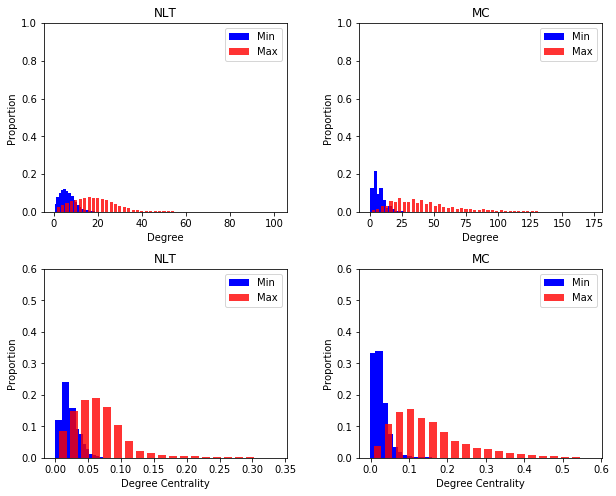

In [367]:
#Degree Distribution:
# NONLINEAR TRANSFORMATION
fig=plt.figure(figsize=(10,8))
ax=[None]*4
fig.subplots_adjust(wspace=.3)
fig.subplots_adjust(hspace=.3)

ax[0]=fig.add_subplot(221)

plt.title('NLT')
hist, bins=np.histogram(tempDegMax,50)
histMin, binsMin=np.histogram(tempDegMin,50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
widthMin=0.7 * (binsMin[1] - binsMin[0])
centerMin=(binsMin[:-1] + binsMin[1:]) / 2
plt.bar(centerMin, histMin/len(tempDegMin), align='center', width=width,label='Min',color='b')
plt.bar(center, hist/len(tempDegMax), align='center', width=width,label='Max',color='r',alpha=0.8)
# plt.xlim([0.01,0.8])
plt.ylim([0,1])

# plt.xlim([0.01,0.8])
# plt.ylim([0,700])
plt.xlabel('Degree')
plt.ylabel('Proportion')
plt.legend()


#MEMORY CAPACITY
#PCOEFF
ax[1]=fig.add_subplot(222)
plt.title('MC')
hist, bins=np.histogram(tempDegMaxMC,50)
histMin, binsMin=np.histogram(tempDegMinMC,50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
widthMin=0.7 * (binsMin[1] - binsMin[0])
centerMin=(binsMin[:-1] + binsMin[1:]) / 2
plt.bar(centerMin, histMin/len(tempDegMinMC), align='center', width=width,label='Min',color='b')
plt.bar(center, hist/len(tempDegMaxMC), align='center', width=width,label='Max',color='r',alpha=0.8)
# plt.xlim([0.01,0.8])
plt.ylim([0,1])

# plt.xlim([0.01,0.8])
# plt.ylim([0,700])
plt.xlabel('Degree')
plt.ylabel('Proportion')
plt.legend()


ax[2]=fig.add_subplot(223)

plt.title('NLT')
hist, bins=np.histogram(tempDegCentralityMax,20)
histMin, binsMin=np.histogram(tempDegCentralityMin,20)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
widthMin=0.7 * (binsMin[1] - binsMin[0])
centerMin=(binsMin[:-1] + binsMin[1:]) / 2
plt.bar(centerMin, histMin/len(tempDegCentralityMin), align='center', width=width,label='Min',color='b')
plt.bar(center, hist/len(tempDegCentralityMax), align='center', width=width,label='Max',color='r',alpha=0.8)
# plt.xlim([0.01,0.8])
plt.ylim([0,0.6])

# plt.xlim([0.01,0.8])
# plt.ylim([0,700])
plt.xlabel('Degree Centrality' )
plt.ylabel('Proportion')
plt.legend()


#MEMORY CAPACITY
#PCOEFF
ax[3]=fig.add_subplot(224)
plt.title('MC')
hist, bins=np.histogram(tempDegCentralityMaxMC,20)
histMin, binsMin=np.histogram(tempDegCentralityMinMC,20)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
widthMin=0.7 * (binsMin[1] - binsMin[0])
centerMin=(binsMin[:-1] + binsMin[1:]) / 2
plt.bar(centerMin, histMin/len(tempDegCentralityMinMC), align='center', width=width,label='Min',color='b')
plt.bar(center, hist/len(tempDegCentralityMaxMC), align='center', width=width,label='Max',color='r',alpha=0.8)
# plt.xlim([0.01,0.8])
plt.ylim([0,0.6])

# plt.xlim([0.01,0.8])
# plt.ylim([0,700])
plt.xlabel('Degree Centrality')
plt.ylabel('Proportion')
plt.legend()

plt.savefig(r'/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/'+networkType+' Degree + Degree Centrality Distribution Histograms  Histograms 50MinMax - VSweep '+voltNames[chosenVolt]+'v NLT + MC',dpi=300)    


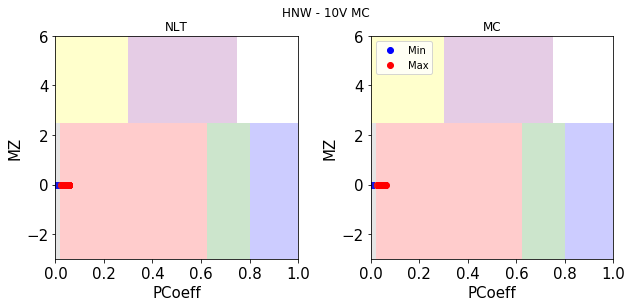

In [772]:
#Mean PCOEFF and MZ for bottom NLT and top NLT:
fig=plt.figure(figsize=(10,4.1))
fig.suptitle(str(networkType)+ ' - ' +str(onAmp[chosenVolt])+'V MC')
ax=[None]*2
fig.subplots_adjust(wspace=.3)
fig.subplots_adjust(hspace=.3)
ax[0]=fig.add_subplot(121)
draw_zp_space(ax = ax[0])
plt.title('NLT')
line = ax[0].scatter(avgpcoeffMin,avgmzMin,c='b')
ax[0].set_ylim(-3, 6)
ax[0].set_xlim(0,1)
ax[0].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
ax[0].tick_params(axis='both', which='minor', labelsize=15)
line = ax[0].scatter(avgpcoeffMax,avgmzMax,c='r')
ax[0].set_ylim(-3, 6)
ax[0].set_xlim(0,1)
ax[0].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
ax[0].tick_params(axis='both', which='minor', labelsize=15)
ax[0].set_xlabel('PCoeff',fontsize=15)#,labelpad=5)
ax[0].set_ylabel('MZ',fontsize=15)#,labelpad=5)
# plt.legend()

#Mean PCOEFF and MZ for bottom NLT and top MC:
ax[1]=fig.add_subplot(122)
plt.title('MC')
draw_zp_space(ax = ax[1])
line2 = ax[1].scatter(avgpcoeffMinMC,avgmzMinMC,c='b',label='Min')
ax[1].set_ylim(-3, 6)
ax[1].set_xlim(0,1)
ax[1].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
ax[1].tick_params(axis='both', which='minor', labelsize=15)
line = ax[1].scatter(avgpcoeffMaxMC,avgmzMaxMC,c='r',label='Max')
ax[1].set_ylim(-3, 6)
ax[1].set_xlim(0,1)
ax[1].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
ax[1].tick_params(axis='both', which='minor', labelsize=15)
ax[1].set_xlabel('PCoeff',fontsize=15)#,labelpad=5)
ax[1].set_ylabel('MZ',fontsize=15)#,labelpad=5)
plt.legend()

#         ax[i].fill(x, y, "b")   
plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/'+networkType+' GuimeraAmeral - 50MinMax Networks Avg - VSweep '+voltNames[chosenVolt]+'V NLT + MC',dpi=300)    

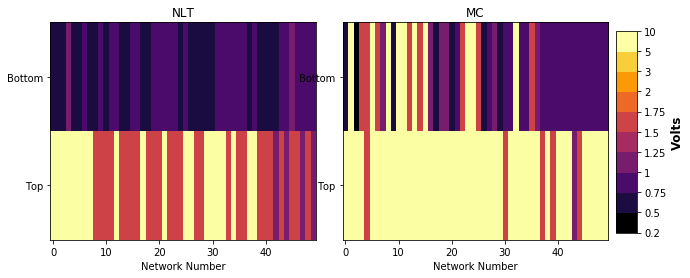

In [373]:
# plt.figure()
# hist, bins=np.histogram(voltMaxMC,50)
# histMin, binsMin=np.histogram(voltMinNLT,50)
# width = 0.7 * (bins[1] - bins[0])
# center = (bins[:-1] + bins[1:]) / 2
# widthMin=0.7 * (binsMin[1] - binsMin[0])
# centerMin=(binsMin[:-1] + binsMin[1:]) / 2
# plt.bar(centerMin, histMin/len(voltMinNLT), align='center', width=width,label='Min',color='b')
# plt.bar(center, hist/len(voltMaxMC), align='center', width=width,label='Max',color='r',alpha=0.8)

fig,axes = plt.subplots(1,2,figsize=(10,4))
fig.subplots_adjust(wspace=0.1)
i=0

cmap = plt.cm.inferno  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be black
cmaplist[0] = (0, 0, 0, 1.0)

# create the new map
cmap = plt.cm.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.array(range(len(onAmp)))
norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)


for ax in axes:
    if i == 0:
        ax.set_title('NLT')
        im=ax.imshow([voltMinNLT,voltMaxNLT],origin='lower',cmap=cmap,norm=norm)
        ax.set_aspect('auto') 
        ax.set_yticks([0,1])
        ax.set_yticklabels({'Bottom','Top'})
        ax.set_xlabel('Network Number')

    else:
        ax.set_title('MC')
        im2=ax.imshow([voltMinMC,voltMaxMC],origin='lower',cmap=cmap,norm=norm)
        ax.set_aspect('auto') 
        ax.set_yticks([0,1])
        ax.set_yticklabels({'Bottom','Top'})
        ax.set_xlabel('Network Number')
        cb=fig.colorbar(im2,cmap=cmap, norm=norm,ticks=bounds, boundaries=bounds,cax = fig.add_axes([0.91, 0.15, 0.03, 0.7]))
        cb.set_label(label='Volts', size='large', weight='bold')
        cb.ax.set_yticklabels(onAmp)
    i=i+1
# plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/BA VSweep Voltages 50MaxMin NLT + MC',dpi=300)    

---

### Visualise Sections of Good Networks:

Create a loop that goes through a set of good networks
and give them 
a 1 if they have  PC = 0 and MZ < 0
a 2 if PC >.1 but <.3
and a 3 if PC > .5

and then plot any nodes that have those characteristics in different colours
on, say, 10-20 of the top networks with all other nodes grey

In [891]:
PCtop=[];PC_MCtop=[];PCbottom=[];PC_MCbottom=[]
MZtop=[];MZ_MCtop=[];MZbottom=[];MZ_MCbottom=[]
BWtop=[];BW_MCtop=[];BWbottom=[];BW_MCbottom=[]
colorstop=[];colorsMCtop=[];colorsbottom=[];colorsMCbottom=[]
DEGtop=[];DEG_MCtop=[];DEGbottom=[];DEG_MCbottom=[]
COMMtop=[];COMM_MCtop=[];COMMbottom=[];COMM_MCbottom=[]

PCtop=pcoeffMaxNLT[-15:]
PC_MCtop=pcoeffMaxMC[-15:]
MZtop=mzMaxNLT[-15:]
MZ_MCtop=mzMaxMC[-15:]
BWtop=centralityMaxNLT[-15:]
BW_MCtop=centralityMaxMC[-15:]
DEGtop=degMaxNLT[-15:]
DEG_MCtop=degMaxMC[-15:]
idxNLTtop=idxMaxNLT[-15:]
idxMCtop=idxMaxMC[-15:]
    
PCbottom=pcoeffMinNLT[:15]
PC_MCbottom=pcoeffMinMC[:15]
MZbottom=mzMinNLT[:15]
MZ_MCbottom=mzMinMC[:15]
idxNLTbottom=idxMinNLT[:15]
idxMCbottom=idxMinMC[:15]
DEGbottom=degMinNLT[:15]
DEG_MCbottom=degMinMC[:15]
BWbottom=centralityMinNLT[:15]
BW_MCbottom=centralityMinMC[:15]
    
idxNLT_Bottom=idxMinNLT[:15]
idxMC_Bottom=idxMinMC[:15]
idxNLT_Top=idxMaxNLT[-15:]
idxMC_Top=idxMaxMC[-15:]

In [892]:
colorsMCtop=[[None]*300 for i in range(len(PC_MCtop))]
count=0
for i in range(len(PC_MCtop)):
    count2=0
    for j in range(len(PC_MCtop[i])):
        if PC_MCtop[i][j] == 0:
            colorsMCtop[count][count2]=1
            count2=count2+1
        elif PC_MCtop[i][j] >0.1 and PC_MCtop[i][j] <0.3:
            colorsMCtop[count][count2]=2
            count2=count2+1
        elif PC_MCtop[i][j] > 0.5:
            colorsMCtop[count][count2]=3
            count2=count2+1
        else:
            colorsMCtop[count][count2]=0
            count2=count2+1
    count = count+1
    
colorsMCbottom=[[None]*300 for i in range(len(PC_MCbottom))]
count=0
for i in range(len(PC_MCbottom)):
    count2=0
    for j in range(len(PC_MCbottom[i])):
        if PC_MCbottom[i][j] == 0:
            colorsMCbottom[count][count2]=1
            count2=count2+1
        elif PC_MCbottom[i][j] >0.1 and PC_MCbottom[i][j] <0.3:
            colorsMCbottom[count][count2]=2
            count2=count2+1
        elif PC_MCbottom[i][j] > 0.5:
            colorsMCbottom[count][count2]=3
            count2=count2+1
        else:
            colorsMCbottom[count][count2]=0
            count2=count2+1
    count = count+1

In [893]:
colorstop=[[None]*300 for i in range(len(PCtop))]
count=0
for i in range(len(PCtop)):
    count2=0
    for j in range(len(PCtop[i])):
        if PCtop[i][j] == 0: 
            colorstop[count][count2]=1
            count2=count2+1
        elif PCtop[i][j] >0.1 and PCtop[i][j] <0.3:
            colorstop[count][count2]=2
            count2=count2+1
        elif PCtop[i][j] > 0.5:
            colorstop[count][count2]=3
            count2=count2+1
        else:
            colorstop[count][count2]=0
            count2=count2+1
    count = count+1

colorsbottom=[[None]*300 for i in range(len(PCbottom))]
count=0
for i in range(len(PCbottom)):
    count2=0
    for j in range(len(PCbottom[i])):
        if PCbottom[i][j] == 0: 
            colorsbottom[count][count2]=1
            count2=count2+1
        elif PCbottom[i][j] >0.1 and PCbottom[i][j] <0.3:
            colorsbottom[count][count2]=2
            count2=count2+1
        elif PCbottom[i][j] > 0.5:
            colorsbottom[count][count2]=3
            count2=count2+1
        else:
            colorsbottom[count][count2]=0
            count2=count2+1
    count = count+1

In [894]:
for i in range(len(colorstop)):
    for j in range(len(colorstop[i])):
        if colorstop[i][j]==0:
            colorstop[i][j]='black' 
        elif colorstop[i][j]==1:
            colorstop[i][j]='blue' #PCoeff = 0
        elif colorstop[i][j]==2:
            colorstop[i][j]='yellow' # 0.1 < PCoeff < 0.3 
        elif colorstop[i][j]==3:
            colorstop[i][j]='red' #Pcoeff > 0.5

    colorstop[i]=list(filter(None,colorstop[i]))

for i in range(len(colorsbottom)):
    for j in range(len(colorsbottom[i])):
        if colorsbottom[i][j]==0:
            colorsbottom[i][j]='black' 
        elif colorsbottom[i][j]==1:
            colorsbottom[i][j]='blue' #PCoeff = 0
        elif colorsbottom[i][j]==2:
            colorsbottom[i][j]='yellow' # 0.1 < PCoeff < 0.3 
        elif colorsbottom[i][j]==3:
            colorsbottom[i][j]='red' #Pcoeff > 0.5

    colorsbottom[i]=list(filter(None,colorsbottom[i]))

In [895]:
for i in range(len(colorsMCtop)):
    for j in range(len(colorsMCtop[i])):
        if colorsMCtop[i][j]==0:
            colorsMCtop[i][j]='black'
        elif colorsMCtop[i][j]==1:
            colorsMCtop[i][j]='blue'
        elif colorsMCtop[i][j]==2:
            colorsMCtop[i][j]='yellow'
        elif colorsMCtop[i][j]==3:
            colorsMCtop[i][j]='red'

    colorsMCtop[i]=list(filter(None,colorsMCtop[i]))

for i in range(len(colorsMCbottom)):
    for j in range(len(colorsMCbottom[i])):
        if colorsMCbottom[i][j]==0:
            colorsMCbottom[i][j]='black'
        elif colorsMCbottom[i][j]==1:
            colorsMCbottom[i][j]='blue'
        elif colorsMCbottom[i][j]==2:
            colorsMCbottom[i][j]='yellow'
        elif colorsMCbottom[i][j]==3:
            colorsMCbottom[i][j]='red'

    colorsMCbottom[i]=list(filter(None,colorsMCbottom[i]))

In [896]:
#MC
fig = plt.figure(figsize=(20,10))
fig.suptitle('Memory Capacity - ' +str(onAmp[chosenVolt]))
# fig.subplots_adjust(hspace=)
# fig.subplots_adjust(wspace=.2)
ax=[None]*len(colorsMCtop)
for i in range(len(colorsMCtop)):
    ax[i]=fig.add_subplot(3,5,i+1)
    ax[i].set_ylim([-1.2,1.2])
    ax[i].set_xlim([-1.2,1.2])
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
    ax[i].set_yticks([])
    ax[i].set_xticks([])
    ax[i].set_frame_on(False)
    pos=nx.kamada_kawai_layout(graphs[idxMCtop[i]])
    nx.draw_networkx_nodes(graphs[idxMCtop[i]],pos,node_color=colorsMCtop[i],node_size=20)
    nx.draw_networkx_edges(graphs[idxMCtop[i]],pos,alpha=0.1)
    plt.text(0.75,0.9,'MC:'+"{0:.2f}".format(dfAllMC[-15:].MemoryCapacity.values[i]),fontsize=10)
    plt.text(0.75,0.7,'NLT:'+"{0:.2f}".format(dfAllMC[-15:].NonlinearTransform.values[i]),fontsize=10)

plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/'+networkType+' Top 15 Networks - VSweep '+voltNames[chosenVolt]+'V MC',dpi=300)

fig = plt.figure(figsize=(20,10))
fig.suptitle('Memory Capacity - ' +str(onAmp[chosenVolt]))
# fig.subplots_adjust(hspace=)
# fig.subplots_adjust(wspace=.2)
ax=[None]*len(colorsMCbottom)
for i in range(len(colorsMCbottom)):
    ax[i]=fig.add_subplot(3,5,i+1)
    ax[i].set_ylim([-1.2,1.2])
    ax[i].set_xlim([-1.2,1.2])
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
    ax[i].set_yticks([])
    ax[i].set_xticks([])
    ax[i].set_frame_on(False)
    pos=nx.kamada_kawai_layout(graphs[idxMCbottom[i]])
    nx.draw_networkx_nodes(graphs[idxMCbottom[i]],pos,node_color=colorsMCbottom[i],node_size=20)
    nx.draw_networkx_edges(graphs[idxMCbottom[i]],pos,alpha=0.1)

    plt.text(0.75,0.9,'MC:'+"{0:.2f}".format(dfAllMC[:15].MemoryCapacity.values[i]),fontsize=10)
    plt.text(0.75,0.7,'NLT:'+"{0:.2f}".format(dfAllMC[:15].NonlinearTransform.values[i]),fontsize=10)

plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/'+networkType+' Bottom 15 Networks - VSweep '+voltNames[chosenVolt]+'V MC',dpi=300)   

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fd683ec90d0> (for post_execute):


KeyboardInterrupt: 

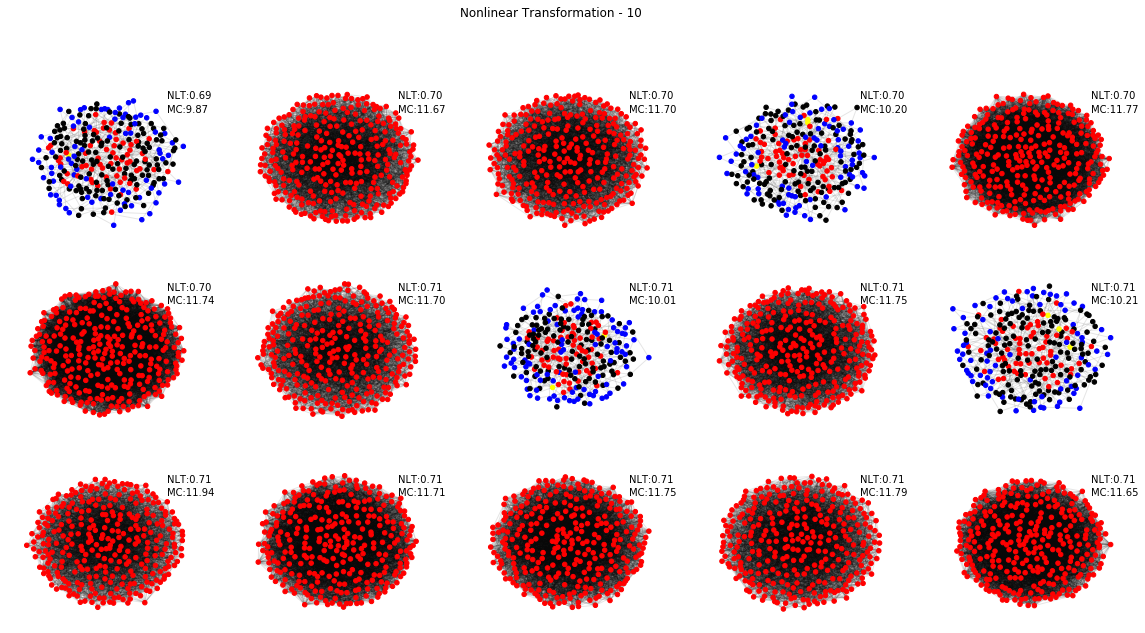

In [560]:
#NLT
fig = plt.figure(figsize=(20,10))
fig.suptitle('Nonlinear Transformation - ' +str(onAmp[chosenVolt]))
# fig.subplots_adjust(hspace=)
# fig.subplots_adjust(wspace=.2)
ax=[None]*len(colorstop)
for i in range(len(colorstop)):
    ax[i]=fig.add_subplot(3,5,i+1)
    ax[i].set_ylim([-1.2,1.2])
    ax[i].set_xlim([-1.2,1.2])
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
    ax[i].set_yticks([])
    ax[i].set_xticks([])
    ax[i].set_frame_on(False)
    pos=nx.kamada_kawai_layout(graphs[idxNLTtop[i]])
    nx.draw_networkx_nodes(graphs[idxNLTtop[i]],pos,node_color=colorstop[i],node_size=20)
    nx.draw_networkx_edges(graphs[idxNLTtop[i]],pos,alpha=0.1)
    plt.text(0.75,0.9,'NLT:'+"{0:.2f}".format(dfAllNLT[-15:].NonlinearTransform.values[i]),fontsize=10)
    plt.text(0.75,0.7,'MC:'+"{0:.2f}".format(dfAllNLT[-15:].MemoryCapacity.values[i]),fontsize=10)

plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/'+networkType+' Top 15 Networks - VSweep '+voltNames[chosenVolt]+'V NLT',dpi=300)  
fig = plt.figure(figsize=(20,10))
fig.suptitle('Nonlinear Transformation - ' +str(onAmp[chosenVolt]))
# fig.subplots_adjust(hspace=)
# fig.subplots_adjust(wspace=.2)
ax=[None]*len(colorsbottom)
for i in range(len(colorsbottom)):
    ax[i]=fig.add_subplot(3,5,i+1)
    ax[i].set_ylim([-1.2,1.2])
    ax[i].set_xlim([-1.2,1.2])
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
    ax[i].set_yticks([])
    ax[i].set_xticks([])
    ax[i].set_frame_on(False)
    pos=nx.kamada_kawai_layout(graphs[idxNLTbottom[i]])
    nx.draw_networkx_nodes(graphs[idxNLTbottom[i]],pos,node_color=colorsbottom[i],node_size=20)
    nx.draw_networkx_edges(graphs[idxNLTbottom[i]],pos,alpha=0.1)
    plt.text(0.75,0.9,'NLT:'+"{0:.2f}".format(dfAllNLT[:15].NonlinearTransform.values[i]),fontsize=10)
    plt.text(0.75,0.7,'MC:'+"{0:.2f}".format(dfAllNLT[:15].MemoryCapacity.values[i]),fontsize=10)

plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/'+networkType+' Bottom 15 Networks - VSweep '+voltNames[chosenVolt]+'V NLT',dpi=300)  

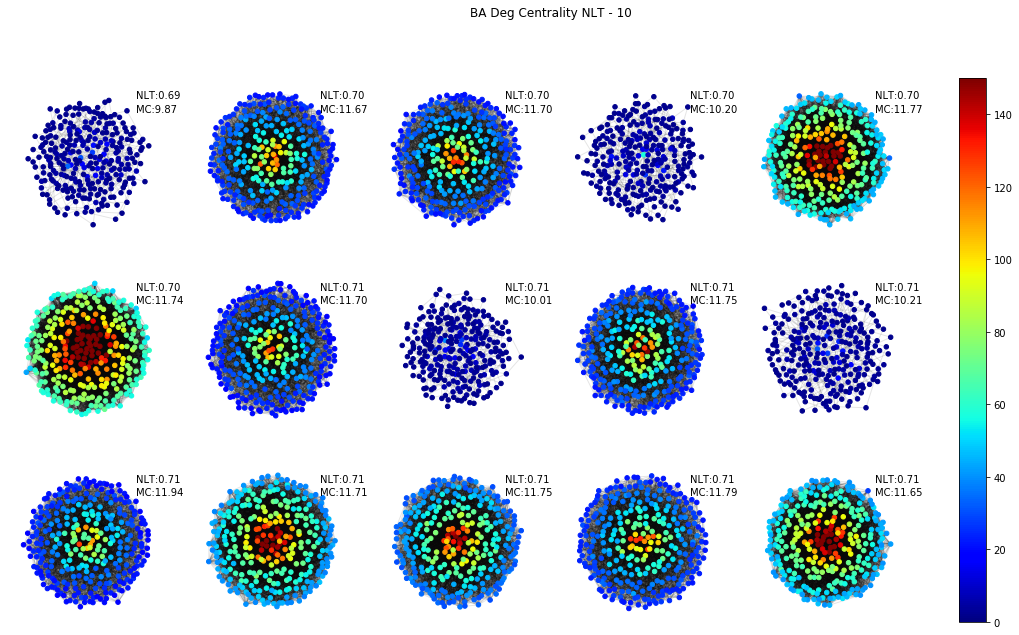

In [561]:
#Plot Degree Centrality Networks:
#NLT
fig,axes = plt.subplots(nrows=3,ncols=5,figsize=(20,10))
fig.suptitle(str(networkType)+' Deg Centrality NLT - ' +str(onAmp[chosenVolt]))
# fig.subplots_adjust(hspace=)
# fig.subplots_adjust(wspace=.2)
i=0
for ax in axes.flat:
    ax.set_ylim([-1.2,1.2])
    ax.set_xlim([-1.2,1.2])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_frame_on(False)
    pos=nx.kamada_kawai_layout(graphs[idxNLTtop[i]])
    h=nx.draw_networkx_nodes(graphs[idxNLTtop[i]],pos,cmap=plt.cm.jet,node_color=DEGtop[i],node_size=20,ax=ax,vmin=0,vmax=150)#np.max([np.max(np.hstack(DEG)),np.max(np.hstack(DEG_MC))]))
    nx.draw_networkx_edges(graphs[idxNLTtop[i]],pos,alpha=0.1,ax=ax)
    ax.text(0.75,0.9,'NLT:'+"{0:.2f}".format(dfAllNLT[-15:].NonlinearTransform.values[i]),fontsize=10)
    ax.text(0.75,0.7,'MC:'+"{0:.2f}".format(dfAllNLT[-15:].MemoryCapacity.values[i]),fontsize=10)
    i=i+1
fig.colorbar(h,ax=axes.ravel().tolist())


plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/'+networkType+'Top 15 Networks DEG Centrality - VSweep '+voltNames[chosenVolt]+'V NLT',dpi=300)  

fig,axes = plt.subplots(nrows=3,ncols=5,figsize=(20,10))
fig.suptitle(str(networkType)+' Deg Centrality NLT - ' +str(onAmp[chosenVolt]))
# fig.subplots_adjust(hspace=)
# fig.subplots_adjust(wspace=.2)
i=0
for ax in axes.flat:
    ax.set_ylim([-1.2,1.2])
    ax.set_xlim([-1.2,1.2])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_frame_on(False)
    pos=nx.kamada_kawai_layout(graphs[idxNLTbottom[i]])
    h=nx.draw_networkx_nodes(graphs[idxNLTbottom[i]],pos,cmap=plt.cm.jet,node_color=DEGbottom[i],node_size=20,ax=ax,vmin=0,vmax=150)#np.max([np.max(np.hstack(DEG)),np.max(np.hstack(DEG_MC))]))
    nx.draw_networkx_edges(graphs[idxNLTbottom[i]],pos,alpha=0.1,ax=ax)
    ax.text(0.75,0.9,'NLT:'+"{0:.2f}".format(dfAllNLT[:15].NonlinearTransform.values[i]),fontsize=10)
    ax.text(0.75,0.7,'MC:'+"{0:.2f}".format(dfAllNLT[:15].MemoryCapacity.values[i]),fontsize=10)
    i=i+1
fig.colorbar(h,ax=axes.ravel().tolist())

plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/'+networkType+' Bottom 15 Networks DEG Centrality - VSweep '+voltNames[chosenVolt]+'V NLT',dpi=300)  

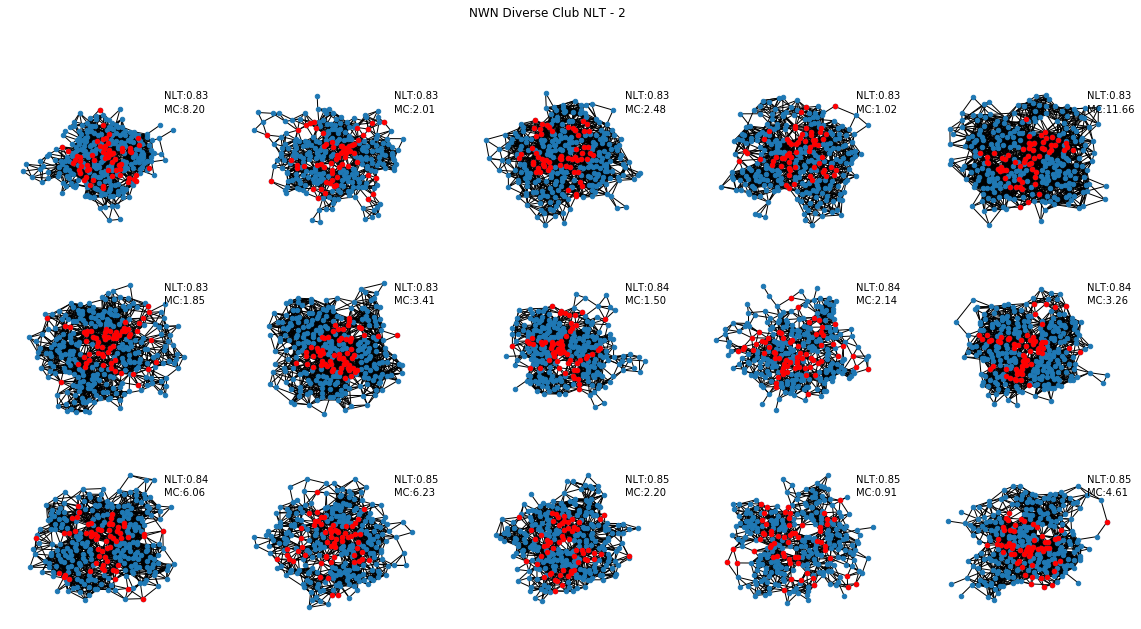

In [63]:
#Diverse Club analysis:

#Plot Degree Centrality Networks:
#NLT
fig,axes = plt.subplots(nrows=3,ncols=5,figsize=(20,10))
fig.suptitle(str(networkType)+' Diverse Club NLT - ' +str(onAmp[chosenVolt]))
# fig.subplots_adjust(hspace=)
# fig.subplots_adjust(wspace=.2)
i=0
for ax in axes.flat:
    ax.set_ylim([-1.2,1.2])
    ax.set_xlim([-1.2,1.2])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_frame_on(False)
    pos=nx.kamada_kawai_layout(graphs[idxNLTtop[i]])
    h=nx.draw(graphs[idxNLTtop[i]],pos=pos,ax=ax,node_size=20)
    nx.draw_networkx_nodes(graphs[idxNLTtop[i]],pos=pos,nodelist=np.array(graphs[idxNLTtop[i]].nodes())[diverseClub[idxNLTtop[i]]],node_color='r',cmap=plt.cm.jet,ax=ax,node_size=20)
    ax.text(0.75,0.9,'NLT:'+"{0:.2f}".format(dfAllNLT[-15:].NonlinearTransform.values[i]),fontsize=10)
    ax.text(0.75,0.7,'MC:'+"{0:.2f}".format(dfAllNLT[-15:].MemoryCapacity.values[i]),fontsize=10)
    i=i+1
#     fig.colorbar(h,ax=axes.ravel().tolist())


plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/'+networkType+'Top 15 Networks Diverse Club - VSweep '+voltNames[chosenVolt]+'V NLT',dpi=300)  

fig,axes = plt.subplots(nrows=3,ncols=5,figsize=(20,10))
fig.suptitle(str(networkType)+' Diverse Club NLT - ' +str(onAmp[chosenVolt]))
# fig.subplots_adjust(hspace=)
# fig.subplots_adjust(wspace=.2)
i=0
for ax in axes.flat:
    ax.set_ylim([-1.2,1.2])
    ax.set_xlim([-1.2,1.2])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_frame_on(False)
    pos=nx.kamada_kawai_layout(graphs[idxNLTbottom[i]])
    h=nx.draw(graphs[idxNLTbottom[i]],pos=pos,ax=ax,node_size=20)
    nx.draw_networkx_nodes(graphs[idxNLTbottom[i]],pos=pos,nodelist=np.array(graphs[idxNLTbottom[i]].nodes())[diverseClub[idxNLTbottom[i]]],node_color='r',cmap=plt.cm.jet,ax=ax,node_size=20)
    ax.text(0.75,0.9,'NLT:'+"{0:.2f}".format(dfAllNLT[:15].NonlinearTransform.values[i]),fontsize=10)
    ax.text(0.75,0.7,'MC:'+"{0:.2f}".format(dfAllNLT[:15].MemoryCapacity.values[i]),fontsize=10)
    i=i+1
#     fig.colorbar(h,ax=axes.ravel().tolist())

plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/'+networkType+' Bottom 15 Networks Diverse Club - VSweep '+voltNames[chosenVolt]+'V NLT',dpi=300)  


## Subgraph Analysis

In [897]:
folder='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/NWN Results/'

In [898]:
networks=[]
for i in range(len(ASN300)):
    for j in range(len(ASN300[i])):
        networks.append(ASN300[i][j])

In [899]:
NWN_NLT_sims=[]
NWN_MC_sims=[]
for i in range(len(networks)):
    name=folder+'NWN_NLT_Simulation_Network_'+str(i+1)+'_'+voltNames[chosenVolt]+'v.pkl'
    name2=folder+'NWNMC_Simulation_Network_'+str(i+1)+'_'+voltNames[chosenVolt]+'v.pkl'
    NWN_NLT_sims.append(decompress_pickle(name))
    NWN_MC_sims.append(decompress_pickle(name2))
    NWN_NLT_sims[i]['Voltage']=chosenVolt
    NWN_NLT_sims[i]['Index']=i
    NWN_MC_sims[i]['Voltage']=chosenVolt
    NWN_MC_sims[i]['Index']=i

In [773]:
#Subgraph AdjMat

#Threshold by conductance - when tunnelling becomes appreciable (offResistance * 10)

def getOnGraph(sims,network):#, this_TimeStamp = 0):
    edgeList = network['edge_list']
    adjMat = np.zeros((network['number_of_wires'], network['number_of_wires']))
#     set_trace()
    adjMat[edgeList[:,0], edgeList[:,1]] = (1/sims['JunctionResistance'])>1e-06#network.junctionSwitch[this_TimeStamp,:] #CHANGE THIS TO CONDUCTANCE THRESHOLD?
    adjMat[edgeList[:,1], edgeList[:,0]] = (1/sims['JunctionResistance'])>1e-06#network.junctionSwitch[this_TimeStamp,:] #CHANGE THIS TO CONDUCTANCE THRESHOLD?
    onGraph = nx.from_numpy_array(adjMat)
    onGraph=nx.DiGraph.to_undirected(onGraph)
    
    return onGraph

In [900]:
#sort by accuracy:
networks_NLT_Top=[]
graphs_NLT_Top=[]
NWN_NLT_sims_Top=[]
for idx in idxNLT_Top:#idxMaxNLT:#
    networks_NLT_Top.append(networks[idx])
    graphs_NLT_Top.append(graphs[idx])
    NWN_NLT_sims_Top.append(NWN_NLT_sims[idx])
    
#sort by accuracy:
networks_NLT_Bottom=[]
graphs_NLT_Bottom=[]
NWN_NLT_sims_Bottom=[]
for idx in idxNLT_Bottom:#idxMinNLT:#
    networks_NLT_Bottom.append(networks[idx])
    graphs_NLT_Bottom.append(graphs[idx])
    NWN_NLT_sims_Bottom.append(NWN_NLT_sims[idx])
    
#MC
#sort by accuracy:
networks_MC_Top=[]
graphs_MC_Top=[]
NWN_MC_sims_Top=[]
for idx in idxMC_Top:#idxMaxMC:#
    networks_MC_Top.append(networks[idx])
    graphs_MC_Top.append(graphs[idx])
    NWN_MC_sims_Top.append(NWN_MC_sims[idx])
    
#sort by accuracy:
networks_MC_Bottom=[]
graphs_MC_Bottom=[]
NWN_MC_sims_Bottom=[]
for idx in idxMC_Bottom:#idxMinMC:#
    networks_MC_Bottom.append(networks[idx])
    graphs_MC_Bottom.append(graphs[idx])
    NWN_MC_sims_Bottom.append(NWN_MC_sims[idx])

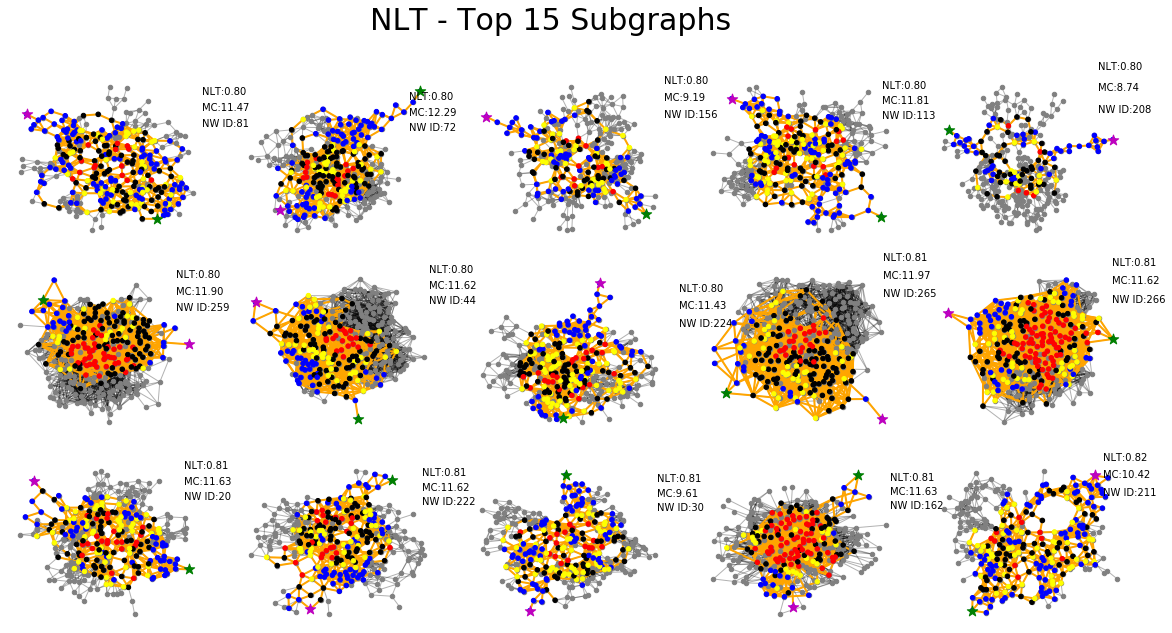

In [919]:
# time=4999
fig,axes = plt.subplots(nrows=3,ncols=5,figsize=(20,10))
fig.suptitle('NLT - Top 15 Subgraphs',fontsize=30)
# fig.subplots_adjust(hspace=)
# fig.subplots_adjust(wspace=.2)
subgraph_idx_Top=[]
subgraph_TopNLT=[]

i = 0
for ax in tqdm(axes.flat):
    sim=NWN_NLT_sims_Top[i]
    network=networks_NLT_Top[i]
    graph=graphs_NLT_Top[i]
    color=colorstop[i]#BW
    
    source=sim['Source']
    drain=sim['Drain']
    OGgraph=graph
    pos=nx.kamada_kawai_layout(OGgraph)
    
    sim['JunctionResistance']=1/sim['JunctionConductance']
    subGraph=getOnGraph(sim,network)
    components = [j for j in nx.connected_components(subGraph)] #all connected nodes in subgraph

    currMat = np.zeros((network['number_of_wires'],network['number_of_wires']))
    edgeList = network['edge_list']
    currMat[edgeList[:,0], edgeList[:,1]] = sim['JunctionVoltage']/sim['JunctionResistance'] #-1,:
    currMat = currMat + currMat.T
    currGraph = nx.from_numpy_array(currMat)
    subGraph = getOnGraph(sim,network)#this_TimeStamp=i)

    components = [j for j in nx.connected_components(subGraph)] #all connected nodes in subgraph

    max_ind = np.argmax([len(j) for j in nx.connected_components(subGraph)])
    currGraph = nx.subgraph(currGraph, components[max_ind])
    subgraph_idx_Top.append([node for node in currGraph.nodes()])
    subgraph_TopNLT.append(currGraph)

    color_subgraph=[]
    subgraph_nodes=[node for node in currGraph.nodes()]
    for node in subgraph_nodes:
        color_subgraph.append(color[node])
        
#     ax[i]=fig.add_subplot(3,5,i+1)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_frame_on(False)

    nx.draw_networkx_nodes(OGgraph,pos=pos,node_color='grey',node_size=20,ax=ax)
    nx.draw_networkx_edges(OGgraph,pos=pos,alpha=0.3,ax=ax)
    h=nx.draw_networkx_nodes(currGraph,pos=pos,cmap=plt.cm.jet,node_color=color_subgraph,node_size=20,ax=ax,vmin=0,vmax=1)#np.max(np.hstack(DEG)))
    nx.draw_networkx_edges(currGraph,pos=pos,edge_color='orange',width=2,ax=ax)
    nx.draw_networkx_nodes(currGraph,pos=pos,nodelist=[source],node_color='g',node_size=120,node_shape ='*',ax=ax)
    nx.draw_networkx_nodes(currGraph,pos=pos,nodelist=[drain],node_color='m',node_size=120,node_shape ='*',ax=ax)
    ax.text(0.85,0.9,'NLT:'+"{0:.2f}".format(dfAllNLT[-15:].NonlinearTransform.values[i]),fontsize=10)
    ax.text(0.85,0.7,'MC:'+"{0:.2f}".format(dfAllNLT[-15:].MemoryCapacity.values[i]),fontsize=10)
    ax.text(0.85,0.5,'NW ID:'+str(idxNLT_Top[i]),fontsize=10)
    i=i+1
    del sim, network, graph, color, currGraph, currMat, subGraph, OGgraph, components, edgeList, pos, subgraph_nodes, drain, source,max_ind,color_subgraph

# fig.colorbar(h,ax=axes.ravel().tolist())
    
plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/Top 15 Networks Subgraphs T = 5sec PCoeff - VSweep'+voltNames[chosenVolt]+'VNLT.png',dpi=300)          

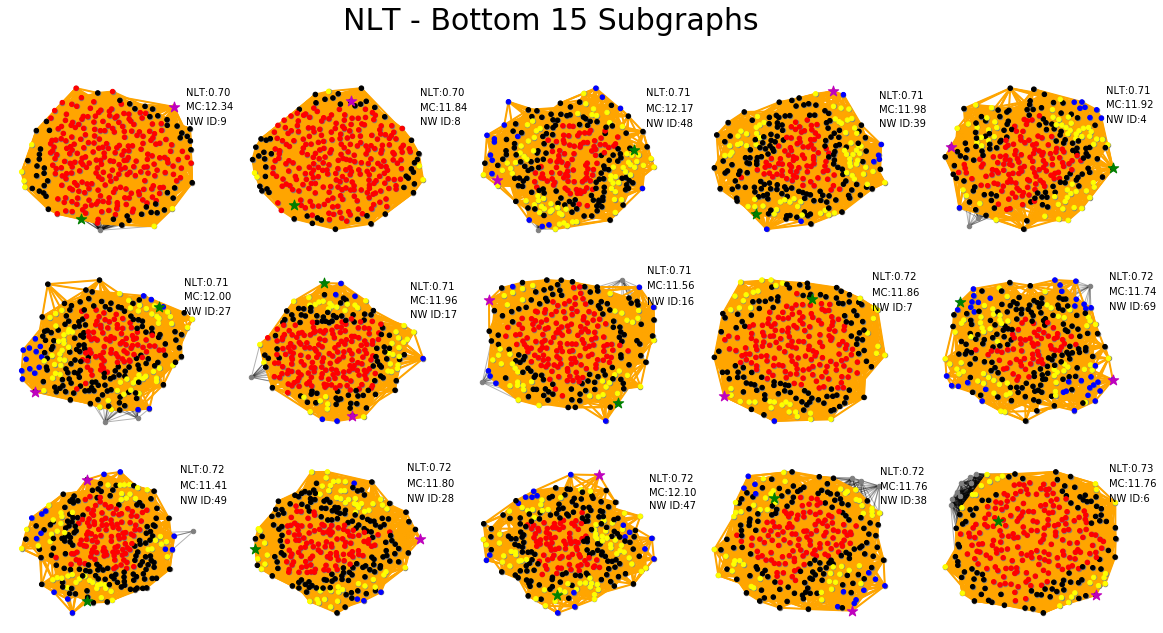

In [902]:
time=4999
fig,axes = plt.subplots(nrows=3,ncols=5,figsize=(20,10))
fig.suptitle('NLT - Bottom 15 Subgraphs',fontsize=30)
# fig.subplots_adjust(hspace=)
# fig.subplots_adjust(wspace=.2)
i = 0
subgraph_idx_Bottom=[]
subgraph_BottomNLT=[]

for ax in tqdm(axes.flat):
    sim=NWN_NLT_sims_Bottom[i]
    network=networks_NLT_Bottom[i]
    graph=graphs_NLT_Bottom[i]
    color=colorsbottom[i]#DEGbottom[i] #colors
    
    source=sim['Source']
    drain=sim['Drain']
    OGgraph=graph
    pos=nx.kamada_kawai_layout(OGgraph)
    
    sim['JunctionResistance']=1/sim['JunctionConductance']
    subGraph=getOnGraph(sim,network)
    components = [j for j in nx.connected_components(subGraph)] #all connected nodes in subgraph

    currMat = np.zeros((network['number_of_wires'],network['number_of_wires']))
    edgeList = network['edge_list']
    currMat[edgeList[:,0], edgeList[:,1]] = sim['JunctionVoltage']/sim['JunctionResistance'] #-1,:
    currMat = currMat + currMat.T
    currGraph = nx.from_numpy_array(currMat)
    subGraph = getOnGraph(sim,network)#this_TimeStamp=i)

    components = [j for j in nx.connected_components(subGraph)] #all connected nodes in subgraph

    max_ind = np.argmax([len(j) for j in nx.connected_components(subGraph)])
    currGraph = nx.subgraph(currGraph, components[max_ind])
    subgraph_idx_Bottom.append([node for node in currGraph.nodes()])
    subgraph_BottomNLT.append(currGraph)

    color_subgraph=[]
    subgraph_nodes=[node for node in currGraph.nodes()]
    for node in subgraph_nodes:
        color_subgraph.append(color[node])
        
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_frame_on(False)

    nx.draw_networkx_nodes(OGgraph,pos=pos,node_color='grey',node_size=20,ax=ax)
    nx.draw_networkx_edges(OGgraph,pos=pos,alpha=0.3,ax=ax)
    h=nx.draw_networkx_nodes(currGraph,pos=pos,cmap=plt.cm.jet,node_color=color_subgraph,node_size=20,ax=ax,vmin=0,vmax=1)
    nx.draw_networkx_edges(currGraph,pos=pos,edge_color='orange',width=2,ax=ax)
    nx.draw_networkx_nodes(currGraph,pos=pos,nodelist=[source],node_color='g',node_size=120,node_shape ='*',ax=ax)
    nx.draw_networkx_nodes(currGraph,pos=pos,nodelist=[drain],node_color='m',node_size=120,node_shape ='*',ax=ax)
    ax.text(0.85,0.9,'NLT:'+"{0:.2f}".format(dfAllNLT[:15].NonlinearTransform.values[i]),fontsize=10)
    ax.text(0.85,0.7,'MC:'+"{0:.2f}".format(dfAllNLT[:15].MemoryCapacity.values[i]),fontsize=10)
    ax.text(0.85,0.5,'NW ID:'+str(idxNLT_Bottom[i]),fontsize=10)

    i=i+1
    del sim, network, graph, color, currGraph, currMat, subGraph, OGgraph, components, edgeList, pos, subgraph_nodes, drain, source,max_ind,color_subgraph

# fig.colorbar(h,ax=axes.ravel().tolist())    

plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/Bottom 15 Networks Subgraphs T = 5sec PCoeff - VSweep'+voltNames[chosenVolt]+'VNLT.png',dpi=300)          

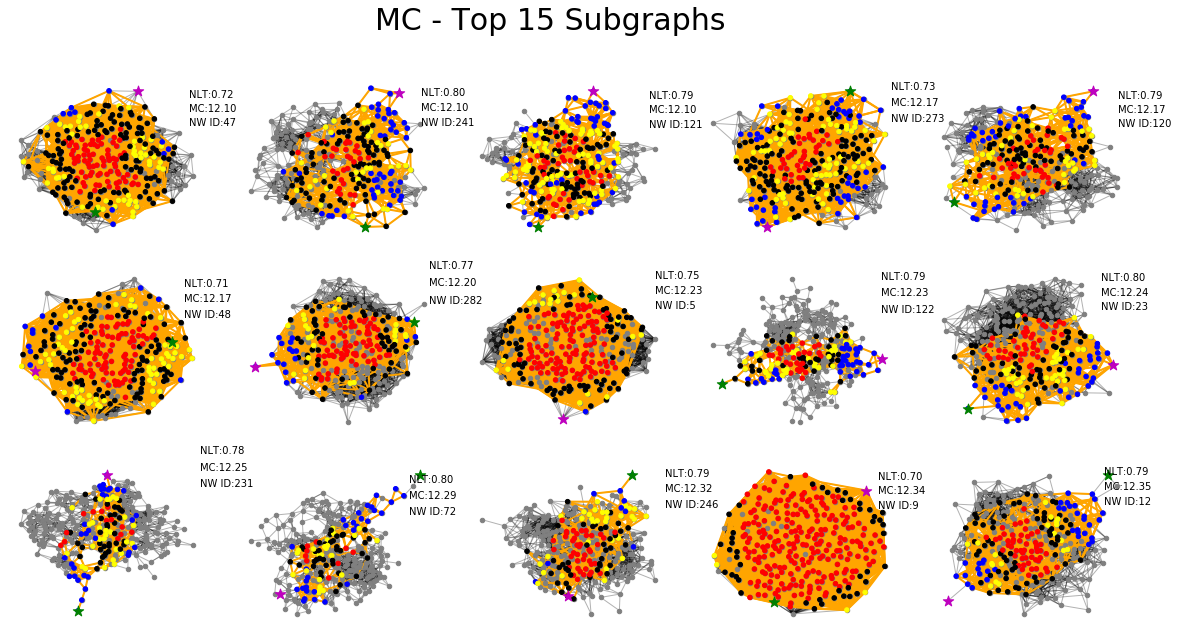

In [921]:
# time=4999
fig,axes = plt.subplots(nrows=3,ncols=5,figsize=(20,10))
fig.suptitle('MC - Top 15 Subgraphs',fontsize=30)
# fig.subplots_adjust(hspace=)
# fig.subplots_adjust(wspace=.2)
subgraph_idx_TopMC=[]
subgraph_TopMC=[]


i = 0
for ax in tqdm(axes.flat):
    sim=NWN_MC_sims_Top[i]
    network=networks_MC_Top[i]
    graph=graphs_MC_Top[i]
    color=colorsMCtop[i]#DEG_MC[i]#BW
    
    source=sim['Source']
    drain=sim['Drain']
    OGgraph=graph
    pos=nx.kamada_kawai_layout(OGgraph)
    
    sim['JunctionResistance']=1/sim['JunctionConductance']
    subGraph=getOnGraph(sim,network)
    components = [j for j in nx.connected_components(subGraph)] #all connected nodes in subgraph

    currMat = np.zeros((network['number_of_wires'],network['number_of_wires']))
    edgeList = network['edge_list']
    currMat[edgeList[:,0], edgeList[:,1]] = sim['JunctionVoltage']/sim['JunctionResistance'] #-1,:
    currMat = currMat + currMat.T
    currGraph = nx.from_numpy_array(currMat)
    subGraph = getOnGraph(sim,network)#this_TimeStamp=i)

    components = [j for j in nx.connected_components(subGraph)] #all connected nodes in subgraph

    max_ind = np.argmax([len(j) for j in nx.connected_components(subGraph)])
    currGraph = nx.subgraph(currGraph, components[max_ind])
    subgraph_idx_TopMC.append([node for node in currGraph.nodes()])
    subgraph_TopMC.append(currGraph)

    color_subgraph=[]
    subgraph_nodes=[node for node in currGraph.nodes()]
    for node in subgraph_nodes:
        color_subgraph.append(color[node])
        
#     ax[i]=fig.add_subplot(3,5,i+1)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_frame_on(False)

    nx.draw_networkx_nodes(OGgraph,pos=pos,node_color='grey',node_size=20,ax=ax)
    nx.draw_networkx_edges(OGgraph,pos=pos,alpha=0.3,ax=ax)
    h=nx.draw_networkx_nodes(currGraph,pos=pos,cmap=plt.cm.jet,node_color=color_subgraph,node_size=20,ax=ax,vmin=0,vmax=1)#np.max(np.hstack(DEG_MC)))
    nx.draw_networkx_edges(currGraph,pos=pos,edge_color='orange',width=2,ax=ax)
    nx.draw_networkx_nodes(currGraph,pos=pos,nodelist=[source],node_color='g',node_size=120,node_shape ='*',ax=ax)
    nx.draw_networkx_nodes(currGraph,pos=pos,nodelist=[drain],node_color='m',node_size=120,node_shape ='*',ax=ax)
    ax.text(0.85,0.9,'NLT:'+"{0:.2f}".format(dfAllMC[-15:].NonlinearTransform.values[i]),fontsize=10)
    ax.text(0.85,0.7,'MC:'+"{0:.2f}".format(dfAllMC[-15:].MemoryCapacity.values[i]),fontsize=10)
    ax.text(0.85,0.5,'NW ID:'+str(idxMC_Top[i]),fontsize=10)
    
    i=i+1
    del sim, network, graph, color, currGraph, currMat, subGraph, OGgraph, components, edgeList, pos, subgraph_nodes, drain, source,max_ind,color_subgraph

# fig.colorbar(h,ax=axes.ravel().tolist())
    
plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/Top 15 Networks Subgraphs T = 10sec PCoeff - VSweep'+voltNames[chosenVolt]+'VMC.png',dpi=300)          

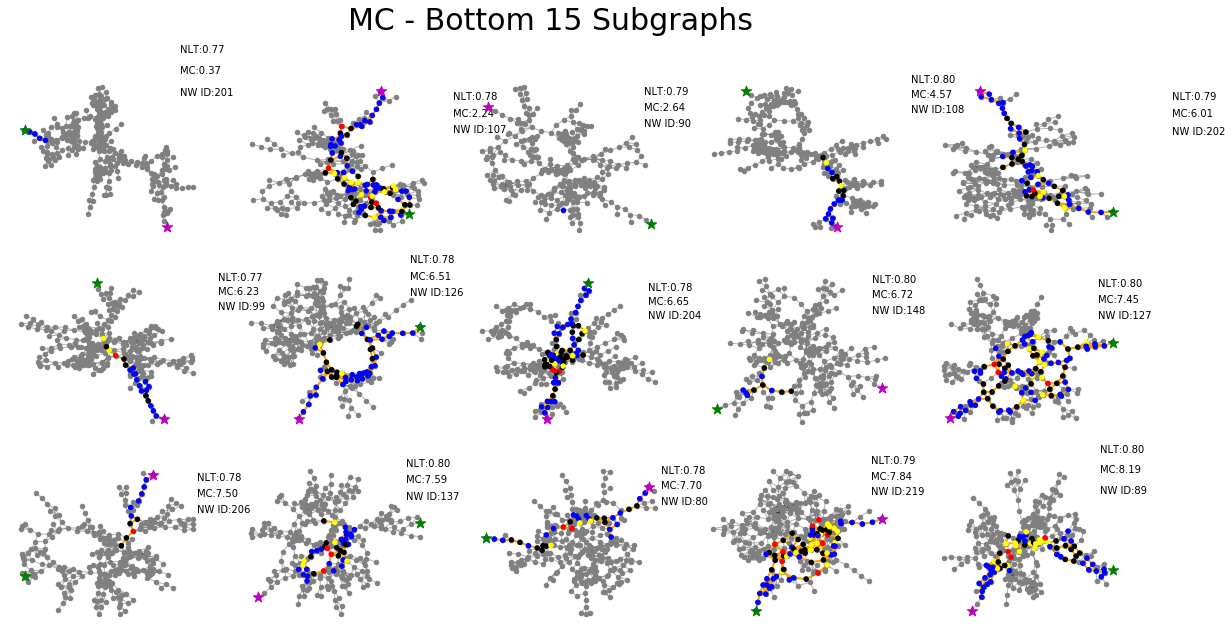

In [918]:
time=4999
fig,axes = plt.subplots(nrows=3,ncols=5,figsize=(20,10))
fig.suptitle('MC - Bottom 15 Subgraphs',fontsize=30)
# fig.subplots_adjust(hspace=)
# fig.subplots_adjust(wspace=.2)
i = 0
subgraph_idx_BottomMC=[]
subgraph_BottomMC=[]
for ax in tqdm(axes.flat):
    sim=NWN_MC_sims_Bottom[i]
    network=networks_MC_Bottom[i]
    graph=graphs_MC_Bottom[i]
    color=colorsMCbottom[i]#DEG_MCbottom[i] #colors
    
    source=sim['Source']
    drain=sim['Drain']
    OGgraph=graph
    pos=nx.kamada_kawai_layout(OGgraph)
    
    sim['JunctionResistance']=1/sim['JunctionConductance']
    subGraph=getOnGraph(sim,network)
    components = [j for j in nx.connected_components(subGraph)] #all connected nodes in subgraph

    currMat = np.zeros((network['number_of_wires'],network['number_of_wires']))
    edgeList = network['edge_list']
    currMat[edgeList[:,0], edgeList[:,1]] = sim['JunctionVoltage']/sim['JunctionResistance'] #-1,:
    currMat = currMat + currMat.T
    currGraph = nx.from_numpy_array(currMat)
    subGraph = getOnGraph(sim,network)#this_TimeStamp=i)

    components = [j for j in nx.connected_components(subGraph)] #all connected nodes in subgraph

    max_ind = np.argmax([len(j) for j in nx.connected_components(subGraph)])
    currGraph = nx.subgraph(currGraph, components[max_ind])
    subgraph_idx_BottomMC.append([node for node in currGraph.nodes()])
    subgraph_BottomMC.append(currGraph)

    color_subgraph=[]
    subgraph_nodes=[node for node in currGraph.nodes()]
    for node in subgraph_nodes:
        color_subgraph.append(color[node])
        
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_frame_on(False)

    nx.draw_networkx_nodes(OGgraph,pos=pos,node_color='grey',node_size=20,ax=ax)
    nx.draw_networkx_edges(OGgraph,pos=pos,alpha=0.3,ax=ax)
    h=nx.draw_networkx_nodes(currGraph,pos=pos,cmap=plt.cm.jet,node_color=color_subgraph,node_size=20,ax=ax,vmin=0,vmax=1)
    nx.draw_networkx_edges(currGraph,pos=pos,edge_color='orange',width=2,ax=ax)
    nx.draw_networkx_nodes(currGraph,pos=pos,nodelist=[source],node_color='g',node_size=120,node_shape ='*',ax=ax)
    nx.draw_networkx_nodes(currGraph,pos=pos,nodelist=[drain],node_color='m',node_size=120,node_shape ='*',ax=ax)
    ax.text(0.85,0.9,'NLT:'+"{0:.2f}".format(dfAllMC[:15].NonlinearTransform.values[i]),fontsize=10)
    ax.text(0.85,0.7,'MC:'+"{0:.2f}".format(dfAllMC[:15].MemoryCapacity.values[i]),fontsize=10)
    ax.text(0.85,0.5,'NW ID:'+str(idxMC_Bottom[i]),fontsize=10)
    
    i=i+1
    del sim, network, graph, color, currGraph, currMat, subGraph, OGgraph, components, edgeList, pos, subgraph_nodes, drain, source,max_ind,color_subgraph

# fig.colorbar(h,ax=axes.ravel().tolist())    

plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/Bottom 15 Networks Subgraphs T = 10sec PCoeff - VSweep'+voltNames[chosenVolt]+'VMC.png',dpi=300)          

#### Node-Level Measures:

In [834]:
PC=[]
MZ=[]
colors=[]
PCtop=pcoeffMaxNLT#[-15:]
MZtop=mzMaxNLT#[-15:]
PC_MCtop=pcoeffMaxMC#[-15:]
MZ_MCtop=mzMaxMC#[-15:]
PCbottom=pcoeffMinNLT#[:15]
MZbottom=mzMinNLT#[:15]
PC_MCbottom=pcoeffMinMC#[-15:]
MZ_MCbottom=mzMinMC#[-15:]
idxNLT=idxMaxNLT#[-15:]
idxNLT_Top=idxMaxNLT#[-15:]
idxNLT_Bottom=idxMinNLT#[:15]
idxMC=idxMaxMC#[-15:]
idxMC_Top=idxMaxMC#[-15:]
idxMC_Bottom=idxMinMC#[:15]

In [835]:
#sort by accuracy:
networks_NLT_Top=[]
graphs_NLT_Top=[]
NWN_NLT_sims_Top=[]
for idx in idxNLT_Top:#idxMaxNLT:#
    networks_NLT_Top.append(networks[idx])
    graphs_NLT_Top.append(graphs[idx])
    NWN_NLT_sims_Top.append(NWN_NLT_sims[idx])
    
#sort by accuracy:
networks_NLT_Bottom=[]
graphs_NLT_Bottom=[]
NWN_NLT_sims_Bottom=[]
for idx in idxNLT_Bottom:#idxMinNLT:#
    networks_NLT_Bottom.append(networks[idx])
    graphs_NLT_Bottom.append(graphs[idx])
    NWN_NLT_sims_Bottom.append(NWN_NLT_sims[idx])
    
#MC
#sort by accuracy:
networks_MC_Top=[]
graphs_MC_Top=[]
NWN_MC_sims_Top=[]
for idx in idxMC_Top:#idxMaxMC:#
    networks_MC_Top.append(networks[idx])
    graphs_MC_Top.append(graphs[idx])
    NWN_MC_sims_Top.append(NWN_MC_sims[idx])
    
#sort by accuracy:
networks_MC_Bottom=[]
graphs_MC_Bottom=[]
NWN_MC_sims_Bottom=[]
for idx in idxMC_Bottom:#idxMinMC:#
    networks_MC_Bottom.append(networks[idx])
    graphs_MC_Bottom.append(graphs[idx])
    NWN_MC_sims_Bottom.append(NWN_MC_sims[idx])

In [836]:
colorsbottom=[[None]*300 for i in range(len(PCbottom))]
count=0
for i in range(len(PCbottom)):
    count2=0
    for j in range(len(PCbottom[i])):
        if PCbottom[i][j] == 0:
            colorsbottom[count][count2]=1
            count2=count2+1
        elif PCbottom[i][j] >0.1 and PCbottom[i][j] <0.3:
            colorsbottom[count][count2]=2
            count2=count2+1
        elif PCbottom[i][j] > 0.5:
            colorsbottom[count][count2]=3
            count2=count2+1
        else:
            colorsbottom[count][count2]=0
            count2=count2+1
    count = count+1

colorstop=[[None]*300 for i in range(len(PCtop))]
count=0
for i in range(len(PCtop)):
    count2=0
    for j in range(len(PCtop[i])):
        if PCtop[i][j] == 0:
            colorstop[count][count2]=1
            count2=count2+1
        elif PCtop[i][j] >0.1 and PCtop[i][j] <0.3:
            colorstop[count][count2]=2
            count2=count2+1
        elif PCtop[i][j] > 0.5:
            colorstop[count][count2]=3
            count2=count2+1
        else:
            colorstop[count][count2]=0
            count2=count2+1
    count = count+1

In [837]:
colorsMCbottom=[[None]*300 for i in range(len(PC_MCbottom))]
count=0
for i in range(len(PC_MCbottom)):
    count2=0
    for j in range(len(PC_MCbottom[i])):
        if PC_MCbottom[i][j] == 0:
            colorsMCbottom[count][count2]=1
            count2=count2+1
        elif PC_MCbottom[i][j] >0.1 and PC_MCbottom[i][j] <0.3:
            colorsMCbottom[count][count2]=2
            count2=count2+1
        elif PC_MCbottom[i][j] > 0.5:
            colorsMCbottom[count][count2]=3
            count2=count2+1
        else:
            colorsMCbottom[count][count2]=0
            count2=count2+1
    count = count+1

colorsMCtop=[[None]*300 for i in range(len(PC_MCtop))]
count=0
for i in range(len(PC_MCtop)):
    count2=0
    for j in range(len(PC_MCtop[i])):
        if PC_MCtop[i][j] == 0:
            colorsMCtop[count][count2]=1
            count2=count2+1
        elif PC_MCtop[i][j] >0.1 and PC_MCtop[i][j] <0.3:
            colorsMCtop[count][count2]=2
            count2=count2+1
        elif PC_MCtop[i][j] > 0.5:
            colorsMCtop[count][count2]=3
            count2=count2+1
        else:
            colorsMCtop[count][count2]=0
            count2=count2+1
    count = count+1

In [838]:
for i in range(len(colorsMCtop)):
    for j in range(len(colorsMCtop[i])):
        if colorsMCtop[i][j]==0:
            colorsMCtop[i][j]='black'
        elif colorsMCtop[i][j]==1:
            colorsMCtop[i][j]='blue'
        elif colorsMCtop[i][j]==2:
            colorsMCtop[i][j]='yellow'
        elif colorsMCtop[i][j]==3:
            colorsMCtop[i][j]='red'

    colorsMCtop[i]=list(filter(None,colorsMCtop[i]))

for i in range(len(colorsMCbottom)):
    for j in range(len(colorsMCbottom[i])):
        if colorsMCbottom[i][j]==0:
            colorsMCbottom[i][j]='black'
        elif colorsMCbottom[i][j]==1:
            colorsMCbottom[i][j]='blue'
        elif colorsMCbottom[i][j]==2:
            colorsMCbottom[i][j]='yellow'
        elif colorsMCbottom[i][j]==3:
            colorsMCbottom[i][j]='red'

    colorsMCbottom[i]=list(filter(None,colorsMCbottom[i]))

In [839]:
for i in range(len(colorstop)):
    for j in range(len(colorstop[i])):
        if colorstop[i][j]==0:
            colorstop[i][j]='black'
        elif colorstop[i][j]==1:
            colorstop[i][j]='blue'
        elif colorstop[i][j]==2:
            colorstop[i][j]='yellow'
        elif colorstop[i][j]==3:
            colorstop[i][j]='red'

    colorstop[i]=list(filter(None,colorstop[i]))
    
for i in range(len(colorsbottom)):
    for j in range(len(colorsbottom[i])):
        if colorsbottom[i][j]==0:
            colorsbottom[i][j]='black'
        elif colorsbottom[i][j]==1:
            colorsbottom[i][j]='blue'
        elif colorsbottom[i][j]==2:
            colorsbottom[i][j]='yellow'
        elif colorsbottom[i][j]==3:
            colorsbottom[i][j]='red'

    colorsbottom[i]=list(filter(None,colorsbottom[i]))

In [840]:
subgraph_idx_Top=[]
subgraph_TopNLT=[]
for i in tqdm(range(50)):
    sim=NWN_NLT_sims_Top[i]
    network=networks_NLT_Top[i]
    graph=graphs_NLT_Top[i]
    color=colorstop[i] #colors
    
    source=sim['Source']
    drain=sim['Drain']
    OGgraph=graph
    pos=nx.kamada_kawai_layout(OGgraph)
    
    sim['JunctionResistance']=1/sim['JunctionConductance']
    subGraph=getOnGraph(sim,network)
    components = [j for j in nx.connected_components(subGraph)] #all connected nodes in subgraph

    currMat = np.zeros((network['number_of_wires'],network['number_of_wires']))
    edgeList = network['edge_list']
    currMat[edgeList[:,0], edgeList[:,1]] = sim['JunctionVoltage']/sim['JunctionResistance'] #-1,:
    currMat = currMat + currMat.T
    currGraph = nx.from_numpy_array(currMat)
    subGraph = getOnGraph(sim,network)#this_TimeStamp=i)

    components = [j for j in nx.connected_components(subGraph)] #all connected nodes in subgraph

    max_ind = np.argmax([len(j) for j in nx.connected_components(subGraph)])
    currGraph = nx.subgraph(currGraph, components[max_ind])
    subgraph_idx_Top.append([node for node in currGraph.nodes()])
    subgraph_TopNLT.append(currGraph)

    color_subgraph=[]
    subgraph_nodes=[node for node in currGraph.nodes()]

In [841]:
subgraph_idx_Bottom=[]
subgraph_BottomNLT=[]
for i in tqdm(range(50)):
    sim=NWN_NLT_sims_Bottom[i]
    network=networks_NLT_Bottom[i]
    graph=graphs_NLT_Bottom[i]
    color=colorsbottom[i] #colors
    
    source=sim['Source']
    drain=sim['Drain']
    OGgraph=graph
    pos=nx.kamada_kawai_layout(OGgraph)
    
    sim['JunctionResistance']=1/sim['JunctionConductance']
    subGraph=getOnGraph(sim,network)
    components = [j for j in nx.connected_components(subGraph)] #all connected nodes in subgraph

    currMat = np.zeros((network['number_of_wires'],network['number_of_wires']))
    edgeList = network['edge_list']
    currMat[edgeList[:,0], edgeList[:,1]] = sim['JunctionVoltage']/sim['JunctionResistance'] #-1,:
    currMat = currMat + currMat.T
    currGraph = nx.from_numpy_array(currMat)
    subGraph = getOnGraph(sim,network)#this_TimeStamp=i)

    components = [j for j in nx.connected_components(subGraph)] #all connected nodes in subgraph

    max_ind = np.argmax([len(j) for j in nx.connected_components(subGraph)])
    currGraph = nx.subgraph(currGraph, components[max_ind])
    subgraph_idx_Bottom.append([node for node in currGraph.nodes()])
    subgraph_BottomNLT.append(currGraph)

    color_subgraph=[]
    subgraph_nodes=[node for node in currGraph.nodes()]

In [842]:
subgraph_idx_TopMC=[]
subgraph_TopMC=[]
for i in tqdm(range(50)):
    sim=NWN_MC_sims_Top[i]
    network=networks_MC_Top[i]
    graph=graphs_MC_Top[i]
    color=colorsMCtop[i] #colors
    
    source=sim['Source']
    drain=sim['Drain']
    OGgraph=graph
    pos=nx.kamada_kawai_layout(OGgraph)
    
    sim['JunctionResistance']=1/sim['JunctionConductance']
    subGraph=getOnGraph(sim,network)
    components = [j for j in nx.connected_components(subGraph)] #all connected nodes in subgraph

    currMat = np.zeros((network['number_of_wires'],network['number_of_wires']))
    edgeList = network['edge_list']
    currMat[edgeList[:,0], edgeList[:,1]] = sim['JunctionVoltage']/sim['JunctionResistance'] #-1,:
    currMat = currMat + currMat.T
    currGraph = nx.from_numpy_array(currMat)
    subGraph = getOnGraph(sim,network)#this_TimeStamp=i)

    components = [j for j in nx.connected_components(subGraph)] #all connected nodes in subgraph

    max_ind = np.argmax([len(j) for j in nx.connected_components(subGraph)])
    currGraph = nx.subgraph(currGraph, components[max_ind])
    subgraph_idx_TopMC.append([node for node in currGraph.nodes()])
    subgraph_TopMC.append(currGraph)

    color_subgraph=[]
    subgraph_nodes=[node for node in currGraph.nodes()]

In [843]:
subgraph_idx_BottomMC=[]
subgraph_BottomMC=[]
for i in tqdm(range(50)):
    sim=NWN_MC_sims_Bottom[i]
    network=networks_MC_Bottom[i]
    graph=graphs_MC_Bottom[i]
    color=colorsMCbottom[i] #colors
    
    source=sim['Source']
    drain=sim['Drain']
    OGgraph=graph
    pos=nx.kamada_kawai_layout(OGgraph)
    
    sim['JunctionResistance']=1/sim['JunctionConductance']
    subGraph=getOnGraph(sim,network)
    components = [j for j in nx.connected_components(subGraph)] #all connected nodes in subgraph

    currMat = np.zeros((network['number_of_wires'],network['number_of_wires']))
    edgeList = network['edge_list']
    currMat[edgeList[:,0], edgeList[:,1]] = sim['JunctionVoltage']/sim['JunctionResistance'] #-1,:
    currMat = currMat + currMat.T
    currGraph = nx.from_numpy_array(currMat)
    subGraph = getOnGraph(sim,network)#this_TimeStamp=i)

    components = [j for j in nx.connected_components(subGraph)] #all connected nodes in subgraph

    max_ind = np.argmax([len(j) for j in nx.connected_components(subGraph)])
    currGraph = nx.subgraph(currGraph, components[max_ind])
    subgraph_idx_BottomMC.append([node for node in currGraph.nodes()])
    subgraph_BottomMC.append(currGraph)

    color_subgraph=[]
    subgraph_nodes=[node for node in currGraph.nodes()]

In [844]:
pcoeffMaxNLT_subgraph=[]
pcoeffMinNLT_subgraph=[]
mzMaxNLT_subgraph=[]
mzMinNLT_subgraph=[]
centralityMaxNLT_subgraph=[]
centralityMinNLT_subgraph=[]
pcoeffMaxMC_subgraph=[]
pcoeffMinMC_subgraph=[]
mzMaxMC_subgraph=[]
mzMinMC_subgraph=[]
commMaxNLT_subgraph=[]
commMinNLT_subgraph=[]
commMaxMC_subgraph=[]
commMinMC_subgraph=[]
centralityMaxMC_subgraph=[]
centralityMinMC_subgraph=[]

for i in tqdm(range(len(subgraph_idx_Top))):
    pcoeffMaxNLT_subgraph.append(pcoeffMaxNLT[i][subgraph_idx_Top[i]])
    mzMaxNLT_subgraph.append(mzMaxNLT[i][subgraph_idx_Top[i]])
    centralityMaxNLT_subgraph.append(np.array(centralityMaxNLT[i])[np.array(subgraph_idx_Top[i])])
    commMaxNLT_subgraph.append(nx.communicability(subgraph_TopNLT[i]))
    centralityMaxMC_subgraph.append(np.array(centralityMaxMC[i])[np.array(subgraph_idx_TopMC[i])])
    
    pcoeffMaxMC_subgraph.append(pcoeffMaxMC[i][subgraph_idx_TopMC[i]])
    mzMaxMC_subgraph.append(mzMaxMC[i][subgraph_idx_TopMC[i]])
    commMaxMC_subgraph.append(nx.communicability(subgraph_TopMC[i]))

In [845]:
for i in tqdm(range(len(subgraph_idx_Bottom))):
    pcoeffMinNLT_subgraph.append(pcoeffMinNLT[i][subgraph_idx_Bottom[i]])
    mzMinNLT_subgraph.append(mzMinNLT[i][subgraph_idx_Bottom[i]])
    centralityMinNLT_subgraph.append(np.array(centralityMinNLT[i])[np.array(subgraph_idx_Bottom[i])])
    commMinNLT_subgraph.append(nx.communicability(subgraph_BottomNLT[i]))
    centralityMinMC_subgraph.append(np.array(centralityMinMC[i])[np.array(subgraph_idx_BottomMC[i])])

    
    pcoeffMinMC_subgraph.append(pcoeffMinMC[i][subgraph_idx_BottomMC[i]])
    mzMinMC_subgraph.append(mzMinMC[i][subgraph_idx_BottomMC[i]])
    commMinMC_subgraph.append(nx.communicability(subgraph_BottomMC[i]))

In [847]:
tempMax=[]
tempMin=[]
tempMZMax=[]
tempMZMin=[]
tempCentralityMax=[]
tempCentralityMin=[]
tempCommMax=[]
tempCommMin=[]

for i in range(15):
    tempMax.append(pcoeffMaxNLT_subgraph[-15:][i])
    tempMin.append(pcoeffMinNLT_subgraph[:15][i])
    tempMZMax.append(mzMaxNLT_subgraph[-15:][i])
    tempMZMin.append(mzMinNLT_subgraph[:15][i])
    tempCentralityMax.append(centralityMaxNLT_subgraph[-15:][i])
    tempCentralityMin.append(centralityMinNLT_subgraph[:15][i])
    
tempMZMax=np.hstack(tempMZMax)
tempMZMin=np.hstack(tempMZMin)
tempMax=np.hstack(tempMax)
tempMin=np.hstack(tempMin)
tempCentralityMax=np.hstack(tempCentralityMax)
tempCentralityMin=np.hstack(tempCentralityMin)

avgpcoeffMin,stdpcoeffMin=tolerant_mean(pcoeffMinNLT_subgraph[:15])
avgmzMin,stdmzMin=tolerant_mean(mzMinNLT_subgraph[:15])

avgpcoeffMax,stdpcoeffMax=tolerant_mean(pcoeffMaxNLT_subgraph[-15:])
avgmzMax,stdmzMax=tolerant_mean(mzMaxNLT_subgraph[-15:])

avgcentralityMax,stdcentralityMax=tolerant_mean(centralityMaxNLT_subgraph)
avgcentralityMin,stdcentralityMin=tolerant_mean(centralityMinNLT_subgraph)

tempMaxMC=[]
tempMinMC=[]
tempMZMaxMC=[]
tempMZMinMC=[]
tempCentralityMaxMC=[]
tempCentralityMinMC=[]

for i in range(15):
    tempMaxMC.append(pcoeffMaxMC_subgraph[-15:][i])
    tempMinMC.append(pcoeffMinMC_subgraph[:15][i])
    tempMZMaxMC.append(mzMaxMC_subgraph[-15:][i])
    tempMZMinMC.append(mzMinMC_subgraph[:15][i])
    tempCentralityMaxMC.append(centralityMaxMC_subgraph[-15:][i])
    tempCentralityMinMC.append(centralityMinMC_subgraph[:15][i])
    
tempMZMaxMC=np.hstack(tempMZMaxMC)
tempMZMinMC=np.hstack(tempMZMinMC)
tempMaxMC=np.hstack(tempMaxMC)
tempMinMC=np.hstack(tempMinMC)
tempCentralityMaxMC=np.hstack(tempCentralityMaxMC)
tempCentralityMinMC=np.hstack(tempCentralityMinMC)


avgpcoeffMinMC,stdpcoeffMinMC=tolerant_mean(pcoeffMinMC_subgraph)
avgmzMinMC,stdmzMinMC=tolerant_mean(mzMinMC_subgraph)

avgpcoeffMaxMC,stdpcoeffMaxMC=tolerant_mean(pcoeffMaxMC_subgraph)
avgmzMaxMC,stdmzMaxMC=tolerant_mean(mzMaxMC_subgraph)

# avgcentralityMax,stdcentralityMax=tolerant_mean(centralityMaxNLT_subgraph)
# avgcentralityMin,stdcentralityMin=tolerant_mean(centralityMinNLT_subgraph)

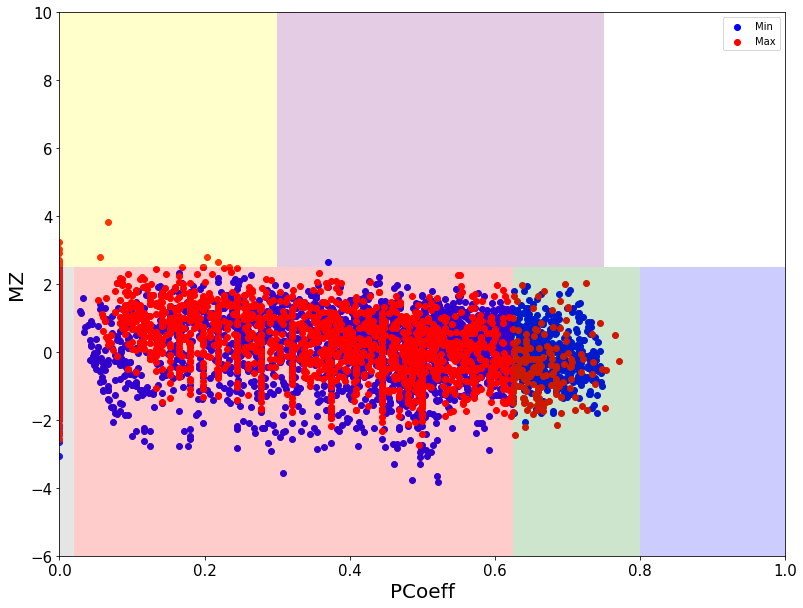

In [849]:
#NLT DRAW ALL NETWORKS ON SAME SPACE
from edamame.analysis.misc import draw_zp_space
fig=plt.figure(figsize=(13,10))
fig.subplots_adjust(hspace=.6)
fig.subplots_adjust(wspace=.6)
ax=plt.gca()
draw_zp_space(ax = ax)


for j in tqdm(range(len(pcoeffMinNLT_subgraph[:15]))):
    idx = j  
    line = ax.scatter(pcoeffMinNLT_subgraph[:15][j],mzMinNLT_subgraph[:15][j],c='b')

for j in tqdm(range(len(pcoeffMaxNLT_subgraph[-15:]))):
    idx = j  
    line2 = ax.scatter(pcoeffMaxNLT_subgraph[-15:][j],mzMaxNLT_subgraph[-15:][j],c='r')

#     ax[i].set_title('Max Accuracy ',fontsize=30)
ax.set_xlabel('PCoeff',fontsize=20)#,labelpad=5)
ax.set_ylabel('MZ',fontsize=20)#,labelpad=5)
# plt.text(0.7,6,'SW:'+"{0:.2f}".format(dfAllMC[:50].SmallWorldness.values[j]),fontsize=15)
# plt.text(0.7,8,'MC:'+"{0:.2f}".format(dfAllMC[:50].MemoryCapacity.values[j]),fontsize=15)
ax.set_ylim(-6, 10)
ax.set_xlim(0,1)
ax.tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
ax.tick_params(axis='both', which='minor', labelsize=15)

plt.legend([line,line2],['Min','Max'])

plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/GuimeraAmeral 15MinMax Networks Subgraphs - VSweep'+voltNames[chosenVolt]+'VNLT',dpi=300)    

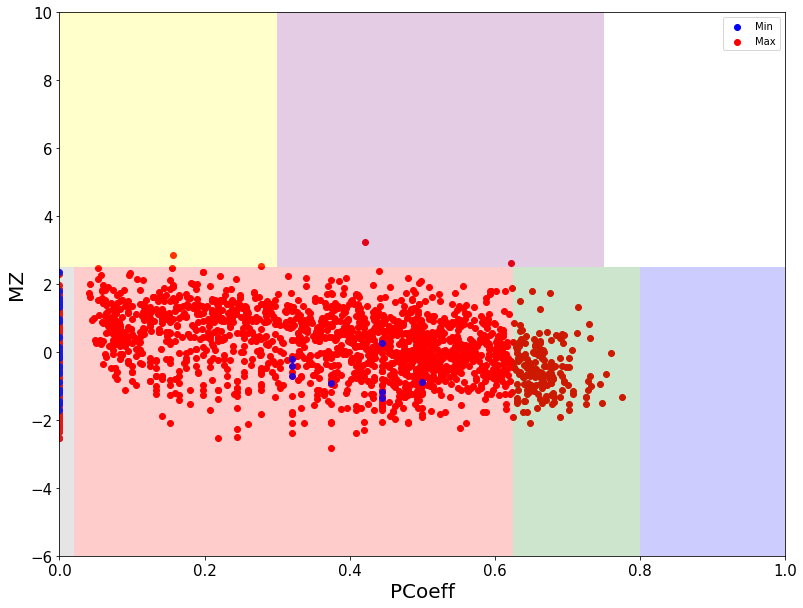

In [850]:
#NLT DRAW ALL NETWORKS ON SAME SPACE
from edamame.analysis.misc import draw_zp_space
fig=plt.figure(figsize=(13,10))
fig.subplots_adjust(hspace=.6)
fig.subplots_adjust(wspace=.6)
ax=plt.gca()
draw_zp_space(ax = ax)

for j in tqdm(range(len(pcoeffMaxMC_subgraph[-15:]))):
    idx = j  
    line2 = ax.scatter(pcoeffMaxMC_subgraph[-15:][j],mzMaxMC_subgraph[-15:][j],c='r')


for j in tqdm(range(len(pcoeffMinMC_subgraph[:15]))):
    idx = j  
    line = ax.scatter(pcoeffMinMC_subgraph[:15][j],mzMinMC_subgraph[:15][j],c='b')


#     ax[i].set_title('Max Accuracy ',fontsize=30)
ax.set_xlabel('PCoeff',fontsize=20)#,labelpad=5)
ax.set_ylabel('MZ',fontsize=20)#,labelpad=5)
# plt.text(0.7,6,'SW:'+"{0:.2f}".format(dfAllMC[:50].SmallWorldness.values[j]),fontsize=15)
# plt.text(0.7,8,'MC:'+"{0:.2f}".format(dfAllMC[:50].MemoryCapacity.values[j]),fontsize=15)
ax.set_ylim(-6, 10)
ax.set_xlim(0,1)
ax.tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
ax.tick_params(axis='both', which='minor', labelsize=15)

plt.legend([line,line2],['Min','Max'])

plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/GuimeraAmeral 15MinMax Networks Subgraphs - VSweep'+voltNames[chosenVolt]+'VMC',dpi=300)    

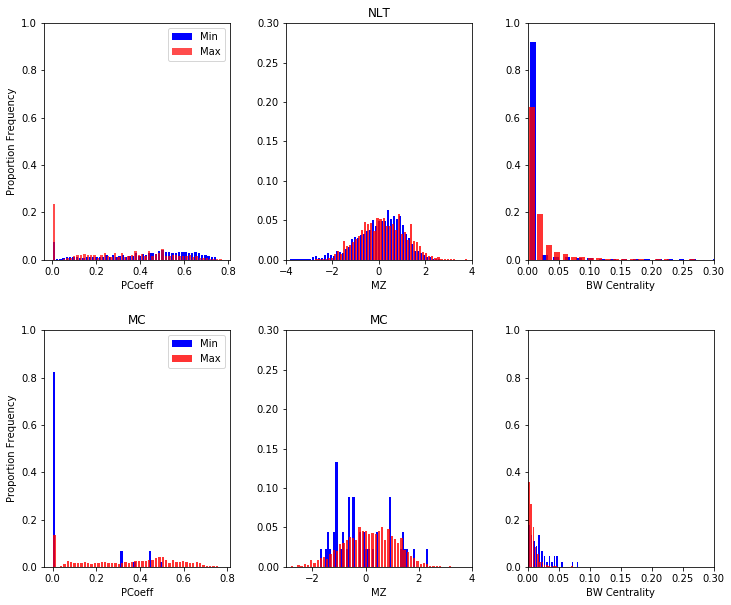

In [855]:
#HISTOGRAMS COMPARING ALL PCOEFF WITH ALL MZ TOP - SUBGRAPHS
#BOTTOM 50 Networks:
# NONLINEAR TRANSFORMATION
# PCOEFF
fig=plt.figure(figsize=(12,10))
ax=[None]*5
fig.subplots_adjust(wspace=.3)
fig.subplots_adjust(hspace=.3)

ax[0]=fig.add_subplot(231)

hist, bins=np.histogram(tempMax,50)
histMin, binsMin=np.histogram(tempMin,50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
widthMin=0.7 * (binsMin[1] - binsMin[0])
centerMin=(binsMin[:-1] + binsMin[1:]) / 2
plt.bar(centerMin, histMin/len(tempMin), align='center', width=width,label='Min',color='b')
plt.bar(center, hist/len(tempMax), align='center', width=width,label='Max',color='r',alpha=0.7)
# plt.xlim([0.01,0.8])
plt.ylim([0,1])

# plt.xlim([0.01,0.8])
# plt.ylim([0,700])
plt.xlabel('PCoeff')
plt.ylabel('Proportion Frequency')
plt.legend()

# NONLINEAR TRANSFORMATION
# MZ
ax[1]=fig.add_subplot(232)
plt.title('NLT')
hist, bins=np.histogram(tempMZMax,50)
histMin, binsMin=np.histogram(tempMZMin,50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
widthMin=0.7 * (binsMin[1] - binsMin[0])
centerMin=(binsMin[:-1] + binsMin[1:]) / 2
plt.bar(centerMin, histMin/len(tempMZMin), align='center', width=width,label='Min',color='b')
plt.bar(center, hist/len(tempMZMax), align='center', width=width,label='Max',color='r',alpha=0.8)
plt.xlabel('MZ')
plt.ylim([0,0.3])
plt.xlim([-4,4])

#BW Centrality
ax[2]=fig.add_subplot(233)
hist, bins=np.histogram(tempCentralityMax,20)
histMin, binsMin=np.histogram(tempCentralityMin,20)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
widthMin=0.7 * (binsMin[1] - binsMin[0])
centerMin=(binsMin[:-1] + binsMin[1:]) / 2
plt.bar(centerMin, histMin/len(tempCentralityMin), align='center', width=width,label='Min',color='b')
plt.bar(center, hist/len(tempCentralityMax), align='center', width=width,label='Max',color='r',alpha=0.8)
plt.xlabel('BW Centrality')
plt.ylim([0,1])
plt.xlim([0,0.3])



#MEMORY CAPACITY
#PCOEFF
ax[3]=fig.add_subplot(234)
plt.title('MC')
hist, bins=np.histogram(tempMaxMC,50)
histMin, binsMin=np.histogram(tempMinMC,50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
widthMin=0.7 * (binsMin[1] - binsMin[0])
centerMin=(binsMin[:-1] + binsMin[1:]) / 2
plt.bar(centerMin, histMin/len(tempMinMC), align='center', width=width,label='Min',color='b')
plt.bar(center, hist/len(tempMaxMC), align='center', width=width,label='Max',color='r',alpha=0.8)
# plt.xlim([0.01,0.8])
plt.ylim([0,1])

# plt.xlim([0.01,0.8])
# plt.ylim([0,700])
plt.xlabel('PCoeff')
plt.ylabel('Proportion Frequency')
plt.legend()

# MEMORY CAPACITY
# MZ
ax[4]=fig.add_subplot(235)
plt.title('MC')
hist, bins=np.histogram(tempMZMaxMC,50)
histMin, binsMin=np.histogram(tempMZMinMC,50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
widthMin=0.7 * (binsMin[1] - binsMin[0])
centerMin=(binsMin[:-1] + binsMin[1:]) / 2
plt.bar(centerMin, histMin/len(tempMZMinMC), align='center', width=width,label='Min',color='b')
plt.bar(center, hist/len(tempMZMaxMC), align='center', width=width,label='Max',color='r',alpha=0.8)
plt.xlabel('MZ')
plt.ylim([0,0.3])
plt.xlim([-3,4])

#BW Centrality
ax[2]=fig.add_subplot(236)
hist, bins=np.histogram(tempCentralityMaxMC,20)
histMin, binsMin=np.histogram(tempCentralityMinMC,20)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
widthMin=0.7 * (binsMin[1] - binsMin[0])
centerMin=(binsMin[:-1] + binsMin[1:]) / 2
plt.bar(centerMin, histMin/len(tempCentralityMinMC), align='center', width=width,label='Min',color='b')
plt.bar(center, hist/len(tempCentralityMaxMC), align='center', width=width,label='Max',color='r',alpha=0.8)
plt.xlabel('BW Centrality')
plt.ylim([0,1])
plt.xlim([0,0.3])


plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/PCoeff MZ BWCentrality 15MinMax Networks Subgraphs Histograms - VSweep'+voltNames[chosenVolt]+'V MC+NLT',dpi=300)    

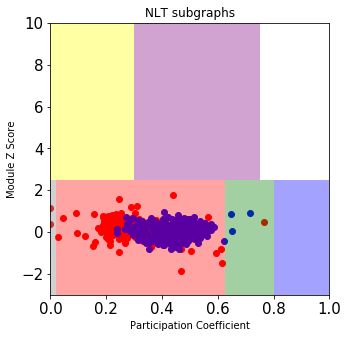

In [856]:
#Mean PCOEFF and MZ for bottom NLT and top NLT:
#SUBGRAPHS
fig=plt.figure(figsize=(5,5))
ax=[None]*1
fig.subplots_adjust(wspace=.3)
fig.subplots_adjust(hspace=.3)
ax[0]=fig.add_subplot(111)
plt.title('NLT subgraphs')

line = ax[0].scatter(avgpcoeffMax,avgmzMax,c='r')
ax[0].set_ylim(-3, 10)
ax[0].set_xlim(0,1)
draw_zp_space(ax = ax[0])
ax[0].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
ax[0].tick_params(axis='both', which='minor', labelsize=15)

line = ax[0].scatter(avgpcoeffMin,avgmzMin,c='b')
ax[0].set_ylim(-3, 10)
ax[0].set_xlim(0,1)
draw_zp_space(ax = ax[0])
ax[0].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
ax[0].tick_params(axis='both', which='minor', labelsize=15)



plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/GuimeraAmeral Avg 15MinMax Networks Subgraphs - VSweep'+voltNames[chosenVolt]+'VNLT',dpi=300)    

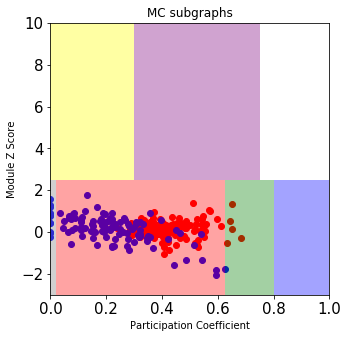

In [857]:
#Mean PCOEFF and MZ for bottom NLT and top NLT:
#SUBGRAPHS
fig=plt.figure(figsize=(5,5))
ax=[None]*1
fig.subplots_adjust(wspace=.3)
fig.subplots_adjust(hspace=.3)
ax[0]=fig.add_subplot(111)
plt.title('MC subgraphs')

line = ax[0].scatter(avgpcoeffMaxMC,avgmzMaxMC,c='r')
ax[0].set_ylim(-3, 10)
ax[0].set_xlim(0,1)
draw_zp_space(ax = ax[0])
ax[0].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
ax[0].tick_params(axis='both', which='minor', labelsize=15)

line = ax[0].scatter(avgpcoeffMinMC,avgmzMinMC,c='b')
ax[0].set_ylim(-3, 10)
ax[0].set_xlim(0,1)
draw_zp_space(ax = ax[0])
ax[0].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
ax[0].tick_params(axis='both', which='minor', labelsize=15)



plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/GuimeraAmeral Avg 15MinMax Networks Subgraphs - VSweep'+voltNames[chosenVolt]+'VMC',dpi=300)    

---

---

Next, we repeat it all in Beta-Sweep networks

In [415]:
subgraph_idx_TopMC=[]
subgraph_TopMC=[]
for i in tqdm(range(50)):
    sim=NWN_MC_sims_Top[i]
    network=networks_MC_Top[i]
    graph=graphs_MC_Top[i]
    color=colorsMC[i] #colors
    
    source=sim['Source']
    drain=sim['Drain']
    Ggraph=graph
    pos=nx.kamada_kawai_layout(OGgraph)
    
    sim['JunctionResistance']=1/sim['JunctionConductance']
    subGraph=getOnGraph(sim,network)
    components = [j for j in nx.connected_components(subGraph)] #all connected nodes in subgraph

    currMat = np.zeros((network['number_of_wires'],network['number_of_wires']))
    edgeList = network['edge_list']
    currMat[edgeList[:,0], edgeList[:,1]] = sim['JunctionVoltage']/sim['JunctionResistance'] #-1,:
    currMat = currMat + currMat.T
    currGraph = nx.from_numpy_array(currMat)
    subGraph = getOnGraph(sim,network)#this_TimeStamp=i)

    components = [j for j in nx.connected_components(subGraph)] #all connected nodes in subgraph

    max_ind = np.argmax([len(j) for j in nx.connected_components(subGraph)])
    currGraph = nx.subgraph(currGraph, components[max_ind])
    subgraph_idx_TopMC.append([node for node in currGraph.nodes()])
    subgraph_TopMC.append(currGraph)
    
    color_subgraph=[]
    subgraph_nodes=[node for node in currGraph.nodes()]

In [424]:
subgraph_idx_BottomMC=[]
subgraph_BottomMC=[]
for i in tqdm(range(50)):
    sim=NWN_MC_sims_Bottom[i]
    network=networks_MC_Bottom[i]
    graph=graphs_MC_Bottom[i]
    color=colorsMC[i] #colors
    
    source=sim['Source']
    drain=sim['Drain']
    OGgraph=graph
    pos=nx.kamada_kawai_layout(OGgraph)
    
    sim['JunctionResistance']=1/sim['JunctionConductance']
    subGraph=getOnGraph(sim,network)
    components = [j for j in nx.connected_components(subGraph)] #all connected nodes in subgraph

    currMat = np.zeros((network['number_of_wires'],network['number_of_wires']))
    edgeList = network['edge_list']
    currMat[edgeList[:,0], edgeList[:,1]] = sim['JunctionVoltage']/sim['JunctionResistance'] #-1,:
    currMat = currMat + currMat.T
    currGraph = nx.from_numpy_array(currMat)
    subGraph = getOnGraph(sim,network)#this_TimeStamp=i)

    components = [j for j in nx.connected_components(subGraph)] #all connected nodes in subgraph

    max_ind = np.argmax([len(j) for j in nx.connected_components(subGraph)])
    currGraph = nx.subgraph(currGraph, components[max_ind])
    subgraph_idx_BottomMC.append([node for node in currGraph.nodes()])
    subgraph_BottomMC.append(currGraph)
    
    color_subgraph=[]
    subgraph_nodes=[node for node in currGraph.nodes()]

In [354]:
subgraph_idx_Top

[[0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  55,
  56,
  57,
  58,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  94,
  95,
  96,
  97,
  98,
  99,
  101,
  102,
  103,
  104,
  105,
  106,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  117,
  118,
  119,
  120,
  121,
  123,
  124,
  126,
  129,
  130,
  131,
  133,
  134,
  135,
  136,
  137,
  138,
  140,
  141,
  142,
  143,
  144,
  145,
  147,
  148,
  149,
  150,
  152,
  153,
  154,
  155,
  156,
  157,
  158,
  159,
  161,
  163,
  165,
  166,
  167,
  168,
  169,
  170,
  174,
  175,
  176,
  177,
  178,
  179,
  180,
  181,
  182,
  183,
 

In [355]:
subgraph_idx_Top

[[0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  55,
  56,
  57,
  58,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  94,
  95,
  96,
  97,
  98,
  99,
  101,
  102,
  103,
  104,
  105,
  106,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  117,
  118,
  119,
  120,
  121,
  123,
  124,
  126,
  129,
  130,
  131,
  133,
  134,
  135,
  136,
  137,
  138,
  140,
  141,
  142,
  143,
  144,
  145,
  147,
  148,
  149,
  150,
  152,
  153,
  154,
  155,
  156,
  157,
  158,
  159,
  161,
  163,
  165,
  166,
  167,
  168,
  169,
  170,
  174,
  175,
  176,
  177,
  178,
  179,
  180,
  181,
  182,
  183,
 

# Beta Sweep Networks

In [ ]:
numNodes=300
BetaVals=np.linspace(0.1,1,10)
avgDeg=[2,4,8,16,32]
numNetworks=50

name='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/BetaSweep/WS_BetaSweepNetworks.pkl'
file = open(name, 'rb')
[Networks] = pickle.load(file)

# BetaGraphs=[[[None]*numNetworks for i in range(len(avgDeg))] for j in range(len(BetaVals))]
# for i in range(len(BetaVals)):     
#     name='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/BetaSweep/WS_BetaGraphs_' +str(i)
#     print('Loading WS')
#     file = open(name, 'rb')
#     [BetaGraphs[i]] = pickle.load(file)

In [ ]:
# nw=Networks[-1][3][2]
# np.mean([val for (node, val) in nw['G'].degree()])
# fig=plt.figure()
# axBig = fig.add_subplot(111)
# axBig.set_yticklabels([])
# axBig.set_xticklabels([])
# axBig.set_yticks([])
# axBig.set_xticks([])
# axBig.set_frame_on(False)
# pos=nx.kamada_kawai_layout(nw['G'])
# nx.draw_networkx_nodes(nw['G'],pos=pos,node_size=10)
# nx.draw_networkx_edges(nw['G'],pos=pos,edge_size=0.5,alpha=0.3)
# plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/random.pdf',format='pdf',dpi=600)

In [ ]:
chosenBetaidx=0
chosenBeta=BetaVals[chosenBetaidx]
chosenDegidx=4
chosenDeg=avgDeg[chosenDegidx]

In [ ]:
NAME=""#str(chosenBeta).replace(".", "")

In [ ]:
accuracy=[]
avgdeg=[]
betavals=[]
mc=[]
pcoeffAll=[]
density=[]
mzAll=[]
swAll=[]
ccoeffAll=[]
modAll=[]
skewdegAll=[]
sp_amp=[]
graphs=[]
spl=[]
density=[]
circuitRankBeta=[]
for i in tqdm(range(len(Networks))):
#     if i == chosenBetaidx: #Only one beta value uncomment 
        for j in range(len(Networks[i])):
#             if j == 0: #no avg deg 2:
    #         if j == chosenDegidx: #only one avg deg value at a time 
                for k in range(len(Networks[i][j])):
                    accuracy.append(Networks[i][j][k]['Accuracy']['Linear Transformation'][-1])
                    mc.append(Networks[i][j][k]['Accuracy']['Memory Capacity'])
                    betavals.append(Networks[i][j][k]['BetaValue'])
                    avgdeg.append(Networks[i][j][k]['AvgDeg'])
                    skewdegAll.append((skew(np.asarray(Networks[i][j][k]['G'].degree())[:,1])))            
                    pcoeffAll.append(Networks[i][j][k]['Graph Theory']['PCoeff'])
                    mzAll.append(Networks[i][j][k]['Graph Theory']['MZ'])
                    density.append(nx.density(Networks[i][j][k]['G']))
                    swAll.append(Networks[i][j][k]['Graph Theory']['Small World'])
                    ccoeffAll.append(Networks[i][j][k]['Graph Theory']['CCoeff'])
                    modAll.append(Networks[i][j][k]['Graph Theory']['Modularity Score'])
                    temp=getFarthestPairing(nx.adjacency_matrix(Networks[i][j][k]['G']).todense())
                    spl.append(nx.shortest_path_length(Networks[i][j][k]['G'],temp[0],temp[1]))
                    sp_amp.append(Networks[i][j][k]['sp_amp'])
                    circuitRankBeta.append(Networks[i][j][k]['G'].number_of_edges()-(Networks[i][j][k]['G'].number_of_nodes()-1))

In [ ]:
#Does voltage AND shortest path length correlate with accuracy?
print(np.corrcoef(sp_amp,accuracy)[0,1])
print(np.corrcoef(sp_amp,mc)[0,1])
print(np.corrcoef(spl,accuracy)[0,1])
print(np.corrcoef(spl,mc)[0,1])
print('Density vs Amp: ' + str(np.corrcoef(density,sp_amp)[0,1]))

In [ ]:
idxAcc=np.argsort(accuracy)
AMP=[]
circuitRankBeta_Sorted=[]
for idx in idxAcc:
    AMP.append(sp_amp[idx])
    circuitRankBeta_Sorted.append(circuitRankBeta[idx])
    
idxAcc=np.argsort(mc)
AMPMC=[]
circuitRankBetaMC_Sorted=[]
for idx in idxAcc:
    AMPMC.append(sp_amp[idx])
    circuitRankBetaMC_Sorted.append(circuitRankBeta[idx])

In [ ]:
plt.figure()
plt.scatter(circuitRankBeta_Sorted,accuracy)
plt.xlabel('Circuit Rank')
plt.ylabel('NLT')
plt.title('Avg Deg 2 Networks')

In [ ]:
plt.figure()
plt.scatter(circuitRankBetaMC_Sorted,mc)
plt.xlabel('Circuit Rank')
plt.ylabel('MC')
plt.title('Beta 0.1 Networks')

In [ ]:
# fig, ax1 = plt.subplots()
# color = 'tab:blue'
# ax1.plot(AMP,'x')
# ax1.set_ylabel('Voltage Amplitude',color=color)
# ax1.tick_params(axis='y', labelcolor=color)
# ax1.set_xlabel('Network')
# ax2 = ax1.twinx() 
# color='tab:red'
# ax2.plot(np.sort(asn_acc).T,'x',color=color)
# ax2.set_ylabel('NLT',color=color)
# ax2.tick_params(axis='y',labelcolor=color)
fig=plt.figure(figsize=(10,4))
ax=[None]*2
ax[0]=fig.add_subplot(121)
ax[0].scatter(AMP,accuracy)
ax[0].set_xlabel('Amplitude')
ax[0].set_ylabel('NLT')
ax[1]=fig.add_subplot(122)
ax[1].scatter(AMPMC,mc)
ax[1].set_xlabel('Amplitude')
ax[1].set_ylabel('MC')
plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/Voltage Amplitude BetaSweep vs NLT and MC',dpi=300)    

In [ ]:
import pandas as pd
dfBeta=pd.DataFrame({'MemoryCapacity':mc,'NonlinearTransform': accuracy, 'Modularity':modAll, 'SmallWorldness': swAll,'SkewDeg':skewdegAll,'AvgDeg':avgdeg,'BetaVals':betavals,'Amp':sp_amp,'idx':np.array(range(0,len(accuracy)))})

In [ ]:
#PCA mem capacity vs nonlinear transformation acc
from sklearn.decomposition import PCA
plt.xlabel('Nonlinear Transformation')

plt.ylabel('log Memory Capacity')

x=np.vstack((dfBeta.MemoryCapacity.values.T, dfBeta.NonlinearTransform.values.T))

plt.scatter(accuracy,mc)

pca=PCA(n_components=2)
pca.fit(x)

principalComponents = pca.components_

print(pca.explained_variance_ratio_)
# print(principalComponents.T)

# plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/BetaSweep MC vs NLT AvgDeg Greater Than 2 .png')


In [ ]:
#how do PC components correlate with MC and NLT accuracy? 
PCLoadings=[]
for i in range(len(pca.components_)):
    PCLoadings.append(np.corrcoef(principalComponents[i,:],accuracy)[1,0])
    PCLoadings.append(np.corrcoef(principalComponents[i,:],mc)[1,0])

In [ ]:
dfBeta=pd.DataFrame({'MemoryCapacity':mc,'NonlinearTransform': accuracy,'PC1Loadings':principalComponents[0,:],'PC2Loadings':principalComponents[1,:], 'Modularity':modAll, 'SmallWorldness': swAll,'SkewDeg':skewdegAll,'AvgDeg':avgdeg,'BetaVals':betavals,'idx':np.array(range(0,len(accuracy)))})

In [ ]:
PCLoadings

In [ ]:
#TOP GROUP - BOTTOM GROUP ON GA PLANE

#fit PCA once to nlt vs mc 
#use loadings (300 x 2) - take the first one (describing the loading of the vector)

#do any of the topological measures correlate with the vector

#correlate pca loadings with intensity in each bin 
#are networks that are really accurate more likely to live in this carto profile?


In [ ]:
dfBetaCorrelations=[]

In [ ]:
#Correlation between Small Worldness and PC1 Loadings:
a=dfBeta['PC1Loadings'].corr(dfBeta['SmallWorldness'])
#Correlation between Modularity and PC1 Loadings:
b=np.corrcoef(dfBeta.PC1Loadings,modAll)
#Correlation between Avg Degree and PC1 Loadings:
c=np.corrcoef(dfBeta.PC1Loadings,avgdeg)
#Correlation between Degree Skew and PC1 Loadings:
c1=np.corrcoef(dfBeta.PC1Loadings,skewdegAll)
#Correlation between Beta Valueand PC1 Loadings:
d=np.corrcoef(dfBeta.PC1Loadings,betavals)
#Correlation between Accuracy and PC1 Loadings:
dfBetaCorrelations=pd.DataFrame({'Parameters':{'BetaVals':d[1,0],'AvgDeg':c[1,0]},'GraphTheory':{'Small Worldness':a,'Modularity':b[1,0],'SkewDeg':c1[1,0]},'Accuracy':{'NLT':PCLoadings[0],'MC':PCLoadings[1]}})


In [ ]:
dfBetaCorrelationsPC2=[]

In [ ]:
#Correlation between Small Worldness and PC2 Loadings:
a=dfBeta['PC2Loadings'].corr(dfBeta['SmallWorldness'])
#Correlation between Modularity and PC1 Loadings:
b=np.corrcoef(dfBeta.PC2Loadings,modAll)
#Correlation between Avg Degree and PC1 Loadings:
c=np.corrcoef(dfBeta.PC2Loadings,avgdeg)
#Correlation between Degree Skew and PC1 Loadings:
c1=np.corrcoef(dfBeta.PC2Loadings,skewdegAll)
#Correlation between Beta Valueand PC1 Loadings:
d=dfBeta['PC2Loadings'].corr(dfBeta['BetaVals'])
#Correlation between Accuracy and PC1 Loadings:
dfBetaCorrelationsPC2=pd.DataFrame({'Parameters':{'BetaVals':d,'AvgDeg':c[1,0]},'GraphTheory':{'Small Worldness':a,'Modularity':b[1,0],'SkewDeg':c1[1,0]},'Accuracy':{'NLT':PCLoadings[2],'MC':PCLoadings[3]}})


In [ ]:
%matplotlib inline
# Print Correlations Table:
# # For All betas:
# fig=plt.figure(figsize=(18,5))
# ax=[None]*2
# ax[0]=fig.add_subplot(121)
# render_mpl_table(1,dfBetaCorrelations,None, None, fig,ax[0], rowTitle=True, header_columns=0, col_width=2.0)
# ax[1]=fig.add_subplot(122)
# render_mpl_table(2,dfBetaCorrelationsPC2,None, None, fig,ax[1],rowTitle=False, header_columns=0, col_width=2.0)
# plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/BetaSweep AvgDeg Greater Than 2 Networks PCA Component Correlations Table.png')


# #For individual Betas:
# fig=plt.figure(figsize=(18,5))
# ax[0]=fig.add_subplot(121)
# render_mpl_table(1,dfBetaCorrelations,None,chosenDeg, fig,ax[0], rowTitle=True, header_columns=0, col_width=2.0)
# ax[1]=fig.add_subplot(122)
# render_mpl_table(2,dfBetaCorrelationsPC2,None,chosenDeg, fig,ax[1],rowTitle=False, header_columns=0, col_width=2.0)
# plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/AvgDeg '+str(chosenDeg) +' PCA Component Correlations Table  Betas01-1.png')

In [ ]:
# df1_stylerBeta = dfBetaCorrelations.style.set_table_attributes("style='display:inline'").set_caption('PC1 Correlations')
# df2_stylerBeta = dfBetaCorrelationsPC2.style.set_table_attributes("style='display:inline'").set_caption('PC2 Correlations')

# display_html(df1_stylerBeta._repr_html_()+"\xa0\xa0\xa0"+df2_stylerBeta._repr_html_(), raw=True)


### Delta 
We Standardize MC and NLT values and compare them to see how different networks perform on individual tasks, or both tasks

In [ ]:
#Standardized Scatter log MC vs NLT:
# logBeta_mc=np.log(mc)
# plt.scatter(asn_acc,logAsn_mc) #original scatter
%matplotlib inline
beta_acc_new=(accuracy-np.min(accuracy))/(np.max(accuracy)-np.min(accuracy))
beta_mc_new=(mc-np.min(mc))/(np.max(mc)-np.min(mc))
deltaBeta=beta_acc_new-beta_mc_new #delta tells us how much better each network is at NLT compared to MC
plt.scatter(beta_acc_new,beta_mc_new,c=deltaBeta)
plt.xlabel('NLT')
plt.ylabel('MC')
cb=plt.colorbar()
cb.set_label(label='delta (NLT-MC)', size='large', weight='bold')
plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/Standardized 2VMC vs Standardized 2VNLT vs NLT minus MC - BetaSweep',dpi=300)    

In [ ]:
#Correlation between Small Worldness and delta:
a=np.corrcoef(deltaBeta,swAll)
#Correlation between Modularity and delta:
b=np.corrcoef(deltaBeta,modAll)
#Correlation between Avg Degree and delta:
c=np.corrcoef(deltaBeta,avgdeg)
#Correlation between Degree Skew and delta:
c1=np.corrcoef(deltaBeta,skewdegAll)
#Correlation between Accuracy and delta:
dfCorrelationdsDelta=pd.DataFrame({'GraphTheory':{'Small Worldness':a[1,0],'Modularity':b[1,0],'AvgDeg':c[1,0],'SkewDeg':c1[1,0]}})


In [ ]:
dfCorrelationdsDelta

### Mean Standardized Accuracy 

In [ ]:
mean_accuracy=np.mean([beta_acc_new,beta_mc_new],0)

In [ ]:
#Correlation between Small Worldness and Mean Accuracy Loadings:
a=np.corrcoef(mean_accuracy,swAll)
#Correlation between Modularity and PC2 Loadings:
b=np.corrcoef(mean_accuracy,modAll)
#Correlation between Avg Degree and PC2 Loadings:
c=np.corrcoef(mean_accuracy,avgdeg)
#Correlation between Degree Skew and PC2 Loadings:
c1=np.corrcoef(mean_accuracy,skewdegAll)
#Correlation between Accuracy and PC2 Loadings:
dfCorrelationsMeanAcc=pd.DataFrame({'GraphTheory':{'Small Worldness':a[1,0],'Modularity':b[1,0],'AvgDeg':c[1,0],'SkewDeg':c1[1,0]}})


In [ ]:
dfCorrelationsMeanAcc

In [ ]:
cd '/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/BetaSweep/'

In [ ]:
#save mean accuracy + delta:
data={'Delta':deltaBeta,'MeanAcc':mean_accuracy,'PC':pcoeffAll,'MZ':mzAll}
savemat('Delta_MeanAcc_BetaSweep.mat',data)

## T-Tests

Compare PCoeff and MZ for Top 50 and Bottom 50 networks, for each task. 

Then, perform ttest on sw and modularity for Maximum and Minimum performing networks, to see if there is a difference in these measures

In [ ]:
#sort df by accuracy:
dfAllMC=dfBeta.sort_values('MemoryCapacity',ascending=True)
dfAllNLT=dfBeta.sort_values('NonlinearTransform',ascending=True)

In [ ]:
idxMaxMC=dfAllMC[-50:].idx.values
idxMinMC=dfAllMC[:50].idx.values
idxMaxNLT=dfAllNLT[-50:].idx.values
idxMinNLT=dfAllNLT[:50].idx.values

In [483]:
pcoeffMaxMC=[];pcoeffMinMC=[];pcoeffMaxNLT=[];pcoeffMinNLT=[];
mzMaxMC=[];mzMinMC=[];mzMaxNLT=[];mzMinNLT=[]
modMaxMC=[];modMinMC=[];modMaxNLT=[];modMinNLT=[]
swMaxMC=[];swMinMC=[];swMaxNLT=[];swMinNLT=[]
avgDegMaxMC=[];avgDegMinMC=[];avgDegMaxNLT=[];avgDegMinNLT=[];
skewDegMaxMC=[];skewDegMinMC=[];skewDegMaxNLT=[];skewDegMinNLT=[]
betaValsMaxMC=[];betaValsMinMC=[];betaValsMaxNLT=[];betaValsMinNLT=[]

for idx in idxMaxMC:
    pcoeffMaxMC.append(pcoeffAll[idx])
    mzMaxMC.append(mzAll[idx])
    modMaxMC.append(modAll[idx])
    swMaxMC.append(swAll[idx])
    avgDegMaxMC.append(avgdeg[idx])
    skewDegMaxMC.append(skewdegAll[idx])
    betaValsMaxMC.append(betavals[idx])

for idx in idxMinMC:
    pcoeffMinMC.append(pcoeffAll[idx])
    mzMinMC.append(mzAll[idx])
    modMinMC.append(modAll[idx])
    swMinMC.append(swAll[idx])
    avgDegMinMC.append(avgdeg[idx])
    skewDegMinMC.append(skewdegAll[idx])
    betaValsMinMC.append(betavals[idx])

for idx in idxMaxNLT:
    pcoeffMaxNLT.append(pcoeffAll[idx])
    mzMaxNLT.append(mzAll[idx])
    modMaxNLT.append(modAll[idx])
    swMaxNLT.append(swAll[idx])
    avgDegMaxNLT.append(avgdeg[idx])
    skewDegMaxNLT.append(skewdegAll[idx])
    betaValsMaxNLT.append(betavals[idx])
    
for idx in idxMinNLT:
    pcoeffMinNLT.append(pcoeffAll[idx])
    mzMinNLT.append(mzAll[idx])
    modMinNLT.append(modAll[idx])
    swMinNLT.append(swAll[idx])
    avgDegMinNLT.append(avgdeg[idx])
    skewDegMinNLT.append(skewdegAll[idx])
    betaValsMinNLT.append(betavals[idx])


NameError: name 'pcoeffAll' is not defined

In [ ]:
#avg PC and MZ
avgpcoeffMin,stdpcoeffMin=tolerant_mean(pcoeffMinNLT)
avgmzMin,stdmzMin=tolerant_mean(mzMinNLT)

avgpcoeffMax,stdpcoeffMax=tolerant_mean(pcoeffMaxNLT)
avgmzMax,stdmzMax=tolerant_mean(mzMaxNLT)

avgpcoeffMinMC,stdpcoeffMinMC=tolerant_mean(pcoeffMinMC)
avgmzMinMC,stdmzMinMC=tolerant_mean(mzMinMC)

avgpcoeffMaxMC,stdpcoeffMax=tolerant_mean(pcoeffMaxMC)
avgmzMaxMC,stdmzMax=tolerant_mean(mzMaxMC)

In [ ]:
#Nonlinear Transform
from edamame.analysis.misc import draw_zp_space
fig=plt.figure(figsize=(50,40))
fig.subplots_adjust(hspace=.6)
fig.subplots_adjust(wspace=.6)
ax=[None]*100
for i in range(len(ax)):
    if i < 50:
        ax[i]=plt.subplot(10,10, i+1)
        line = ax[i].scatter(pcoeffMinNLT[i],mzMinNLT[i],c='b')
    #     ax[i].set_title('Max Accuracy ',fontsize=30)
        ax[i].set_xlabel('PCoeff',fontsize=20)#,labelpad=5)
        ax[i].set_ylabel('MZ',fontsize=20)#,labelpad=5)
        plt.text(0.7,6,'MC:'+"{0:.2f}".format(dfAllNLT[:50].MemoryCapacity.values[i]),fontsize=15)
        plt.text(0.7,8,'NLT:'+"{0:.2f}".format(dfAllNLT[:50].NonlinearTransform.values[i]),fontsize=15)
        ax[i].set_ylim(-3, 10)
        ax[i].set_xlim(0,1)
        draw_zp_space(ax = ax[i])
        ax[i].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
        ax[i].tick_params(axis='both', which='minor', labelsize=15)

    else:
        idx=i-50
#PCOEFF MZ MIN ACCURACY
        ax[i]=plt.subplot(10, 10, i+1)
        line = ax[i].scatter(pcoeffMaxNLT[idx],mzMaxNLT[idx],c='r')
    #     ax[i].set_title('Max Accuracy ',fontsize=30)
        ax[i].set_xlabel('PCoeff',fontsize=20)#,labelpad=5)
        ax[i].set_ylabel('MZ',fontsize=20)#,labelpad=5)
        plt.text(0.7,6,'MC:'+"{0:.2f}".format(dfAllNLT[-50:].MemoryCapacity.values[idx]),fontsize=15)
        plt.text(0.7,8,'NLT:'+"{0:.2f}".format(dfAllNLT[-50:].NonlinearTransform.values[idx]),fontsize=15)
        ax[i].set_ylim(-3, 10)
        ax[i].set_xlim(0,1)
        draw_zp_space(ax = ax[i])
        ax[i].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
        ax[i].tick_params(axis='both', which='minor', labelsize=15)

plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/GuimeraAmeral 50MinMax Beta'+NAME +' - 2VNLT',dpi=300)    

In [ ]:
#NLT DRAW ALL NETWORKS ON SAME SPACE
from edamame.analysis.misc import draw_zp_space
fig=plt.figure(figsize=(13,10))
fig.subplots_adjust(hspace=.6)
fig.subplots_adjust(wspace=.6)
ax=plt.gca()
draw_zp_space(ax = ax)

for j in tqdm(range(len(pcoeffMinNLT))):
    idx = j  
    line = ax.scatter(pcoeffMinNLT[j],mzMinNLT[j],c='b')
#     ax[i].set_title('Max Accuracy ',fontsize=30)
ax.set_xlabel('PCoeff',fontsize=20)#,labelpad=5)
ax.set_ylabel('MZ',fontsize=20)#,labelpad=5)
# plt.text(0.7,6,'SW:'+"{0:.2f}".format(dfAllMC[:50].SmallWorldness.values[j]),fontsize=15)
# plt.text(0.7,8,'MC:'+"{0:.2f}".format(dfAllMC[:50].MemoryCapacity.values[j]),fontsize=15)
ax.set_ylim(-3, 10)
ax.set_xlim(0,1)
ax.tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
ax.tick_params(axis='both', which='minor', labelsize=15)


for j in tqdm(range(len(pcoeffMaxNLT))):
    idx = j  
    line = ax.scatter(pcoeffMaxNLT[j],mzMaxNLT[j],c='r')
#     ax[i].set_title('Max Accuracy ',fontsize=30)
ax.set_xlabel('PCoeff',fontsize=20)#,labelpad=5)
ax.set_ylabel('MZ',fontsize=20)#,labelpad=5)
# plt.text(0.7,6,'SW:'+"{0:.2f}".format(dfAllMC[-50:].SmallWorldness.values[j]),fontsize=15)
# plt.text(0.7,8,'MC:'+"{0:.2f}".format(dfAllMC[-50:].MemoryCapacity.values[j]),fontsize=15)
ax.set_ylim(-3, 10)
ax.set_xlim(0,1)

ax.tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
ax.tick_params(axis='both', which='minor', labelsize=15)
plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/GuimeraAmeral 50MinMax Beta'+NAME +' ALL Networks - 2VNLT',dpi=300)    

In [ ]:
#Memory Capacity
from edamame.analysis.misc import draw_zp_space
fig=plt.figure(figsize=(50,40))
fig.subplots_adjust(hspace=.6)
fig.subplots_adjust(wspace=.6)
ax=[None]*100
for i in range(len(ax)):
    if i < 50:
        ax[i]=plt.subplot(10,10, i+1)
        line = ax[i].scatter(pcoeffMinMC[i],mzMinMC[i],c='b')
    #     ax[i].set_title('Max Accuracy ',fontsize=30)
        ax[i].set_xlabel('PCoeff',fontsize=20)#,labelpad=5)
        ax[i].set_ylabel('MZ',fontsize=20)#,labelpad=5)
        plt.text(0.7,8,'NLT:'+"{0:.2f}".format(dfAllMC[:50].NonlinearTransform.values[i]),fontsize=15)
        plt.text(0.7,6,'MC:'+"{0:.2f}".format(dfAllMC[:50].MemoryCapacity.values[i]),fontsize=15)
        ax[i].set_ylim(-3, 10)
        ax[i].set_xlim(0,1)
        draw_zp_space(ax = ax[i])
        ax[i].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
        ax[i].tick_params(axis='both', which='minor', labelsize=15)

    else:
        idx=i-50
#PCOEFF MZ MIN ACCURACY
        ax[i]=plt.subplot(10, 10, i+1)
        line = ax[i].scatter(pcoeffMaxMC[idx],mzMaxMC[idx],c='r')
    #     ax[i].set_title('Max Accuracy ',fontsize=30)
        ax[i].set_xlabel('PCoeff',fontsize=20)#,labelpad=5)
        ax[i].set_ylabel('MZ',fontsize=20)#,labelpad=5)
        plt.text(0.7,8,'NLT:'+"{0:.2f}".format(dfAllMC[-50:].NonlinearTransform.values[idx]),fontsize=15)
        plt.text(0.7,6,'MC:'+"{0:.2f}".format(dfAllMC[-50:].MemoryCapacity.values[idx]),fontsize=15)
        ax[i].set_ylim(-3, 10)
        ax[i].set_xlim(0,1)
        draw_zp_space(ax = ax[i])
        ax[i].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
        ax[i].tick_params(axis='both', which='minor', labelsize=15)

plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/GuimeraAmeral 50MinMax Beta'+NAME +' - 2VMC',dpi=300)    

In [ ]:
#Memory Capacity DRAW ALL NETWORKS ON SAME SPACE
from edamame.analysis.misc import draw_zp_space
fig=plt.figure(figsize=(13,10))
fig.subplots_adjust(hspace=.6)
fig.subplots_adjust(wspace=.6)
ax=plt.gca()
draw_zp_space(ax = ax)

for j in tqdm(range(len(pcoeffMinMC))):
    idx = j  
    line = ax.scatter(pcoeffMinMC[j],mzMinMC[j],c='b')
#     ax[i].set_title('Max Accuracy ',fontsize=30)
ax.set_xlabel('PCoeff',fontsize=20)#,labelpad=5)
ax.set_ylabel('MZ',fontsize=20)#,labelpad=5)
# plt.text(0.7,6,'SW:'+"{0:.2f}".format(dfAllMC[:50].SmallWorldness.values[j]),fontsize=15)
# plt.text(0.7,8,'MC:'+"{0:.2f}".format(dfAllMC[:50].MemoryCapacity.values[j]),fontsize=15)
ax.set_ylim(-3, 10)
ax.set_xlim(0,1)
ax.tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
ax.tick_params(axis='both', which='minor', labelsize=15)


for j in tqdm(range(len(pcoeffMaxMC))):
    idx = j  
    line = ax.scatter(pcoeffMaxMC[j],mzMaxMC[j],c='r')
#     ax[i].set_title('Max Accuracy ',fontsize=30)
ax.set_xlabel('PCoeff',fontsize=20)#,labelpad=5)
ax.set_ylabel('MZ',fontsize=20)#,labelpad=5)
# plt.text(0.7,6,'SW:'+"{0:.2f}".format(dfAllMC[-50:].SmallWorldness.values[j]),fontsize=15)
# plt.text(0.7,8,'MC:'+"{0:.2f}".format(dfAllMC[-50:].MemoryCapacity.values[j]),fontsize=15)
ax.set_ylim(-3, 10)
ax.set_xlim(0,1)
ax.tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
ax.tick_params(axis='both', which='minor', labelsize=15)


plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/GuimeraAmeral 50MinMax Beta'+NAME +' ALL Networks - 2VMC',dpi=300)    

In [ ]:
tempMax=[]
tempMin=[]
tempMZMax=[]
tempMZMin=[]

for i in range(len(pcoeffMaxNLT)):
    tempMax.append(pcoeffMaxNLT[i])
    tempMin.append(pcoeffMinNLT[i])
    tempMZMax.append(mzMaxNLT[i])
    tempMZMin.append(mzMinNLT[i])
    
tempMZMax=np.hstack(tempMZMax)
tempMZMin=np.hstack(tempMZMin)
tempMax=np.hstack(tempMax)
tempMin=np.hstack(tempMin)

tempMaxMC=[]
tempMinMC=[]
tempMZMaxMC=[]
tempMZMinMC=[]

for i in range(len(pcoeffMaxMC)):
    tempMaxMC.append(pcoeffMaxMC[i])
    tempMinMC.append(pcoeffMinMC[i])
    tempMZMaxMC.append(mzMaxMC[i])
    tempMZMinMC.append(mzMinMC[i])
    
tempMZMaxMC=np.hstack(tempMZMaxMC)
tempMZMinMC=np.hstack(tempMZMinMC)
tempMaxMC=np.hstack(tempMaxMC)
tempMinMC=np.hstack(tempMinMC)

In [ ]:
pwd

In [ ]:
pcmz={'MZ':[tempMZMaxMC,tempMZMinMC,tempMZMax,tempMZMin],'PC':[tempMaxMC,tempMinMC,tempMax,tempMin]}
savemat('PCoeffMZ_BetaSweep.mat',pcmz)

In [ ]:
#HISTOGRAMS COMPARING ALL PCOEFF WITH ALL MZ TOP - BOTTOM 
# NONLINEAR TRANSFORMATION
# PCOEFF
fig=plt.figure(figsize=(10,8))
ax=[None]*4
fig.subplots_adjust(wspace=.3)
fig.subplots_adjust(hspace=.3)

ax[0]=fig.add_subplot(221)

plt.title('NLT')
hist, bins=np.histogram(tempMax,50)
histMin, binsMin=np.histogram(tempMin,50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
widthMin=0.7 * (binsMin[1] - binsMin[0])
centerMin=(binsMin[:-1] + binsMin[1:]) / 2
plt.bar(centerMin, histMin/len(tempMin), align='center', width=width,label='Min',color='b')
plt.bar(center, hist/len(tempMax), align='center', width=width,label='Max',color='r',alpha=0.8)
# plt.xlim([0.01,0.8])
# plt.ylim([0,0.5])

# plt.xlim([0.01,0.8])
# plt.ylim([0,700])
plt.xlabel('PCoeff')
plt.ylabel('Frequency')
plt.legend()

# NONLINEAR TRANSFORMATION
# MZ
ax[1]=fig.add_subplot(222)
plt.title('NLT')
hist, bins=np.histogram(tempMZMax,50)
histMin, binsMin=np.histogram(tempMZMin,50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
widthMin=0.7 * (binsMin[1] - binsMin[0])
centerMin=(binsMin[:-1] + binsMin[1:]) / 2
plt.bar(centerMin, histMin/len(tempMZMin), align='center', width=width,label='Min',color='b')
plt.bar(center, hist/len(tempMZMax), align='center', width=width,label='Max',color='r',alpha=0.8)
plt.xlabel('MZ')
plt.ylim([0,0.35])
plt.xlim([-3,4])


#MEMORY CAPACITY
#PCOEFF
ax[2]=fig.add_subplot(223)
plt.title('MC')
hist, bins=np.histogram(tempMaxMC,50)
histMin, binsMin=np.histogram(tempMinMC,50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
widthMin=0.7 * (binsMin[1] - binsMin[0])
centerMin=(binsMin[:-1] + binsMin[1:]) / 2
plt.bar(centerMin, histMin/len(tempMinMC), align='center', width=width,label='Min',color='b')
plt.bar(center, hist/len(tempMaxMC), align='center', width=width,label='Max',color='r',alpha=0.8)
# plt.xlim([0.01,0.8])
# plt.ylim([0,0.5])


# plt.xlim([0.01,0.8])
# plt.ylim([0,700])
plt.xlabel('PCoeff')
plt.ylabel('Frequency')

# MEMORY CAPACITY
# MZ
ax[3]=fig.add_subplot(224)
plt.title('MC')
hist, bins=np.histogram(tempMZMaxMC,50)
histMin, binsMin=np.histogram(tempMZMinMC,50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
widthMin=0.7 * (binsMin[1] - binsMin[0])
centerMin=(binsMin[:-1] + binsMin[1:]) / 2
plt.bar(centerMin, histMin/len(tempMZMinMC), align='center', width=width,label='Min',color='b')
plt.bar(center, hist/len(tempMZMaxMC), align='center', width=width,label='Max',color='r',alpha=0.8)
plt.xlabel('MZ')
plt.ylim([0,0.35])
plt.xlim([-3,4])



plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/PCoeff MZ Histograms 50MinMax Beta'+NAME +' ALL Networks - 2VNLT + 2VMC',dpi=300)    

In [ ]:
#Mean PCOEFF and MZ for bottom NLT and top NLT:
fig=plt.figure(figsize=(10,4))
ax=[None]*2
fig.subplots_adjust(wspace=.3)
fig.subplots_adjust(hspace=.3)
ax[0]=fig.add_subplot(121)
draw_zp_space(ax = ax[0])
plt.title('NLT')
line = ax[0].scatter(avgpcoeffMin,avgmzMin,c='b')
ax[0].set_ylim(-3, 10)
ax[0].set_xlim(0,1)
ax[0].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
ax[0].tick_params(axis='both', which='minor', labelsize=15)

line = ax[0].scatter(avgpcoeffMax,avgmzMax,c='r')
ax[0].set_ylim(-3, 10)
ax[0].set_xlim(0,1)

ax[0].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
ax[0].tick_params(axis='both', which='minor', labelsize=15)

#Mean PCOEFF and MZ for bottom NLT and top MC:
ax[1]=fig.add_subplot(122)
draw_zp_space(ax = ax[1])
plt.title('MC')
line2 = ax[1].scatter(avgpcoeffMinMC,avgmzMinMC,c='b',label='Min')
ax[1].set_ylim(-3, 10)
ax[1].set_xlim(0,1)
ax[1].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
ax[1].tick_params(axis='both', which='minor', labelsize=15)
line = ax[1].scatter(avgpcoeffMaxMC,avgmzMaxMC,c='r',label='Max')
ax[1].set_ylim(-3, 10)
ax[1].set_xlim(0,1)

ax[1].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
ax[1].tick_params(axis='both', which='minor', labelsize=15)


plt.legend()


#         ax[i].fill(x, y, "b")   
plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/GuimeraAmeral 50MinMax Networks Beta'+NAME +' Avg - 2VNLT + 2VMC',dpi=300)    

In [ ]:
plt.scatter(avgpcoeffMax-avgpcoeffMin,avgmzMax-avgmzMin,label='NLT')
plt.xlabel('PC')
plt.ylabel('MZ')
plt.title('Top 50 - Bottom 50')
plt.scatter(avgpcoeffMaxMC-avgpcoeffMinMC,avgmzMaxMC-avgmzMinMC,label='MC')
plt.xlabel('PC')
plt.ylabel('MZ')
plt.legend()

##### T-Tests

In [ ]:
#Take avg of max and min GA plots:
#NLT

# avgAccMin=np.mean(dfMinNLT.NonlinearTransform.values)
# avgAccMax=np.mean(dfMaxNLT.NonlinearTransform.values)

avgModMaxNLT=np.mean(modMaxNLT)
avgModMinNLT=np.mean(modMinNLT)
stdModMaxNLT=np.std(modMaxNLT)
stdModMinNLT=np.std(modMinNLT)

avgSWMaxNLT=np.mean(swMaxNLT)
avgSWMinNLT=np.mean(swMinNLT)
stdSWMaxNLT=np.std(swMaxNLT)
stdSWMinNLT=np.std(swMinNLT)

avgAvgDegMaxNLT=np.mean(avgDegMaxNLT)
avgAvgDegMinNLT=np.mean(avgDegMinNLT)
stdAvgDegMaxNLT=np.std(avgDegMaxNLT)
stdAvgDegMinNLT=np.std(avgDegMinNLT)

avgSkewDegMaxNLT=np.mean(skewDegMaxNLT)
avgSkewDegMinNLT=np.mean(skewDegMinNLT)
stdSkewDegMaxNLT=np.std(skewDegMaxNLT)
stdSkewDegMinNLT=np.std(skewDegMinNLT)

#Parameters
avgBetaValsMaxNLT=np.mean(betaValsMaxNLT)
avgBetaValsMinNLT=np.mean(betaValsMinNLT)
stdBetaValsMaxNLT=np.std(betaValsMaxNLT)
stdBetaValsMinNLT=np.std(betaValsMinNLT)


#MC

# avgAccMinMC=np.mean(dfMinMC.MemoryCapacity.values)
# avgAccMaxMC=np.mean(dfMaxMC.MemoryCapacity.values)

avgModMaxMC=np.mean(modMaxMC)
avgModMinMC=np.mean(modMinMC)
stdModMaxMC=np.std(modMaxMC)
stdModMinMC=np.std(modMinMC)

avgSWMaxMC=np.mean(swMaxMC)
avgSWMinMC=np.mean(swMinMC)
stdSWMaxMC=np.std(swMaxMC)
stdSWMinMC=np.std(swMinMC)

avgAvgDegMaxMC=np.mean(avgDegMaxMC)
avgAvgDegMinMC=np.mean(avgDegMinMC)
stdAvgDegMaxMC=np.std(avgDegMaxMC)
stdAvgDegMinMC=np.std(avgDegMinMC)

avgSkewDegMaxMC=np.mean(skewDegMaxMC)
avgSkewDegMinMC=np.mean(skewDegMinMC)
stdSkewDegMaxMC=np.std(skewDegMaxMC)
stdSkewDegMinMC=np.std(skewDegMinMC)

#Parameters
avgBetaValsMaxMC=np.mean(betaValsMaxMC)
avgBetaValsMinMC=np.mean(betaValsMinMC)
stdBetaValsMaxMC=np.std(betaValsMaxMC)
stdBetaValsMinMC=np.std(betaValsMinMC)


In [ ]:
tscores={'Shuffled':{'NLT':{'MOD':{'P-Value':[],'T-Statistic':[]},'SW':{'P-Value':[],'T-Statistic':[]},'AVGDEG':{'P-Value':[],'T-Statistic':[]},'BETAVALS':{'P-Value':[],'T-Statistic':[]},'DEGSKEW':{'P-Value':[],'T-Statistic':[]}},'MC':{'MOD':{'P-Value':[],'T-Statistic':[]},'SW':{'P-Value':[],'T-Statistic':[]},'AVGDEG':{'P-Value':[],'T-Statistic':[]},'BETAVALS':{'P-Value':[],'T-Statistic':[]},'DEGSKEW':{'P-Value':[],'T-Statistic':[]}}},'Unshuffled':{'NLT':{'MOD':{'P-Value':[],'T-Statistic':[]},'SW':{'P-Value':[],'T-Statistic':[]},'AVGDEG':{'P-Value':[],'T-Statistic':[]},'BETAVALS':{'P-Value':[],'T-Statistic':[]},'DEGSKEW':{'P-Value':[],'T-Statistic':[]}},'MC':{'MOD':{'P-Value':[],'T-Statistic':[]},'SW':{'P-Value':[],'T-Statistic':[]},'AVGDEG':{'P-Value':[],'T-Statistic':[]},'BETAVALS':{'P-Value':[],'T-Statistic':[]},'DEGSKEW':{'P-Value':[],'T-Statistic':[]}}}}

#Compare max and minimum results on modularity:
from scipy import stats
tscores['Unshuffled']['NLT']['MOD']['T-Statistic'],tscores['Unshuffled']['NLT']['MOD']['P-Value']=stats.ttest_ind(modMaxNLT,modMinNLT)
#Compare on sw
tscores['Unshuffled']['NLT']['SW']['T-Statistic'],tscores['Unshuffled']['NLT']['SW']['P-Value']=stats.ttest_ind(swMaxNLT,swMinNLT)
#avg deg:
tscores['Unshuffled']['NLT']['AVGDEG']['T-Statistic'],tscores['Unshuffled']['NLT']['AVGDEG']['P-Value']=stats.ttest_ind(avgDegMaxNLT,avgDegMinNLT)
#deg skew
tscores['Unshuffled']['NLT']['DEGSKEW']['T-Statistic'],tscores['Unshuffled']['NLT']['DEGSKEW']['P-Value']=stats.ttest_ind(skewDegMaxNLT,skewDegMinNLT)
#BetaVals:
tscores['Unshuffled']['NLT']['BETAVALS']['T-Statistic'],tscores['Unshuffled']['NLT']['BETAVALS']['P-Value']=stats.ttest_ind(betaValsMaxNLT,betaValsMinNLT)
#Compare max and minimum results on modularity:
from scipy import stats
tscores['Unshuffled']['MC']['MOD']['T-Statistic'],tscores['Unshuffled']['MC']['MOD']['P-Value']=stats.ttest_ind(modMaxMC,modMinMC)
#Compare on sw
tscores['Unshuffled']['MC']['SW']['T-Statistic'],tscores['Unshuffled']['MC']['SW']['P-Value']=stats.ttest_ind(swMaxMC,swMinMC)
#avg deg
tscores['Unshuffled']['MC']['AVGDEG']['T-Statistic'],tscores['Unshuffled']['MC']['AVGDEG']['P-Value']=stats.ttest_ind(avgDegMaxMC,avgDegMinMC)
#deg skew
tscores['Unshuffled']['MC']['DEGSKEW']['T-Statistic'],tscores['Unshuffled']['MC']['DEGSKEW']['P-Value']=stats.ttest_ind(skewDegMaxMC,skewDegMinMC)
#centroid dispersion:
tscores['Unshuffled']['MC']['BETAVALS']['T-Statistic'],tscores['Unshuffled']['MC']['BETAVALS']['P-Value']=stats.ttest_ind(betaValsMaxMC,betaValsMinMC)


##### Shuffle Analysis

In [ ]:
#Shuffle PCoeff and MZ to see how they change: NLT
indices=np.hstack((idxMaxNLT,idxMinNLT))
#random order:
shuffledNLT = sorted(indices, key=lambda k: np.random.random())
shuffledBottomNLT=shuffledNLT[:50]
shuffledTopNLT=shuffledNLT[-50:]

#Shuffle PCoeff and MZ to see how they change: MC
indices=np.hstack((idxMaxMC,idxMinMC))
#random order:
shuffledMC = sorted(indices, key=lambda k: np.random.random())
shuffledBottomMC=shuffledMC[:50]
shuffledTopMC=shuffledMC[-50:]

shuffledpcoeffMaxMC=[];shuffledpcoeffMinMC=[];shuffledpcoeffMaxNLT=[];shuffledpcoeffMinNLT=[]
shuffledmzMaxMC=[];shuffledmzMinMC=[];shuffledmzMaxNLT=[];shuffledmzMinNLT=[]
shuffledmodMaxMC=[];shuffledmodMinMC=[];shuffledmodMaxNLT=[];shuffledmodMinNLT=[]
shuffledswMaxMC=[];shuffledswMinMC=[];shuffledswMaxNLT=[];shuffledswMinNLT=[]
shuffledavgDegMaxMC=[];shuffledavgDegMinMC=[];shuffledavgDegMaxNLT=[];shuffledavgDegMinNLT=[]
shuffledskewDegMaxMC=[];shuffledskewDegMinMC=[];shuffledskewDegMaxNLT=[];shuffledskewDegMinNLT=[]
shuffledBetaValsMaxMC=[];shuffledBetaValsMinMC=[];shuffledBetaValsMaxNLT=[];shuffledBetaValsMinNLT=[]

   

for idx in shuffledTopMC:
    shuffledpcoeffMaxMC.append(pcoeffAll[idx])
    shuffledmzMaxMC.append(mzAll[idx])
    shuffledmodMaxMC.append(modAll[idx])
    shuffledswMaxMC.append(swAll[idx])
    shuffledavgDegMaxMC.append(avgdeg[idx])
    shuffledskewDegMaxMC.append(skewdegAll[idx])
    shuffledBetaValsMaxMC.append(betavals[idx])    
    
for idx in shuffledBottomMC:
    shuffledpcoeffMinMC.append(pcoeffAll[idx])
    shuffledmzMinMC.append(mzAll[idx])
    shuffledmodMinMC.append(modAll[idx])
    shuffledswMinMC.append(swAll[idx])
    shuffledavgDegMinMC.append(avgdeg[idx])
    shuffledskewDegMinMC.append(skewdegAll[idx])
    shuffledBetaValsMinMC.append(betavals[idx])

for idx in shuffledTopNLT:
    shuffledpcoeffMaxNLT.append(pcoeffAll[idx])
    shuffledmzMaxNLT.append(mzAll[idx])
    shuffledmodMaxNLT.append(modAll[idx])
    shuffledswMaxNLT.append(swAll[idx])
    shuffledavgDegMaxNLT.append(avgdeg[idx])
    shuffledskewDegMaxNLT.append(skewdegAll[idx])
    shuffledBetaValsMaxNLT.append(betavals[idx])

for idx in shuffledBottomNLT:
    shuffledpcoeffMinNLT.append(pcoeffAll[idx])
    shuffledmzMinNLT.append(mzAll[idx])
    shuffledmodMinNLT.append(modAll[idx])
    shuffledswMinNLT.append(swAll[idx])
    shuffledavgDegMinNLT.append(avgdeg[idx])
    shuffledskewDegMinNLT.append(skewdegAll[idx])
    shuffledBetaValsMinNLT.append(betavals[idx])
    

In [ ]:
shuffledBottomNLTacc=[];shuffledTopNLTacc=[];shuffledBottomMCacc=[];shuffledTopMCacc=[]
for i in shuffledBottomNLT:
    shuffledBottomNLTacc.append(dfBeta.loc[dfBeta['idx'] == i].NonlinearTransform.values[0])
for i in shuffledTopNLT:
    shuffledTopNLTacc.append(dfBeta.loc[dfBeta['idx'] == i].NonlinearTransform.values[0])
for i in shuffledBottomMC:
    shuffledBottomMCacc.append(dfBeta.loc[dfBeta['idx'] == i].MemoryCapacity.values[0])
for i in shuffledTopMC:
    shuffledTopMCacc.append(dfBeta.loc[dfBeta['idx'] == i].MemoryCapacity.values[0])

In [ ]:
#Take avg of max and min GA plots: FOR SHUFFLED
#NLT

shuffledavgAccMin=np.mean(shuffledBottomNLTacc)
shuffledavgAccMax=np.mean(shuffledTopNLTacc)

shuffledavgModMaxNLT=np.mean(shuffledmodMaxNLT)
shuffledavgModMinNLT=np.mean(shuffledmodMinNLT)
shuffledstdModMaxNLT=np.std(shuffledmodMaxNLT)
shuffledstdModMinNLT=np.std(shuffledmodMinNLT)

shuffledavgSWMaxNLT=np.mean(shuffledswMaxNLT)
shuffledavgSWMinNLT=np.mean(shuffledswMinNLT)
shuffledstdSWMaxNLT=np.mean(shuffledswMaxNLT)
shuffledstdSWMinNLT=np.mean(shuffledswMinNLT)

#Parameters
shuffledavgBetaValsMaxNLT=np.mean(shuffledBetaValsMaxNLT)
shuffledavgBetaValsMinNLT=np.mean(shuffledBetaValsMinNLT)
shuffledstdBetaValsMaxNLT=np.std(shuffledBetaValsMaxNLT)
shuffledstdBetaValsMinNLT=np.std(shuffledBetaValsMinNLT)

#MC

shuffledavgAccMinMC=np.mean(shuffledBottomMCacc)
shuffledavgAccMaxMC=np.mean(shuffledTopMCacc)

shuffledavgModMaxMC=np.mean(shuffledmodMaxMC)
shuffledavgModMinMC=np.mean(shuffledmodMinMC)
shuffledstdModMaxMC=np.std(shuffledmodMaxMC)
shuffledstdModMinMC=np.std(shuffledmodMinMC)

shuffledavgSWMaxMC=np.mean(shuffledswMaxMC)
shuffledavgSWMinMC=np.mean(shuffledswMinMC)
shuffledstdSWMaxMC=np.mean(shuffledswMaxMC)
shuffledstdSWMinMC=np.mean(shuffledswMinMC)

#Parameters
shuffledavgBetaValsMaxMC=np.mean(shuffledBetaValsMaxMC)
shuffledavgBetaValsMinMC=np.mean(shuffledBetaValsMinMC)
shuffledstdBetaValsMaxMC=np.std(shuffledBetaValsMaxMC)
shuffledstdBetaValsMinMC=np.std(shuffledBetaValsMinMC)


In [ ]:
#Mean PCOEFF and MZ for bottom NLT and top NLT: SHUFFLED
fig=plt.figure(figsize=(10,4))
fig.suptitle('Shuffled Nonlinear Transform')
ax=[None]*2
for i in range(len(ax)):
    if i ==0:
        ax[i]=plt.subplot(1,2, i+1)
        line = ax[i].scatter(shuffledavgpcoeffMin,shuffledavgmzMin,c='b')
        ax[i].set_ylim(-3, 10)
        ax[i].set_xlim(0,1)
        draw_zp_space(ax = ax[i])
        ax[i].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
        ax[i].tick_params(axis='both', which='minor', labelsize=15)
    else:
        ax[i]=plt.subplot(1,2, i+1)
        line = ax[i].scatter(shuffledavgpcoeffMax,shuffledavgmzMax,c='r')
        ax[i].set_ylim(-3, 10)
        ax[i].set_xlim(0,1)
        draw_zp_space(ax = ax[i])
        ax[i].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
        ax[i].tick_params(axis='both', which='minor', labelsize=15)
plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/GuimeraAmeral 50MinMax Shuffled Beta'+NAME +' Avg - NLT',dpi=300)    
fig=plt.figure(figsize=(10,4))
fig.suptitle('Shuffled Memory Capacity')
ax=[None]*2
for i in range(len(ax)):
    if i ==0:
        ax[i]=plt.subplot(1,2, i+1)
        line = ax[i].scatter(shuffledavgpcoeffMinMC,shuffledavgmzMinMC,c='b')
        ax[i].set_ylim(-3, 10)
        ax[i].set_xlim(0,1)
        draw_zp_space(ax = ax[i])
        ax[i].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
        ax[i].tick_params(axis='both', which='minor', labelsize=15)
    else:
        ax[i]=plt.subplot(1,2, i+1)
        line = ax[i].scatter(shuffledavgpcoeffMaxMC,shuffledavgmzMaxMC,c='r')
        ax[i].set_ylim(-3, 10)
        ax[i].set_xlim(0,1)
        draw_zp_space(ax = ax[i])
        ax[i].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
        ax[i].tick_params(axis='both', which='minor', labelsize=15)
        
plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/GuimeraAmeral 50MinMax Shuffled Beta'+NAME +' Avg - MC',dpi=300)    

In [ ]:
plt.title('Top 50 - Bottom 50')
plt.scatter(shuffledavgpcoeffMax-shuffledavgpcoeffMin,shuffledavgmzMax-shuffledavgmzMin,label='NLT')
plt.xlabel('PC')
plt.ylabel('MZ')
plt.scatter(shuffledavgpcoeffMaxMC-shuffledavgpcoeffMinMC,shuffledavgmzMaxMC-shuffledavgmzMinMC,label='MC')
plt.xlabel('PC')
plt.ylabel('MZ')
plt.legend()

##### T-Tests

In [ ]:
#Compare max and minimum results on modularity:

#NLT
from scipy import stats
tscores['Shuffled']['NLT']['MOD']['T-Statistic'],tscores['Shuffled']['NLT']['MOD']['P-Value']=stats.ttest_ind(shuffledmodMaxNLT,shuffledmodMinNLT)
#Compare on sw
tscores['Shuffled']['NLT']['SW']['T-Statistic'],tscores['Shuffled']['NLT']['SW']['P-Value']=stats.ttest_ind(shuffledswMaxNLT,shuffledswMinNLT)
#avg deg:
tscores['Shuffled']['NLT']['AVGDEG']['T-Statistic'],tscores['Shuffled']['NLT']['AVGDEG']['P-Value']=stats.ttest_ind(shuffledavgDegMaxNLT,shuffledavgDegMinNLT)
#deg skew:
tscores['Shuffled']['NLT']['DEGSKEW']['T-Statistic'],tscores['Shuffled']['NLT']['DEGSKEW']['P-Value']=stats.ttest_ind(shuffledskewDegMaxNLT,shuffledskewDegMinNLT)
#BetaVals:
tscores['Shuffled']['NLT']['BETAVALS']['T-Statistic'],tscores['Shuffled']['NLT']['BETAVALS']['P-Value']=stats.ttest_ind(shuffledBetaValsMaxNLT,shuffledBetaValsMinNLT)

#MC

tscores['Shuffled']['MC']['MOD']['T-Statistic'],tscores['Shuffled']['MC']['MOD']['P-Value']=stats.ttest_ind(shuffledmodMaxMC,shuffledmodMinMC)
#Compare on sw
tscores['Shuffled']['MC']['SW']['T-Statistic'],tscores['Shuffled']['MC']['SW']['P-Value']=stats.ttest_ind(shuffledswMaxMC,shuffledswMinMC)
#avg deg:
tscores['Shuffled']['MC']['AVGDEG']['T-Statistic'],tscores['Shuffled']['MC']['AVGDEG']['P-Value']=stats.ttest_ind(shuffledavgDegMaxMC,shuffledavgDegMinMC)
#deg skew:
tscores['Shuffled']['MC']['DEGSKEW']['T-Statistic'],tscores['Shuffled']['MC']['DEGSKEW']['P-Value']=stats.ttest_ind(shuffledskewDegMaxMC,shuffledskewDegMinMC)
#centroid dispersion:
tscores['Shuffled']['MC']['BETAVALS']['T-Statistic'],tscores['Shuffled']['MC']['BETAVALS']['P-Value']=stats.ttest_ind(shuffledBetaValsMaxMC,shuffledBetaValsMinMC)


SHOW ALL T-SCORES FOR SHUFFLED and UNSHUFFLED DATA

In [ ]:
dfTscores=pd.DataFrame.from_dict({(i,j,k): tscores[i][j][k] 
                           for i in tscores.keys() 
                           for j in tscores[i].keys()
                           for k in tscores[i][j].keys()},
                       orient='index')
dfTscores=dfTscores.sort_index(axis=1,ascending=False)

In [ ]:
print('Max 50 Networks vs Min 50 Networks t-Test Results')
dfTscores

In [ ]:
#check for multiple comparisons - bonferroni
import statsmodels.api as sm
correctedTscores=sm.stats.multipletests(dfTscores['P-Value'], alpha=0.05, method='bonferroni')[1]

In [ ]:
correctedTscores

In [ ]:
#Draw significant Differences
def label_diff(i,j,text,X,Y,ax,anX,anY):
    x = (X[i]+X[j])/2
    y = 1.1*max(Y[i], Y[j])
    dx = abs(X[i]-X[j])

    props = {'connectionstyle':'bar','arrowstyle':'-',\
                 'shrinkA':20,'shrinkB':20,'linewidth':2}
    ax.annotate(text, xy=(X[i]+anX,y+anY), zorder=10)
    ax.annotate('', xy=(X[i],y), xytext=(X[j],y), arrowprops=props)

In [ ]:
#MEMORY CAPACITY
fig = plt.figure(figsize=(10,10))
ax=[None]*4
# fig.subplots_adjust(hspace=.3)
fig.subplots_adjust(wspace=.3)
fig.suptitle('Memory Capacity',y=0.93,fontsize=14)

bar_kwargs = {'width':width,'linewidth':2,'zorder':5}
err_kwargs = {'zorder':0,'fmt':'none','linewidth':2,'ecolor':'k','solid_capstyle':'projecting', 'capsize':5}  #for matplotlib >= v1.4 use 'fmt':'none' instead
colors = {'Max':'red', 'Min':'blue'}         
labels = list(colors.keys())
ind = np.arange(2)
width=0.9

ax[0]=fig.add_subplot(221)
data=np.vstack(([0,avgAvgDegMaxMC],[1,avgAvgDegMinMC]))
ax[0].set_ylabel('Avg Degree',fontsize=12)
menMeans=[data[0,1],data[1,1]]
menStd=[stdAvgDegMaxMC,stdAvgDegMinMC]
ax[0].b=plt.bar(ind,menMeans,color=['r','b'], **bar_kwargs)
ax[0].errs = plt.errorbar(ind, menMeans, yerr=menStd, **err_kwargs)
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.xticks([data[0,0], data[1,0]],('Max','Min'))
plt.ylim([0,80])

if correctedTscores[10] < 0.001:
    label_diff(0,1,'****',ind,[52,52],ax[0],0.425,13)
elif correctedTscores[10] > 0.001 and correctedTscores[10] < 0.005:
    label_diff(0,1,'***',ind,[52,52],ax[0],0.45,13)
elif correctedTscores[10] > 0.005 and correctedTscores[10] < 0.01:
    label_diff(0,1,'**',ind,[52,52],ax[0],0.475,13)
elif correctedTscores[10] > 0.01 and correctedTscores[10] < 0.05:
    label_diff(0,1,'*',ind,[52,52],ax[0],0.5,13)
else:
    label_diff(0,1,'p='+ "{:.2f}".format(correctedTscores[10]),ind,[52,52],ax[0],0.32,13)
ax[1]=fig.add_subplot(222)
data=np.vstack(([0,avgSkewDegMaxMC],[1,avgSkewDegMinMC]))
ax[1].set_ylabel('Degree Skewness',fontsize=12)
menMeans=[data[0,1],data[1,1]]
menStd=[stdSkewDegMaxMC,stdSkewDegMinMC]
ax[1].b=plt.bar(ind,menMeans,color=['r','b'], **bar_kwargs)
ax[1].errs = plt.errorbar(ind, menMeans, yerr=menStd, **err_kwargs)
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.xticks([data[0,0], data[1,0]],('Max','Min'))
plt.ylim([0,1.6])
if correctedTscores[12] < 0.001:
    label_diff(0,1,'****',ind,[1,1],ax[1],0.425,0.27)
elif correctedTscores[12] > 0.001 and correctedTscores[12] < 0.005:
    label_diff(0,1,'***',ind,[1,1],ax[1],0.45,0.27)
elif correctedTscores[12] > 0.005 and correctedTscores[12] < 0.01:
    label_diff(0,1,'**',ind,[1,1],ax[1],0.475,0.27)
elif correctedTscores[12] > 0.01 and correctedTscores[12] < 0.05:
    label_diff(0,1,'*',ind,[1,1],ax[1],0.5,0.27)
else:
    label_diff(0,1,'p='+ "{:.2f}".format(correctedTscores[12]),ind,[1,1],ax[1],0.32,0.27)

ax[2]=fig.add_subplot(223)
data=np.vstack(([0,avgSWMaxMC],[1,avgSWMinMC]))
ax[2].set_ylabel('Small Worldness (swp)',fontsize=12)
menMeans=[data[0,1],data[1,1]]
mentd=[stdSWMaxMC,stdSWMinMC]
ax[2].b=plt.bar(ind,menMeans,color=['r','b'], **bar_kwargs)
ax[2].errs = plt.errorbar(ind, menMeans, yerr=menStd, **err_kwargs)
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.xticks([data[0,0], data[1,0]],('Max','Min'))
plt.ylim([0,1.75])
if correctedTscores[14] < 0.001:
    label_diff(0,1,'****',ind,[1.1,1.1],ax[2],0.425,0.3)
elif correctedTscores[14] > 0.001 and correctedTscores[14] < 0.005:
    label_diff(0,1,'***',ind,[1.1,1.1],ax[2],0.45,0.3)
elif correctedTscores[14] > 0.005 and correctedTscores[14] < 0.01:
    label_diff(0,1,'**',ind,[1.1,1.1],ax[2],0.475,0.3)
elif correctedTscores[14] > 0.01 and correctedTscores[14] < 0.05:
    label_diff(0,1,'*',ind,[1.1,1.1],ax[2],0.5,0.3)
else:
    label_diff(0,1,'p='+ "{:.2f}".format(correctedTscores[14]),ind,[1.1,1.1],ax[2],0.32,0.3)

ax[3]=fig.add_subplot(224)
data=np.vstack(([0,avgModMaxMC],[1,avgModMinMC]))
ax[3].set_ylabel('Modularity (q)',fontsize=12)
menMeans=[data[0,1],data[1,1]]
mentd=[stdModMaxMC,stdModMinMC]
ax[3].b=plt.bar(ind,menMeans,color=['r','b'], **bar_kwargs)
ax[3].errs = plt.errorbar(ind, menMeans, yerr=menStd, **err_kwargs)
hanles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.xticks([data[0,0], data[1,0]],('Max','Min'))
plt.ylim([0,1.75])

if correctedTscores[13] < 0.001:
    label_diff(0,1,'****',ind,[1.1,1.1],ax[3],0.425,0.3)
elif correctedTscores[13] > 0.001 and correctedTscores[13] < 0.005:
    label_diff(0,1,'***',ind,[1.1,1.1],ax[3],0.45,0.3)
elif correctedTscores[13] > 0.005 and correctedTscores[13] < 0.01:
    label_diff(0,1,'**',ind,[1.1,1.1],ax[3],0.475,0.3)
elif correctedTscores[13] > 0.01 and correctedTscores[13] < 0.05:
    label_diff(0,1,'*',ind,[1.1,1.1],ax[3],0.5,0.3)
else:
    label_diff(0,1,'p='+ "{:.2f}".format(correctedTscores[13]),ind,[1.1,1.1],ax[3],0.32,0.3)

# ax[4]=fig.add_subplot(325)
# data=np.vstack(([0,avgBetaValsMaxMC],[1,avgBetaValsMinMC]))
# ax[4].set_ylabel('Beta Values',fontsize=12)
# menMeans=[data[0,1],data[1,1]]
# mentd=[stdBetaValsMaxMC,stdBetaValsMinMC]
# ax[4].b=plt.bar(ind,menMeans,color=['r','b'], **bar_kwargs)
# ax[4].errs = plt.errorbar(ind, menMeans, yerr=menStd, **err_kwargs)
# hanles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
# plt.xticks([data[0,0], data[1,0]],('Max','Min'))
# plt.ylim([0,0.8])
# label_diff(0,1,'***',ind,[0.5,0.5],ax[4],0.425,0.175)
plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/Beta'+NAME +' Ttest 50max vs 50min BarPlots MC',dpi=300)    

In [ ]:
#NLT
fig = plt.figure(figsize=(10,10))
ax=[None]*4
# fig.subplots_adjust(hspace=.3)
fig.subplots_adjust(wspace=.3)
fig.suptitle('Nonlinear Transfom',y=0.93,fontsize=14)

bar_kwargs = {'width':width,'linewidth':2,'zorder':5}
err_kwargs = {'zorder':0,'fmt':'none','linewidth':2,'ecolor':'k','solid_capstyle':'projecting', 'capsize':5}  #for matplotlib >= v1.4 use 'fmt':'none' instead
colors = {'Max':'red', 'Min':'blue'}         
labels = list(colors.keys())
ind = np.arange(2)
width=0.9

ax[0]=fig.add_subplot(221)
data=np.vstack(([0,avgAvgDegMaxNLT],[1,avgAvgDegMinNLT]))
ax[0].set_ylabel('Avg Degree',fontsize=12)
menMeans=[data[0,1],data[1,1]]
menStd=[stdAvgDegMaxNLT,stdAvgDegMinNLT]
ax[0].b=plt.bar(ind,menMeans,color=['r','b'], **bar_kwargs)
ax[0].errs = plt.errorbar(ind, menMeans, yerr=menStd, **err_kwargs)
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.xticks([data[0,0], data[1,0]],('Max','Min'))
plt.ylim([0,80])

if correctedTscores[14] < 0.001:
    label_diff(0,1,'****',ind,[52,52],ax[0],0.425,13)
elif correctedTscores[14] > 0.001 and correctedTscores[14] < 0.005:
    label_diff(0,1,'***',ind,[52,52],ax[0],0.45,13)
elif correctedTscores[14] > 0.005 and correctedTscores[14] < 0.01:
    label_diff(0,1,'**',ind,[52,52],ax[0],0.475,13)
elif correctedTscores[14] > 0.01 and correctedTscores[14] < 0.05:
    label_diff(0,1,'*',ind,[52,52],ax[0],0.5,13)
else:
    label_diff(0,1,'p='+ "{:.2f}".format(correctedTscores[14]),ind,[52,52],ax[0],0.32,13)


ax[1]=fig.add_subplot(222)
data=np.vstack(([0,avgSkewDegMaxNLT],[1,avgSkewDegMinNLT]))
ax[1].set_ylabel('Degree Skewness',fontsize=12)
menMeans=[data[0,1],data[1,1]]
menStd=[stdSkewDegMaxNLT,stdSkewDegMinNLT]
ax[1].b=plt.bar(ind,menMeans,color=['r','b'], **bar_kwargs)
ax[1].errs = plt.errorbar(ind, menMeans, yerr=menStd, **err_kwargs)
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.xticks([data[0,0], data[1,0]],('Max','Min'))
plt.ylim([0,1.6])

if correctedTscores[17] < 0.001:
    label_diff(0,1,'****',ind,[1,1],ax[1],0.425,0.27)
elif correctedTscores[17] > 0.001 and correctedTscores[17] < 0.005:
    label_diff(0,1,'***',ind,[1,1],ax[1],0.45,0.27)
elif correctedTscores[17] > 0.005 and correctedTscores[17] < 0.01:
    label_diff(0,1,'**',ind,[1,1],ax[1],0.475,0.27)
elif correctedTscores[17] > 0.01 and correctedTscores[17] < 0.05:
    label_diff(0,1,'*',ind,[1,1],ax[1],0.5,0.27)
else:
    label_diff(0,1,'p='+ "{:.2f}".format(correctedTscores[17]),ind,[1,1],ax[1],0.32,0.27)

ax[2]=fig.add_subplot(223)
data=np.vstack(([0,avgSWMaxNLT],[1,avgSWMinNLT]))
ax[2].set_ylabel('Small Worldness (swp)',fontsize=12)
menMeans=[data[0,1],data[1,1]]
mentd=[stdSWMaxNLT,stdSWMinNLT]
ax[2].b=plt.bar(ind,menMeans,color=['r','b'], **bar_kwargs)
ax[2].errs = plt.errorbar(ind, menMeans, yerr=menStd, **err_kwargs)
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.xticks([data[0,0], data[1,0]],('Max','Min'))
plt.ylim([0,1.75])

if correctedTscores[19] < 0.001:
    label_diff(0,1,'****',ind,[1.1,1.1],ax[2],0.425,0.3)
elif correctedTscores[19] > 0.001 and correctedTscores[19] < 0.005:
    label_diff(0,1,'***',ind,[1.1,1.1],ax[2],0.45,0.3)
elif correctedTscores[19] > 0.005 and correctedTscores[19] < 0.01:
    label_diff(0,1,'**',ind,[1.1,1.1],ax[2],0.475,0.3)
elif correctedTscores[19] > 0.01 and correctedTscores[19] < 0.05:
    label_diff(0,1,'*',ind,[1.1,1.1],ax[2],0.5,0.3)
else:
    label_diff(0,1,'p='+ "{:.2f}".format(correctedTscores[19]),ind,[1.1,1.1],ax[2],0.32,0.3)

ax[3]=fig.add_subplot(224)
data=np.vstack(([0,avgModMaxNLT],[1,avgModMinNLT]))
ax[3].set_ylabel('Modularity (q)',fontsize=12)
menMeans=[data[0,1],data[1,1]]
mentd=[stdModMaxNLT,stdModMinNLT]
ax[3].b=plt.bar(ind,menMeans,color=['r','b'], **bar_kwargs)
ax[3].errs = plt.errorbar(ind, menMeans, yerr=menStd, **err_kwargs)
hanles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.xticks([data[0,0], data[1,0]],('Max','Min'))
plt.ylim([0,1.75])

if correctedTscores[18] < 0.001:
    label_diff(0,1,'****',ind,[1.1,1.1],ax[3],0.425,0.3)
elif correctedTscores[18] > 0.001 and correctedTscores[18] < 0.005:
    label_diff(0,1,'***',ind,[1.1,1.1],ax[3],0.45,0.3)
elif correctedTscores[18] > 0.005 and correctedTscores[183] < 0.01:
    label_diff(0,1,'**',ind,[1.1,1.1],ax[3],0.475,0.3)
elif correctedTscores[18] > 0.01 and correctedTscores[18] < 0.05:
    label_diff(0,1,'*',ind,[1.1,1.1],ax[3],0.5,0.3)
else:
    label_diff(0,1,'p='+ "{:.2f}".format(correctedTscores[18]),ind,[1.1,1.1],ax[3],0.32,0.3)

# ax[4]=fig.add_subplot(325)
# data=np.vstack(([0,avgBetaValsMaxNLT],[1,avgBetaValsMinNLT]))
# ax[4].set_ylabel('Beta Values',fontsize=12)
# menMeans=[data[0,1],data[1,1]]
# mentd=[stdBetaValsMaxNLT,stdBetaValsMinNLT]
# ax[4].b=plt.bar(ind,menMeans,color=['r','b'], **bar_kwargs)
# ax[4].errs = plt.errorbar(ind, menMeans, yerr=menStd, **err_kwargs)
# hanles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
# plt.xticks([data[0,0], data[1,0]],('Max','Min'))
# plt.ylim([0,1.4])
# label_diff(0,1,'****',ind,[0.8,0.8],ax[4],0.425,0.31)
plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/Beta'+NAME +' Ttest 50max vs 50min BarPlots NLT',dpi=300)    

##### T-Tests
UNSHUFFLED

In [ ]:
#Take avg of max and min GA plots:
#NLT
# avgAccMin=np.mean(dfMinNLT.NonlinearTransform.values)
# avgAccMax=np.mean(dfMaxNLT.NonlinearTransform.values)

avgModMaxNLT=np.mean(modMaxNLT)
avgModMinNLT=np.mean(modMinNLT)
stdModMaxNLT=np.std(modMaxNLT)
stdModMinNLT=np.std(modMinNLT)

avgSWMaxNLT=np.mean(swMaxNLT)
avgSWMinNLT=np.mean(swMinNLT)
stdSWMaxNLT=np.std(swMaxNLT)
stdSWMinNLT=np.std(swMinNLT)

avgAvgDegMaxNLT=np.mean(avgDegMaxNLT)
avgAvgDegMinNLT=np.mean(avgDegMinNLT)
stdAvgDegMaxNLT=np.std(avgDegMaxNLT)
stdAvgDegMinNLT=np.std(avgDegMinNLT)

avgSkewDegMaxNLT=np.mean(skewDegMaxNLT)
avgSkewDegMinNLT=np.mean(skewDegMinNLT)
stdSkewDegMaxNLT=np.std(skewDegMaxNLT)
stdSkewDegMinNLT=np.std(skewDegMinNLT)

#Parameters
avgCentroidMaxNLT=np.mean(centroidMaxNLT)
avgCentroidMinNLT=np.mean(centroidMinNLT)
stdCentroidMaxNLT=np.std(centroidMaxNLT)
stdCentroidMinNLT=np.std(centroidMinNLT)

avgWireLenMaxNLT=np.mean(wireLenMaxNLT)
avgWireLenMinNLT=np.mean(wireLenMinNLT)
stdWireLenMaxNLT=np.std(wireLenMaxNLT)
stdWireLenMinNLT=np.std(wireLenMinNLT)

avgDispersionMaxNLT=np.mean(dispersionMaxNLT)
avgDispersionMinNLT=np.mean(dispersionMinNLT)
stdDispersionMaxNLT=np.std(dispersionMaxNLT)
stdDispersionMinNLT=np.std(dispersionMinNLT)
#MC

# avgAccMinMC=np.mean(dfMinMC.MemoryCapacity.values)
# avgAccMaxMC=np.mean(dfMaxMC.MemoryCapacity.values)

avgModMaxMC=np.mean(modMaxMC)
avgModMinMC=np.mean(modMinMC)
stdModMaxMC=np.std(modMaxMC)
stdModMinMC=np.std(modMinMC)

avgSWMaxMC=np.mean(swMaxMC)
avgSWMinMC=np.mean(swMinMC)
stdSWMaxMC=np.std(swMaxMC)
stdSWMinMC=np.std(swMinMC)

avgAvgDegMaxMC=np.mean(avgDegMaxMC)
avgAvgDegMinMC=np.mean(avgDegMinMC)
stdAvgDegMaxMC=np.std(avgDegMaxMC)
stdAvgDegMinMC=np.std(avgDegMinMC)

avgSkewDegMaxMC=np.mean(skewDegMaxMC)
avgSkewDegMinMC=np.mean(skewDegMinMC)
stdSkewDegMaxMC=np.std(skewDegMaxMC)
stdSkewDegMinMC=np.std(skewDegMinMC)

#Parameters
avgCentroidMaxMC=np.mean(centroidMaxMC)
avgCentroidMinMC=np.mean(centroidMinMC)
stdCentroidMaxMC=np.std(centroidMaxMC)
stdCentroidMinMC=np.std(centroidMinMC)

avgWireLenMaxMC=np.mean(wireLenMaxMC)
avgWireLenMinMC=np.mean(wireLenMinMC)
stdWireLenMaxMC=np.std(wireLenMaxMC)
stdWireLenMinMC=np.std(wireLenMinMC)

avgDispersionMaxMC=np.mean(dispersionMaxMC)
avgDispersionMinMC=np.mean(dispersionMinMC)
stdDispersionMaxMC=np.std(dispersionMaxMC)
stdDispersionMinMC=np.std(dispersionMinMC)

In [ ]:
tscores={'Shuffled':{'NLT':{'MOD':{'P-Value':[],'T-Statistic':[]},'SW':{'P-Value':[],'T-Statistic':[]},'AVGDEG':{'P-Value':[],'T-Statistic':[]},'CENTROID':{'P-Value':[],'T-Statistic':[]},'WIRELEN':{'P-Value':[],'T-Statistic':[]},'DISPERSION':{'P-Value':[],'T-Statistic':[]},'DEGSKEW':{'P-Value':[],'T-Statistic':[]}},'MC':{'MOD':{'P-Value':[],'T-Statistic':[]},'SW':{'P-Value':[],'T-Statistic':[]},'AVGDEG':{'P-Value':[],'T-Statistic':[]},'CENTROID':{'P-Value':[],'T-Statistic':[]},'WIRELEN':{'P-Value':[],'T-Statistic':[]},'DISPERSION':{'P-Value':[],'T-Statistic':[]},'DEGSKEW':{'P-Value':[],'T-Statistic':[]}}},'Unshuffled':{'NLT':{'MOD':{'P-Value':[],'T-Statistic':[]},'SW':{'P-Value':[],'T-Statistic':[]},'AVGDEG':{'P-Value':[],'T-Statistic':[]},'CENTROID':{'P-Value':[],'T-Statistic':[]},'WIRELEN':{'P-Value':[],'T-Statistic':[]},'DISPERSION':{'P-Value':[],'T-Statistic':[]},'DEGSKEW':{'P-Value':[],'T-Statistic':[]}},'MC':{'MOD':{'P-Value':[],'T-Statistic':[]},'SW':{'P-Value':[],'T-Statistic':[]},'AVGDEG':{'P-Value':[],'T-Statistic':[]},'CENTROID':{'P-Value':[],'T-Statistic':[]}, 'WIRELEN':{'P-Value':[],'T-Statistic':[]},'DISPERSION':{'P-Value':[],'T-Statistic':[]},'DEGSKEW':{'P-Value':[],'T-Statistic':[]}}}}

#Compare max and minimum results on modularity:
from scipy import stats
tscores['Unshuffled']['NLT']['MOD']['T-Statistic'],tscores['Unshuffled']['NLT']['MOD']['P-Value']=stats.ttest_ind(modMaxNLT,modMinNLT)
#Compare on sw
tscores['Unshuffled']['NLT']['SW']['T-Statistic'],tscores['Unshuffled']['NLT']['SW']['P-Value']=stats.ttest_ind(swMaxNLT,swMinNLT)
#avg deg:
tscores['Unshuffled']['NLT']['AVGDEG']['T-Statistic'],tscores['Unshuffled']['NLT']['AVGDEG']['P-Value']=stats.ttest_ind(avgDegMaxNLT,avgDegMinNLT)
#deg skew
tscores['Unshuffled']['NLT']['DEGSKEW']['T-Statistic'],tscores['Unshuffled']['NLT']['DEGSKEW']['P-Value']=stats.ttest_ind(skewDegMaxNLT,skewDegMinNLT)
#Centroid Dispersion:
tscores['Unshuffled']['NLT']['CENTROID']['T-Statistic'],tscores['Unshuffled']['NLT']['CENTROID']['P-Value']=stats.ttest_ind(centroidMaxNLT,centroidMinNLT)
#wire dispersion:
tscores['Unshuffled']['NLT']['DISPERSION']['T-Statistic'],tscores['Unshuffled']['NLT']['DISPERSION']['P-Value']=stats.ttest_ind(dispersionMaxNLT,dispersionMinNLT)
#wire dispersion:
tscores['Unshuffled']['NLT']['WIRELEN']['T-Statistic'],tscores['Unshuffled']['NLT']['WIRELEN']['P-Value']=stats.ttest_ind(wireLenMaxNLT,wireLenMinNLT)

#Compare max and minimum results on modularity:
from scipy import stats
tscores['Unshuffled']['MC']['MOD']['T-Statistic'],tscores['Unshuffled']['MC']['MOD']['P-Value']=stats.ttest_ind(modMaxMC,modMinMC)
#Compare on sw
tscores['Unshuffled']['MC']['SW']['T-Statistic'],tscores['Unshuffled']['MC']['SW']['P-Value']=stats.ttest_ind(swMaxMC,swMinMC)
#avg deg
tscores['Unshuffled']['MC']['AVGDEG']['T-Statistic'],tscores['Unshuffled']['MC']['AVGDEG']['P-Value']=stats.ttest_ind(avgDegMaxMC,avgDegMinMC)
#deg skew
tscores['Unshuffled']['MC']['DEGSKEW']['T-Statistic'],tscores['Unshuffled']['MC']['DEGSKEW']['P-Value']=stats.ttest_ind(skewDegMaxMC,skewDegMinMC)
#centroid dispersion:
tscores['Unshuffled']['MC']['CENTROID']['T-Statistic'],tscores['Unshuffled']['MC']['CENTROID']['P-Value']=stats.ttest_ind(centroidMaxMC,centroidMinMC)
#wire dispersion:
tscores['Unshuffled']['MC']['DISPERSION']['T-Statistic'],tscores['Unshuffled']['MC']['DISPERSION']['P-Value']=stats.ttest_ind(dispersionMaxMC,dispersionMinMC)
#wire dispersion:
tscores['Unshuffled']['MC']['WIRELEN']['T-Statistic'],tscores['Unshuffled']['MC']['WIRELEN']['P-Value']=stats.ttest_ind(wireLenMaxMC,wireLenMinMC)


##### Shuffle Analysis

In [ ]:
#Shuffle PCoeff and MZ to see how they change: NLT
indices=np.hstack((idxMaxNLT,idxMinNLT))
#random order:
shuffledNLT = sorted(indices, key=lambda k: np.random.random())
shuffledBottomNLT=shuffledNLT[:50]
shuffledTopNLT=shuffledNLT[-50:]

#Shuffle PCoeff and MZ to see how they change: MC
indices=np.hstack((idxMaxMC,idxMinMC))
#random order:
shuffledMC = sorted(indices, key=lambda k: np.random.random())
shuffledBottomMC=shuffledMC[:50]
shuffledTopMC=shuffledMC[-50:]

shuffledpcoeffMaxMC=[];shuffledpcoeffMinMC=[];shuffledpcoeffMaxNLT=[];shuffledpcoeffMinNLT=[]
shuffledmzMaxMC=[];shuffledmzMinMC=[];shuffledmzMaxNLT=[];shuffledmzMinNLT=[]
shuffledmodMaxMC=[];shuffledmodMinMC=[];shuffledmodMaxNLT=[];shuffledmodMinNLT=[]
shuffledswMaxMC=[];shuffledswMinMC=[];shuffledswMaxNLT=[];shuffledswMinNLT=[]
shuffledavgDegMaxMC=[];shuffledavgDegMinMC=[];shuffledavgDegMaxNLT=[];shuffledavgDegMinNLT=[]
shuffledskewDegMaxMC=[];shuffledskewDegMinMC=[];shuffledskewDegMaxNLT=[];shuffledskewDegMinNLT=[]
shuffledCentroidMaxMC=[];shuffledCentroidMinMC=[];shuffledCentroidMaxNLT=[];shuffledCentroidMinNLT=[]
shuffledwireLenMaxMC=[];shuffledwireLenMinMC=[];shuffledwireLenMaxNLT=[];shuffledwireLenMinNLT=[]
shuffleddispersionMaxMC=[];shuffleddispersionMinMC=[];shuffleddispersionMaxNLT=[];shuffleddispersionMinNLT=[]
   

for idx in shuffledTopMC:
    shuffledpcoeffMaxMC.append(pcoeff[idx])
    shuffledmzMaxMC.append(mz[idx])
    shuffledmodMaxMC.append(mod[idx])
    shuffledswMaxMC.append(sw[idx])
    shuffledavgDegMaxMC.append(avgDeg[idx])
    shuffledskewDegMaxMC.append(skewDeg[idx])
    shuffledCentroidMaxMC.append(centroid[idx])
    shuffledwireLenMaxMC.append(wireLen[idx])
    shuffleddispersionMaxMC.append(dispersion[idx])
    
    
for idx in shuffledBottomMC:
    shuffledpcoeffMinMC.append(pcoeff[idx])
    shuffledmzMinMC.append(mz[idx])
    shuffledmodMinMC.append(mod[idx])
    shuffledswMinMC.append(sw[idx])
    shuffledavgDegMinMC.append(avgDeg[idx])
    shuffledskewDegMinMC.append(skewDeg[idx])
    shuffledCentroidMinMC.append(centroid[idx])
    shuffledwireLenMinMC.append(wireLen[idx])
    shuffleddispersionMinMC.append(dispersion[idx])

for idx in shuffledTopNLT:
    shuffledpcoeffMaxNLT.append(pcoeff[idx])
    shuffledmzMaxNLT.append(mz[idx])
    shuffledmodMaxNLT.append(mod[idx])
    shuffledswMaxNLT.append(sw[idx])
    shuffledavgDegMaxNLT.append(avgDeg[idx])
    shuffledskewDegMaxNLT.append(skewDeg[idx])
    shuffledCentroidMaxNLT.append(centroid[idx])
    shuffledwireLenMaxNLT.append(wireLen[idx])
    shuffleddispersionMaxNLT.append(dispersion[idx])

for idx in shuffledBottomNLT:
    shuffledpcoeffMinNLT.append(pcoeff[idx])
    shuffledmzMinNLT.append(mz[idx])
    shuffledmodMinNLT.append(mod[idx])
    shuffledswMinNLT.append(sw[idx])
    shuffledavgDegMinNLT.append(avgDeg[idx])
    shuffledskewDegMinNLT.append(skewDeg[idx])
    shuffledCentroidMinNLT.append(centroid[idx])
    shuffledwireLenMinNLT.append(wireLen[idx])
    shuffleddispersionMinNLT.append(dispersion[idx])
    

In [ ]:
shuffledBottomNLTacc=[];shuffledTopNLTacc=[];shuffledBottomMCacc=[];shuffledTopMCacc=[]
for i in shuffledBottomNLT:
    shuffledBottomNLTacc.append(dfAll.loc[dfAll['idx'] == i].NonlinearTransform.values[0])
for i in shuffledTopNLT:
    shuffledTopNLTacc.append(dfAll.loc[dfAll['idx'] == i].NonlinearTransform.values[0])
for i in shuffledBottomMC:
    shuffledBottomMCacc.append(dfAll.loc[dfAll['idx'] == i].MemoryCapacity.values[0])
for i in shuffledTopMC:
    shuffledTopMCacc.append(dfAll.loc[dfAll['idx'] == i].MemoryCapacity.values[0])

In [ ]:
#Take avg of max and min GA plots: FOR SHUFFLED
#NLT
shuffledavgpcoeffMin,shuffledstdpcoeffMin=tolerant_mean(shuffledpcoeffMinNLT)
shuffledavgmzMin,shuffledstdmzMin=tolerant_mean(shuffledmzMinNLT)

shuffledavgpcoeffMax,shuffledstdpcoeffMax=tolerant_mean(shuffledpcoeffMaxNLT)
shuffledavgmzMax,shuffledstdmzMax=tolerant_mean(shuffledmzMaxNLT)

shuffledavgAccMin=np.mean(shuffledBottomNLTacc)
shuffledavgAccMax=np.mean(shuffledTopNLTacc)

shuffledavgModMaxNLT=np.mean(shuffledmodMaxNLT)
shuffledavgModMinNLT=np.mean(shuffledmodMinNLT)
shuffledstdModMaxNLT=np.std(shuffledmodMaxNLT)
shuffledstdModMinNLT=np.std(shuffledmodMinNLT)

shuffledavgSWMaxNLT=np.mean(shuffledswMaxNLT)
shuffledavgSWMinNLT=np.mean(shuffledswMinNLT)
shuffledstdSWMaxNLT=np.mean(shuffledswMaxNLT)
shuffledstdSWMinNLT=np.mean(shuffledswMinNLT)

#Parameters
shuffledavgCentroidMaxNLT=np.mean(shuffledCentroidMaxNLT)
shuffledavgCentroidMinNLT=np.mean(shuffledCentroidMinNLT)
shuffledstdCentroidMaxNLT=np.std(shuffledCentroidMaxNLT)
shuffledstdCentroidMinNLT=np.std(shuffledCentroidMinNLT)

shuffledavgWireLenMaxNLT=np.mean(shuffledwireLenMaxNLT)
shuffledavgWireLenMinNLT=np.mean(shuffledwireLenMinNLT)
shuffledstdWireLenMaxNLT=np.std(shuffledwireLenMaxNLT)
shuffledstdWireLenMinNLT=np.std(shuffledwireLenMinNLT)

shuffledavgDispersionMaxNLT=np.mean(shuffleddispersionMaxNLT)
shuffledavgDispersionMinNLT=np.mean(shuffleddispersionMinNLT)
shuffledstdDispersionMaxNLT=np.std(shuffleddispersionMaxNLT)
shuffledstdDispersionMinNLT=np.std(shuffleddispersionMinNLT)

#MC

shuffledavgpcoeffMinMC,shuffledstdpcoeffMinMC=tolerant_mean(shuffledpcoeffMinMC)
shuffledavgmzMinMC,shuffledstdmzMinMC=tolerant_mean(shuffledmzMinMC)

shuffledavgpcoeffMaxMC,shuffledstdpcoeffMaxMC=tolerant_mean(shuffledpcoeffMaxMC)
shuffledavgmzMaxMC,shuffledstdmzMaxMC=tolerant_mean(shuffledmzMaxMC)

shuffledavgAccMinMC=np.mean(shuffledBottomMCacc)
shuffledavgAccMaxMC=np.mean(shuffledTopMCacc)

shuffledavgModMaxMC=np.mean(shuffledmodMaxMC)
shuffledavgModMinMC=np.mean(shuffledmodMinMC)
shuffledstdModMaxMC=np.std(shuffledmodMaxMC)
shuffledstdModMinMC=np.std(shuffledmodMinMC)

shuffledavgSWMaxMC=np.mean(shuffledswMaxMC)
shuffledavgSWMinMC=np.mean(shuffledswMinMC)
shuffledstdSWMaxMC=np.mean(shuffledswMaxMC)
shuffledstdSWMinMC=np.mean(shuffledswMinMC)

#Parameters
shuffledavgCentroidMaxMC=np.mean(shuffledCentroidMaxMC)
shuffledavgCentroidMinMC=np.mean(shuffledCentroidMinMC)
shuffledstdCentroidMaxMC=np.std(shuffledCentroidMaxMC)
shuffledstdCentroidMinMC=np.std(shuffledCentroidMinMC)

shuffledavgWireLenMaxMC=np.mean(shuffledwireLenMaxMC)
shuffledavgWireLenMinMC=np.mean(shuffledwireLenMinMC)
shuffledstdWireLenMaxMC=np.std(shuffledwireLenMaxMC)
shuffledstdWireLenMinMC=np.std(shuffledwireLenMinMC)

shuffledavgDispersionMaxMC=np.mean(shuffleddispersionMaxMC)
shuffledavgDispersionMinMC=np.mean(shuffleddispersionMinMC)
shuffledstdDispersionMaxMC=np.std(shuffleddispersionMaxMC)
shuffledstdDispersionMinMC=np.std(shuffleddispersionMinMC)

In [ ]:
#Mean PCOEFF and MZ for bottom NLT and top NLT:
fig=plt.figure(figsize=(10,4))
ax=[None]*2
fig.subplots_adjust(wspace=.3)
fig.subplots_adjust(hspace=.3)
ax[0]=fig.add_subplot(121)
plt.title('NLT')
line = ax[0].scatter(shuffledavgpcoeffMin,shuffledavgmzMin,c='b')
ax[0].set_ylim(-3, 10)
ax[0].set_xlim(0,1)
draw_zp_space(ax = ax[0])
ax[0].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
ax[0].tick_params(axis='both', which='minor', labelsize=15)

line = ax[0].scatter(shuffledavgpcoeffMax,shuffledavgmzMax,c='r')
ax[0].set_ylim(-3, 10)
ax[0].set_xlim(0,1)
draw_zp_space(ax = ax[0])
ax[0].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
ax[0].tick_params(axis='both', which='minor', labelsize=15)

#Mean PCOEFF and MZ for bottom NLT and top MC:
ax[1]=fig.add_subplot(122)
plt.title('MC')
line2 = ax[1].scatter(shuffledavgpcoeffMinMC,shuffledavgmzMinMC,c='b',label='Min')
ax[1].set_ylim(-3, 10)
ax[1].set_xlim(0,1)
draw_zp_space(ax = ax[1])
ax[1].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
ax[1].tick_params(axis='both', which='minor', labelsize=15)
line = ax[1].scatter(shuffledavgpcoeffMaxMC,shuffledavgmzMaxMC,c='r',label='Max')
ax[1].set_ylim(-3, 10)
ax[1].set_xlim(0,1)
draw_zp_space(ax = ax[1])
ax[1].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
ax[1].tick_params(axis='both', which='minor', labelsize=15)


plt.legend()

#         ax[i].fill(x, y, "b")   
plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/GuimeraAmeral 50MinMax SHUFFLED Networks Avg - VSweep NLT + MC',dpi=300)    

In [ ]:
plt.title('Top 50 - Bottom 50')
plt.scatter(shuffledavgpcoeffMax-shuffledavgpcoeffMin,shuffledavgmzMax-shuffledavgmzMin,label='NLT')
plt.xlabel('PC')
plt.ylabel('MZ')
plt.scatter(shuffledavgpcoeffMaxMC-shuffledavgpcoeffMinMC,shuffledavgmzMaxMC-shuffledavgmzMinMC,label='MC')
plt.xlabel('PC')
plt.ylabel('MZ')
plt.legend()

In [ ]:
#Compare max and minimum results on modularity:

#NLT
from scipy import stats
tscores['Shuffled']['NLT']['MOD']['T-Statistic'],tscores['Shuffled']['NLT']['MOD']['P-Value']=stats.ttest_ind(shuffledmodMaxNLT,shuffledmodMinNLT)
#Compare on sw
tscores['Shuffled']['NLT']['SW']['T-Statistic'],tscores['Shuffled']['NLT']['SW']['P-Value']=stats.ttest_ind(shuffledswMaxNLT,shuffledswMinNLT)
#avg deg:
tscores['Shuffled']['NLT']['AVGDEG']['T-Statistic'],tscores['Shuffled']['NLT']['AVGDEG']['P-Value']=stats.ttest_ind(shuffledavgDegMaxNLT,shuffledavgDegMinNLT)
#deg skew:
tscores['Shuffled']['NLT']['DEGSKEW']['T-Statistic'],tscores['Shuffled']['NLT']['DEGSKEW']['P-Value']=stats.ttest_ind(shuffledskewDegMaxNLT,shuffledskewDegMinNLT)
#Centroid Dispersion
tscores['Shuffled']['NLT']['CENTROID']['T-Statistic'],tscores['Shuffled']['NLT']['CENTROID']['P-Value']=stats.ttest_ind(shuffledCentroidMaxNLT,shuffledCentroidMinNLT)
#Wire Dispersion
tscores['Shuffled']['NLT']['DISPERSION']['T-Statistic'],tscores['Shuffled']['NLT']['DISPERSION']['P-Value']=stats.ttest_ind(shuffleddispersionMaxNLT,shuffleddispersionMinNLT)
#Wire Len
tscores['Shuffled']['NLT']['WIRELEN']['T-Statistic'],tscores['Shuffled']['NLT']['WIRELEN']['P-Value']=stats.ttest_ind(shuffledwireLenMaxNLT,shuffledwireLenMinNLT)


#MC

tscores['Shuffled']['MC']['MOD']['T-Statistic'],tscores['Shuffled']['MC']['MOD']['P-Value']=stats.ttest_ind(shuffledmodMaxMC,shuffledmodMinMC)
#Compare on sw
tscores['Shuffled']['MC']['SW']['T-Statistic'],tscores['Shuffled']['MC']['SW']['P-Value']=stats.ttest_ind(shuffledswMaxMC,shuffledswMinMC)
#avg deg:
tscores['Shuffled']['MC']['AVGDEG']['T-Statistic'],tscores['Shuffled']['MC']['AVGDEG']['P-Value']=stats.ttest_ind(shuffledavgDegMaxMC,shuffledavgDegMinMC)
#deg skew:
tscores['Shuffled']['MC']['DEGSKEW']['T-Statistic'],tscores['Shuffled']['MC']['DEGSKEW']['P-Value']=stats.ttest_ind(shuffledskewDegMaxMC,shuffledskewDegMinMC)
#Centroid Dispersion
tscores['Shuffled']['MC']['CENTROID']['T-Statistic'],tscores['Shuffled']['MC']['CENTROID']['P-Value']=stats.ttest_ind(shuffledCentroidMaxMC,shuffledCentroidMinMC)
#Note: higher centroid = more sparse wire placement, lower centroid = closer to centre placement of wires

#Wire Dispersion
tscores['Shuffled']['MC']['DISPERSION']['T-Statistic'],tscores['Shuffled']['MC']['DISPERSION']['P-Value']=stats.ttest_ind(shuffleddispersionMaxMC,shuffleddispersionMinMC)
#Wire Len
tscores['Shuffled']['MC']['WIRELEN']['T-Statistic'],tscores['Shuffled']['MC']['WIRELEN']['P-Value']=stats.ttest_ind(shuffledwireLenMaxNLT,shuffledwireLenMinMC)


SHOW ALL T-SCORES FOR SHUFFLED and UNSHUFFLED DATA

In [ ]:
dfTscores=pd.DataFrame.from_dict({(i,j,k): tscores[i][j][k] 
                           for i in tscores.keys() 
                           for j in tscores[i].keys()
                           for k in tscores[i][j].keys()},
                       orient='index')
dfTscores=dfTscores.sort_index(axis=1,ascending=False)

In [ ]:
print('Max 50 Networks vs Min 50 Networks t-Test Results')
dfTscores

In [ ]:
#check for multiple comparisons - bonferroni
import statsmodels.api as sm
correctedTscores=sm.stats.multipletests(dfTscores['P-Value'], alpha=0.05, method='bonferroni')[1]

In [ ]:
correctedTscores

### Plot Results

In [ ]:
#Draw significant Differences
def label_diff(i,j,text,X,Y,ax,anX,anY):
    x = (X[i]+X[j])/2
    y = 1.1*max(Y[i], Y[j])
    dx = abs(X[i]-X[j])

    props = {'connectionstyle':'bar','arrowstyle':'-',\
                 'shrinkA':20,'shrinkB':20,'linewidth':2}
    ax.annotate(text, xy=(X[i]+anX,y+anY), zorder=10)
    ax.annotate('', xy=(X[i],y), xytext=(X[j],y), arrowprops=props)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax=[None]*4
# fig.subplots_adjust(hspace=.3)
fig.subplots_adjust(wspace=.3)
fig.suptitle('Memory Capacity',y=0.93,fontsize=14)
width=0.9

bar_kwargs = {'width':width,'linewidth':2,'zorder':5}
err_kwargs = {'zorder':0,'fmt':'none','linewidth':2,'ecolor':'k','solid_capstyle':'projecting', 'capsize':5}  #for matplotlib >= v1.4 use 'fmt':'none' instead
colors = {'Max':'red', 'Min':'blue'}         
labels = list(colors.keys())
ind = np.arange(2)


ax[0]=fig.add_subplot(221)
data=np.vstack(([0,avgAvgDegMaxMC],[1,avgAvgDegMinMC]))
ax[0].set_ylabel('Avg Degree',fontsize=12)
menMeans=[data[0,1],data[1,1]]
menStd=[stdAvgDegMaxMC,stdAvgDegMinMC]
ax[0].b=plt.bar(ind,menMeans,color=['r','b'], **bar_kwargs)
ax[0].errs = plt.errorbar(ind, menMeans, yerr=menStd, **err_kwargs)
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.xticks([data[0,0], data[1,0]],('Max','Min'))
plt.ylim([0,80])
if correctedTscores[14] < 0.001:
    label_diff(0,1,'****',ind,[52,52],ax[0],0.425,13)
elif correctedTscores[14] > 0.001 and correctedTscores[14] < 0.005:
    label_diff(0,1,'***',ind,[52,52],ax[0],0.45,13)
elif correctedTscores[14] > 0.005 and correctedTscores[14] < 0.01:
    label_diff(0,1,'**',ind,[52,52],ax[0],0.475,13)
elif correctedTscores[14] > 0.01 and correctedTscores[14] < 0.05:
    label_diff(0,1,'*',ind,[52,52],ax[0],0.5,13)
else:
    label_diff(0,1,'p='+ "{:.2f}".format(correctedTscores[14]),ind,[52,52],ax[0],0.32,13)
    
ax[1]=fig.add_subplot(222)
data=np.vstack(([0,avgSkewDegMaxMC],[1,avgSkewDegMinMC]))
ax[1].set_ylabel('Degree Skewness',fontsize=12)
menMeans=[data[0,1],data[1,1]]
menStd=[stdSkewDegMaxMC,stdSkewDegMinMC]
ax[1].b=plt.bar(ind,menMeans,color=['r','b'], **bar_kwargs)
ax[1].errs = plt.errorbar(ind, menMeans, yerr=menStd, **err_kwargs)
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.xticks([data[0,0], data[1,0]],('Max','Min'))
plt.ylim([-0.5,1.75])
if correctedTscores[16] < 0.001:
    label_diff(0,1,'****',ind,[1.1,1.1],ax[1],0.425,0.33)
elif correctedTscores[16] > 0.001 and correctedTscores[16] < 0.005:
    label_diff(0,1,'***',ind,[1.1,1.1],ax[1],0.45,0.33)
elif correctedTscores[16] > 0.005 and correctedTscores[16] < 0.01:
    label_diff(0,1,'**',ind,[1.1,1.1],ax[1],0.475,0.33)
elif correctedTscores[16] > 0.01 and correctedTscores[16] < 0.05:
    label_diff(0,1,'*',ind,[1.1,1.1],ax[1],0.5,0.33)
else:
    label_diff(0,1,'p='+ "{:.2f}".format(correctedTscores[16]),ind,[1.1,1.1],ax[1],0.32,0.33)

ax[2]=fig.add_subplot(223)
data=np.vstack(([0,avgSWMaxMC],[1,avgSWMinMC]))
ax[2].set_ylabel('Small Worldness (swp)',fontsize=12)
menMeans=[data[0,1],data[1,1]]
mentd=[stdSWMaxMC,stdSWMinMC]
ax[2].b=plt.bar(ind,menMeans,color=['r','b'], **bar_kwargs)
ax[2].errs = plt.errorbar(ind, menMeans, yerr=menStd, **err_kwargs)
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.xticks([data[0,0], data[1,0]],('Max','Min'))
plt.ylim([0,1.75])
if correctedTscores[19] < 0.001:
    label_diff(0,1,'****',ind,[1.2,1.2],ax[2],0.425,0.27)
elif correctedTscores[19] > 0.001 and correctedTscores[19] < 0.005:
    label_diff(0,1,'***',ind,[1.2,1.2],ax[2],0.45,0.27)
elif correctedTscores[19] > 0.005 and correctedTscores[19] < 0.01:
    label_diff(0,1,'**',ind,[1.2,1.2],ax[2],0.475,0.27)
elif correctedTscores[19] > 0.01 and correctedTscores[19] < 0.05:
    label_diff(0,1,'*',ind,[1.2,1.2],ax[2],0.5,0.27)
else:
    label_diff(0,1,'p='+ "{:.2f}".format(correctedTscores[19]),ind,[1.2,1.2],ax[2],0.32,0.27)
    
ax[3]=fig.add_subplot(224)
data=np.vstack(([0,avgModMaxMC],[1,avgModMinMC]))
ax[3].set_ylabel('Modularity (q)',fontsize=12)
menMeans=[data[0,1],data[1,1]]
mentd=[stdModMaxMC,stdModMinMC]
ax[3].b=plt.bar(ind,menMeans,color=['r','b'], **bar_kwargs)
ax[3].errs = plt.errorbar(ind, menMeans, yerr=menStd, **err_kwargs)
hanles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.xticks([data[0,0], data[1,0]],('Max','Min'))
plt.ylim([0,1.75])
if correctedTscores[18] < 0.001:
    label_diff(0,1,'****',ind,[1.2,1.2],ax[3],0.425,0.3)
elif correctedTscores[18] > 0.001 and correctedTscores[18] < 0.005:
    label_diff(0,1,'***',ind,[1.2,1.2],ax[3],0.45,0.3)
elif correctedTscores[18] > 0.005 and correctedTscores[18] < 0.01:
    label_diff(0,1,'**',ind,[1.2,1.2],ax[3],0.475,0.3)
elif correctedTscores[18] > 0.01 and correctedTscores[18] < 0.05:
    label_diff(0,1,'*',ind,[1.2,1.2],ax[3],0.5,0.3)
else:
    label_diff(0,1,'p='+ "{:.2f}".format(correctedTscores[18]),ind,[1.2,1.2],ax[3],0.32,0.3)


plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/NanowireNetworks Ttest 50max vs 50min BarPlots MC',dpi=300)    

In [ ]:
fig = plt.figure(figsize=(10,10))
ax=[None]*4
# fig.subplots_adjust(hspace=.3)
fig.subplots_adjust(wspace=.3)
fig.suptitle('Nonlinear Transform',y=0.93,fontsize=14)

bar_kwargs = {'width':width,'linewidth':2,'zorder':5}
err_kwargs = {'zorder':0,'fmt':'none','linewidth':2,'ecolor':'k','solid_capstyle':'projecting', 'capsize':5}  #for matplotlib >= v1.4 use 'fmt':'none' instead
colors = {'Max':'red', 'Min':'blue'}         
labels = list(colors.keys())
ind = np.arange(2)
width=0.9


ax[0]=fig.add_subplot(221)
data=np.vstack(([0,avgAvgDegMaxNLT],[1,avgAvgDegMinNLT]))
ax[0].set_ylabel('Avg Degree',fontsize=12)
menMeans=[data[0,1],data[1,1]]
menStd=[stdAvgDegMaxNLT,stdAvgDegMinNLT]
ax[0].b=plt.bar(ind,menMeans,color=['r','b'], **bar_kwargs)
ax[0].errs = plt.errorbar(ind, menMeans, yerr=menStd, **err_kwargs)
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.xticks([data[0,0], data[1,0]],('Max','Min'))
plt.ylim([0,80])

if correctedTscores[21] < 0.001:
    label_diff(0,1,'****',ind,[52,52],ax[0],0.425,13)
elif correctedTscores[21] > 0.001 and correctedTscores[21] < 0.005:
    label_diff(0,1,'***',ind,[52,52],ax[0],0.45,13)
elif correctedTscores[21] > 0.005 and correctedTscores[21] < 0.01:
    label_diff(0,1,'**',ind,[52,52],ax[0],0.475,13)
elif correctedTscores[21] > 0.01 and correctedTscores[21] < 0.05:
    label_diff(0,1,'*',ind,[52,52],ax[0],0.5,13)
else:
    label_diff(0,1,'p='+ "{:.2f}".format(correctedTscores[21]),ind,[52,52],ax[0],0.32,13)


menMeans=[]
menStd=[]
data=[]
ax[1]=fig.add_subplot(222)
data=np.vstack(([0,avgSkewDegMaxNLT],[1,avgSkewDegMinNLT]))
ax[1].set_ylabel('Degree Skewness',fontsize=12)
menMeans=[data[0,1],data[1,1]]
menStd=[stdSkewDegMaxNLT,stdSkewDegMinNLT]
ax[1].b=plt.bar(ind,menMeans,color=['r','b'], **bar_kwargs)
ax[1].errs = plt.errorbar(ind, menMeans, yerr=menStd, **err_kwargs)
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.xticks([data[0,0], data[1,0]],('Max','Min'))
plt.ylim([-0.5,1.75])
if correctedTscores[23] < 0.001:
    label_diff(0,1,'****',ind,[1.1,1.1],ax[1],0.425,0.33)
elif correctedTscores[23] > 0.001 and correctedTscores[16] < 0.005:
    label_diff(0,1,'***',ind,[1.1,1.1],ax[1],0.45,0.33)
elif correctedTscores[23] > 0.005 and correctedTscores[16] < 0.01:
    label_diff(0,1,'**',ind,[1.1,1.1],ax[1],0.475,0.33)
elif correctedTscores[23] > 0.01 and correctedTscores[16] < 0.05:
    label_diff(0,1,'*',ind,[1.1,1.1],ax[1],0.5,0.33)
else:
    label_diff(0,1,'p='+ "{:.2f}".format(correctedTscores[23]),ind,[1.1,1.1],ax[1],0.32,0.33)

menMeans=[]
menStd=[]
data=[]
ax[2]=fig.add_subplot(223)
data=np.vstack(([0,avgSWMaxNLT],[1,avgSWMinNLT]))
ax[2].set_ylabel('Small Worldness (swp)',fontsize=12)
menMeans=[data[0,1],data[1,1]]
menStd=[stdSWMaxNLT,stdSWMinNLT]
ax[2].b=plt.bar(ind,menMeans,color=['r','b'], **bar_kwargs)
ax[2].errs = plt.errorbar(ind, menMeans, yerr=menStd, **err_kwargs)
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.xticks([data[0,0], data[1,0]],('Max','Min'))
plt.ylim([0,1.75])

if correctedTscores[26] < 0.001:
    label_diff(0,1,'****',ind,[1.1,1.1],ax[2],0.425,0.3)
elif correctedTscores[26] > 0.001 and correctedTscores[26] < 0.005:
    label_diff(0,1,'***',ind,[1.1,1.1],ax[2],0.45,0.3)
elif correctedTscores[26] > 0.005 and correctedTscores[26] < 0.01:
    label_diff(0,1,'**',ind,[1.1,1.1],ax[2],0.475,0.3)
elif correctedTscores[26] > 0.01 and correctedTscores[26] < 0.05:
    label_diff(0,1,'*',ind,[1.1,1.1],ax[2],0.5,0.3)
else:
    label_diff(0,1,'p='+ "{:.2f}".format(correctedTscores[26]),ind,[1.1,1.1],ax[2],0.32,0.3)

menMeans=[]
menStd=[]
data=[]
ax[3]=fig.add_subplot(224)
data=np.vstack(([0,avgModMaxNLT],[1,avgModMinNLT]))
ax[3].set_ylabel('Modularity (q)',fontsize=12)
menMeans=[data[0,1],data[1,1]]
menStd=[stdModMaxNLT,stdModMinNLT]
ax[3].b=plt.bar(ind,menMeans,color=['r','b'], **bar_kwargs)
ax[3].errs = plt.errorbar(ind, menMeans, yerr=menStd, **err_kwargs)
hanles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.xticks([data[0,0], data[1,0]],('Max','Min'))
plt.ylim([0,1.75])

if correctedTscores[25] < 0.001:
    label_diff(0,1,'****',ind,[1.1,1.1],ax[3],0.425,0.3)
elif correctedTscores[25] > 0.001 and correctedTscores[25] < 0.005:
    label_diff(0,1,'***',ind,[1.1,1.1],ax[3],0.45,0.3)
elif correctedTscores[25] > 0.005 and correctedTscores[25] < 0.01:
    label_diff(0,1,'**',ind,[1.1,1.1],ax[3],0.475,0.3)
elif correctedTscores[25] > 0.01 and correctedTscores[25] < 0.05:
    label_diff(0,1,'*',ind,[1.1,1.1],ax[3],0.5,0.3)
else:
    label_diff(0,1,'p='+ "{:.2f}".format(correctedTscores[25]),ind,[1.1,1.1],ax[3],0.32,0.3)
plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/NanowireNetworks Ttest 50max vs 50min BarPlots NLT',dpi=300)    

In [ ]:
#NLT PARAMETERS:

fig = plt.figure(figsize=(15,5))
ax=[None]*3
# fig.subplots_adjust(hspace=.3)
fig.subplots_adjust(wspace=.3)
fig.suptitle('Nonlinear Transform',y=0.93,fontsize=14)

bar_kwargs = {'width':width,'linewidth':2,'zorder':5}
err_kwargs = {'zorder':0,'fmt':'none','linewidth':2,'ecolor':'k','solid_capstyle':'projecting', 'capsize':5}  #for matplotlib >= v1.4 use 'fmt':'none' instead
colors = {'Max':'red', 'Min':'blue'}         
labels = list(colors.keys())
ind = np.arange(2)
width=0.9


ax[0]=fig.add_subplot(131)
data=np.vstack(([0,avgCentroidMaxNLT],[1,avgCentroidMinNLT]))
ax[0].set_ylabel('Centroid Dispersion Rate',fontsize=12)
menMeans=[data[0,1],data[1,1]]
menStd=[stdCentroidMaxNLT,stdCentroidMinNLT]
ax[0].b=plt.bar(ind,menMeans,color=['r','b'], **bar_kwargs)
ax[0].errs = plt.errorbar(ind, menMeans, yerr=menStd, **err_kwargs)
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.xticks([data[0,0], data[1,0]],('Max','Min'))
plt.ylim([0,400])
label_diff(0,1,'p='+ "{:.2f}".format(dfTscores['P-Value']['Unshuffled']['NLT']['CENTROID']),ind,[280,280],ax[0],0.35,53)


menMeans=[]
menStd=[]
data=[]
ax[1]=fig.add_subplot(132)
data=np.vstack(([0,avgWireLenMaxNLT],[1,avgWireLenMinNLT]))
ax[1].set_ylabel('Mean Wire Length',fontsize=12)
menMeans=[data[0,1],data[1,1]]
menStd=[stdWireLenMaxNLT,stdWireLenMinNLT]
ax[1].b=plt.bar(ind,menMeans,color=['r','b'], **bar_kwargs)
ax[1].errs = plt.errorbar(ind, menMeans, yerr=menStd, **err_kwargs)
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.xticks([data[0,0], data[1,0]],('Max','Min'))
plt.ylim([0,375])
label_diff(0,1,'****',ind,[250,250],ax[1],0.425,45)

menMeans=[]
menStd=[]
data=[]
ax[2]=fig.add_subplot(133)
data=np.vstack(([0,avgDispersionMaxNLT],[1,avgDispersionMinNLT]))
ax[2].set_ylabel('Std Wire Length',fontsize=12)
menMeans=[data[0,1],data[1,1]]
menStd=[stdDispersionMaxNLT,stdDispersionMinNLT]
ax[2].b=plt.bar(ind,menMeans,color=['r','b'], **bar_kwargs)
ax[2].errs = plt.errorbar(ind, menMeans, yerr=menStd, **err_kwargs)
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.xticks([data[0,0], data[1,0]],('Max','Min'))
plt.ylim([0,125])
label_diff(0,1,'****',ind,[80,80],ax[2],0.425,16)

plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/NanowireNetworks Parameters Ttest 50max vs 50min BarPlots NLT',dpi=300)    

In [ ]:
#MC PARAMETERS:

fig = plt.figure(figsize=(15,5))
ax=[None]*3
# fig.subplots_adjust(hspace=.3)
fig.subplots_adjust(wspace=.3)
fig.suptitle('Memory Capacity',y=0.93,fontsize=14)

bar_kwargs = {'width':width,'linewidth':2,'zorder':5}
err_kwargs = {'zorder':0,'fmt':'none','linewidth':2,'ecolor':'k','solid_capstyle':'projecting', 'capsize':5}  #for matplotlib >= v1.4 use 'fmt':'none' instead
colors = {'Max':'red', 'Min':'blue'}         
labels = list(colors.keys())
ind = np.arange(2)
width=0.9


ax[0]=fig.add_subplot(131)
data=np.vstack(([0,avgCentroidMaxMC],[1,avgCentroidMinMC]))
ax[0].set_ylabel('Centroid Dispersion Rate',fontsize=12)
menMeans=[data[0,1],data[1,1]]
menStd=[stdCentroidMaxMC,stdCentroidMinMC]
ax[0].b=plt.bar(ind,menMeans,color=['r','b'], **bar_kwargs)
ax[0].errs = plt.errorbar(ind, menMeans, yerr=menStd, **err_kwargs)
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.xticks([data[0,0], data[1,0]],('Max','Min'))
plt.ylim([0,400])
label_diff(0,1,'****',ind,[300,300],ax[0],0.425,50)


menMeans=[]
menStd=[]
data=[]
ax[1]=fig.add_subplot(132)
data=np.vstack(([0,avgWireLenMaxMC],[1,avgWireLenMinMC]))
ax[1].set_ylabel('Mean Wire Length',fontsize=12)
menMeans=[data[0,1],data[1,1]]
menStd=[stdWireLenMaxMC,stdWireLenMinMC]
ax[1].b=plt.bar(ind,menMeans,color=['r','b'], **bar_kwargs)
ax[1].errs = plt.errorbar(ind, menMeans, yerr=menStd, **err_kwargs)
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.xticks([data[0,0], data[1,0]],('Max','Min'))
plt.ylim([0,375])
label_diff(0,1,'****',ind,[280,280],ax[1],0.425,45)

menMeans=[]
menStd=[]
data=[]
ax[2]=fig.add_subplot(133)
data=np.vstack(([0,avgDispersionMaxMC],[1,avgDispersionMinMC]))
ax[2].set_ylabel('Std Wire Length',fontsize=12)
menMeans=[data[0,1],data[1,1]]
menStd=[stdDispersionMaxMC,stdDispersionMinMC]
ax[2].b=plt.bar(ind,menMeans,color=['r','b'], **bar_kwargs)
ax[2].errs = plt.errorbar(ind, menMeans, yerr=menStd, **err_kwargs)
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.xticks([data[0,0], data[1,0]],('Max','Min'))
plt.ylim([0,125])
label_diff(0,1,'****',ind,[80,80],ax[2],0.425,16)

plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/NanowireNetworks Parameters Ttest 50max vs 50min BarPlots MC',dpi=300)    

---